# Modelo de Aprendizaje Automático

> En este notebook vamos a realizar una serie de redes neuronales para la clasificación de las diferentes etapas de sueño. Estos datos se obtuvieron de un smartwatch a través de dos aplicaciones: GadgetBridge y ZeppLife.



### Cargar librerías y datos

In [1]:
# Librerías 📚
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.utils import class_weight

from keras.callbacks import EarlyStopping, Callback
from keras.metrics import Precision, Recall, AUC
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
DATASET1 = "/content/drive/MyDrive/TFM/datasets/dataset_device6.csv"
DATASET2 = "/content/drive/MyDrive/TFM/datasets/dataset_device7.csv"
DATASET3 = "/content/drive/MyDrive/TFM/datasets/dataset_device8.csv"


## Comentar para hacer el preprocessing, descomentar para hacer la integridad temporal
# DATASET1 = pd.read_csv(DATASET1)
# DATASET2 = pd.read_csv(DATASET2)
# DATASET3 = pd.read_csv(DATASET3)

MODELOS = "/content/drive/MyDrive/TFM/modelos/"


## Funciones principales



> Este conjunto de funciones son las que se van a emplear para llevar a cabo todo el proceso de preparion de los datos, entrenamiento del modelo y ejecución de pruebas.

Las funciones que tenemos son:

* **_preprocessing(path)_**: se le pasa como parámetro el path que contiene los datos, les realiza una serie de tranformaciones y devuelve el conjunto de datos tranformado junto a sus etiquetas por separado.
* **_Normalize(X)_**: se le pasa como parámetro de entrada el conjunto de datos y escala los datos entre 0 y 1 usando MinMaxScaler. Esto mejora el rendimiento del modelo al estandarizar las entradas.
* **_create_sequences(X, y, sequence_length=5)_**: se le pasa el conjunto de datos y sus etiquetas y nos devuelve los datos agrupados por secuencias de tamaño igual a _sequence_length_
* **_LSTM(X_seq, y_seq, output_file, sequence_length=5, num_classes=4, normalize=False)_**: esta función es la encargada de crear un modelo de red neuronal denominda _Long short-term memory_. Necesita recibir los datos agrupados por secuencias y se tiene que definir: el nombre del fichero con el que quedara guardado el modelo, la longitud de las secuencias que le pasamos, el numero de clases y si queremos normalizar los datos.
* **_RNN(X_seq, y_seq, output_file, sequence_length=5, num_classes=4, normalize=False)_** esta función es la encargada de crear un modelo de red neuronal denominda _Recuerrent Neural Network_. Necesita recibir los datos agrupados por secuencias y se tiene que definir: el nombre del fichero con el que quedara guardado el modelo, la longitud de las secuencias que le pasamos, el numero de clases y si queremos normalizar los datos.

* **_Evaluation(model, X_test, y_test)_**: recibe el modelo entrenado y el conjunto de datos de test. Como resultado proporciona las metricas tras hacer el proceso de inferencia.



### Preprocessing

In [ ]:
def preprocessing(path, selectFeatures=False):
    device = pd.read_csv(path)
    device['DATETIME'] = pd.to_datetime(device['DATETIME'])

    # Eliminar los valores atípicos
    device = device[(device["HEART_RATE"] <= 230)]

    # Eliminar los periodos con lecturas raras
    start_date = "2022-09-12"
    end_date = "2022-09-19"
    device = device[~((device['DATETIME'] >= start_date) & (device['DATETIME'] <= end_date))]

    # Selección de características
    if selectFeatures:
        X = device.drop(columns=['DEVICE_ID', 'USER_ID', 'ZpModes', 'UNKNOWN1', 'ZpTimestamp', 'ZpStages', 'SLEEP', 'DEEP_SLEEP', 'REM_SLEEP', 'DATETIME', 'ZpDatetime', 'TIMESTAMP'])
        y = device['ZpModes']
        column_names = X.columns

        # Seleccionar las características más relevantes de forma automática
        X_selected = SelectKBest(score_func=f_classif, k=6).fit_transform(X, y)
        selected_features = column_names[SelectKBest(score_func=f_classif, k=6).fit(X, y).get_support()]
        X_selected = pd.DataFrame(X_selected, columns=selected_features)
    else:
        # Elimina las columnas innecesarias
        X_selected = device.drop(columns=['TIMESTAMP', 'DEVICE_ID', 'UNKNOWN1', 'ZpModes', 'USER_ID', 'ZpStages', 'ZpTimestamp', 'SLEEP', 'DEEP_SLEEP', 'REM_SLEEP', 'DATETIME', 'ZpDatetime'])
        y = device['ZpModes']

    # Mostrar las características seleccionadas
    print(X_selected.head())

    # Preparar etiquetas categóricas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_cat = to_categorical(y_encoded)

    for i, label in enumerate(le.classes_):
        print(f'{i}: {label}')

    return X_selected, y_cat

### Normalize
Se procede a la normalización de los datos.
Cada variable está en una escala diferente, por lo que para que la red pueda entrenar de una manera correcta hay que normalizar los datos.

In [ ]:
def Normalize(X):
  scaler = MinMaxScaler(feature_range=(0, 1))
  n_samples, n_timesteps, n_features = X.shape
  X = X.reshape(-1, n_features)
  X = scaler.fit_transform(X)
  X = X.reshape(n_samples, n_timesteps, n_features)
  return X

### Create sequences
Se procede a realizar la conversión a series temporales

Los datos que tenemos se consideran series temporales ya que son mediciones realizadas por minuto de las diferentes variables.

Algo muy interesante es intentar analizar si podemos encontrar patrones en los datos. Por lo que creamos ventanas de series temporales para poder entrenar la red. El tamaño de ventana dependerá de los datos de entrada.

En este caso se escogen los tamaños 5 y 10.

In [ ]:
# Create sequences for the Neural Network
def create_sequences(X, y, sequence_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

### LSTM (balanceo de clases con ponderacion de pesos)

In [ ]:
random.seed(42)  # Python random seed
np.random.seed(42)  # NumPy random seed
tf.random.set_seed(42)  # TensorFlow random seed

def LSTM_(X_seq, y_seq, output_file, sequence_length=10, num_classes=4, normalize=False, learning_rate=1e-5):

    # División en 70% entrenamiento, 20% validación y 10% test
    train_split = 0.70
    val_split = 0.20
    test_split = 0.10

    train_idx = int(len(X_seq) * train_split)
    val_idx = train_idx + int(len(X_seq) * val_split)

    X_train, X_val, X_test = X_seq[:train_idx], X_seq[train_idx:val_idx], X_seq[val_idx:]
    y_train, y_val, y_test = y_seq[:train_idx], y_seq[train_idx:val_idx], y_seq[val_idx:]

    print("Tamaño de los conjuntos de datos:")
    print(f"Entrenamiento: {X_train.shape}, Validación: {X_val.shape}, Test: {X_test.shape}")
    print(f"Etiquetas Entrenamiento: {y_train.shape}, Validación: {y_val.shape}, Test: {y_test.shape}")

    # Normalización (opcional)
    if normalize:
        scaler = MinMaxScaler(feature_range=(0, 1))
        n_samples, n_timesteps, n_features = X_train.shape
        # Ajustar el scaler solo a los datos de entrenamiento
        X_train = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
        # Transformar los datos de validación y prueba utilizando el scaler ajustado
        X_val = scaler.transform(X_val.reshape(-1, n_features)).reshape(len(y_val), n_timesteps, n_features)
        X_test = scaler.transform(X_test.reshape(-1, n_features)).reshape(len(y_test), n_timesteps, n_features)

    # Calcular los pesos de las clases
    y_train_flat = [label.argmax() for label in y_train]
    class_weights = class_weight.compute_class_weight('balanced', classes=np.array(range(num_classes)), y=y_train_flat)
    class_weight_dict = {i: class_weights[i] for i in range(num_classes)}

    # Definir optimizador con learning rate personalizado
    optimizer = Adam(learning_rate=learning_rate)

    # Definir modelo
    model = Sequential([
        Input(shape=(sequence_length, X_train.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc')]
    )

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32, # se va cambiando de 32, 64, 128 y 256
        verbose=1,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )

    # Guardar modelo
    model.save(output_file + ".keras")

    # Evaluación en test
    test_loss, test_acc, test_prec, test_recall, test_roc_auc = model.evaluate(X_test, y_test)
    print(f"Test -> Loss: {test_loss}, Accuracy: {test_acc}, Precision: {test_prec}, Recall: {test_recall}, ROC-AUC: {test_roc_auc}")

    # Predicción en test
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_test_classes = y_test.argmax(axis=1)

    # F1-score en los datos de test
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"F1-Score (weighted) en test: {f1}")

    # Reporte de clasificación
    print("Reporte de clasificación en test:\n", classification_report(y_test_classes, y_pred_classes))

    # Graficar métricas
    plt.figure(figsize=(18, 10))
    metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'loss']
    titles = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'Loss']
    colors = [('blue', 'green'), ('green', 'purple'), ('red', 'cyan'), ('brown', 'magenta'), ('orange', 'red')]

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        train_metric = metric if metric != 'loss' else 'loss'
        val_metric = 'val_' + metric if metric != 'loss' else 'val_loss'
        plt.plot(history.history[train_metric], label='Train', color=colors[i][0])
        plt.plot(history.history[val_metric], label='Validation', color=colors[i][1])
        plt.title(f'Evolución de {titles[i]}')
        plt.xlabel('Epochs')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

    return model, history


### RNN (balanceo de clases mediante la ponderacion de pesos)

In [ ]:
random.seed(42)  # Python random seed
np.random.seed(42)  # NumPy random seed
tf.random.set_seed(42)  # TensorFlow random seed

def RNN(X_seq, y_seq, output_file, sequence_length=5, num_classes=4, normalize=False, learning_rate=1e-5):
    # División en 70% entrenamiento, 20% validación y 10% test
    train_split = 0.70
    val_split = 0.20
    test_split = 0.10

    train_idx = int(len(X_seq) * train_split)
    val_idx = train_idx + int(len(X_seq) * val_split)

    X_train, X_val, X_test = X_seq[:train_idx], X_seq[train_idx:val_idx], X_seq[val_idx:]
    y_train, y_val, y_test = y_seq[:train_idx], y_seq[train_idx:val_idx], y_seq[val_idx:]

    # Normalización (opcional)
    if normalize:
        scaler = MinMaxScaler(feature_range=(0, 1))
        n_samples, n_timesteps, n_features = X_train.shape
        # Ajustar el scaler solo a los datos de entrenamiento
        X_train = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
        # Transformar los datos de validación y prueba utilizando el scaler ajustado
        X_val = scaler.transform(X_val.reshape(-1, n_features)).reshape(len(y_val), n_timesteps, n_features)
        X_test = scaler.transform(X_test.reshape(-1, n_features)).reshape(len(y_test), n_timesteps, n_features)

    # Calcular los pesos de las clases
    y_train_flat = [label.argmax() for label in y_train]
    class_weights = class_weight.compute_class_weight('balanced', classes=np.array(range(num_classes)), y=y_train_flat)
    class_weight_dict = {i: class_weights[i] for i in range(num_classes)}

    # Definir optimizador con learning rate personalizado
    optimizer = Adam(learning_rate=learning_rate)

    # Definir modelo
    model = Sequential()
    model.add(Input(shape=(sequence_length, X_train.shape[2])))
    model.add(SimpleRNN(64, return_sequences=True))  # Capa RNN con 64 unidades
    model.add(Dropout(0.2))
    model.add(SimpleRNN(32, return_sequences=False))  # Otra capa RNN con 32 unidades
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))  # Capa densa intermedia
    model.add(Dense(num_classes, activation='softmax'))  # Capa de salida para clasificación multiclase


    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc')]
    )

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32, # se va cambiando de 32, 64, 128 y 256
        verbose=1,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )

    # Guardar modelo
    model.save(output_file + ".keras")

    # Evaluación en test
    test_loss, test_acc, test_prec, test_recall, test_roc_auc = model.evaluate(X_test, y_test)
    print(f"Test -> Loss: {test_loss}, Accuracy: {test_acc}, Precision: {test_prec}, Recall: {test_recall}, ROC-AUC: {test_roc_auc}")

    # Predicción en test
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_test_classes = y_test.argmax(axis=1)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"F1-Score (weighted) en test: {f1}")

    # Reporte de clasificación
    print("Reporte de clasificación en test:\n", classification_report(y_test_classes, y_pred_classes))

    # Graficar métricas
    plt.figure(figsize=(18, 10))
    metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'loss']
    titles = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'Loss']
    colors = [('blue', 'green'), ('green', 'purple'), ('red', 'cyan'), ('brown', 'magenta'), ('orange', 'red')]

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        train_metric = metric if metric != 'loss' else 'loss'
        val_metric = 'val_' + metric if metric != 'loss' else 'val_loss'
        plt.plot(history.history[train_metric], label='Train', color=colors[i][0])
        plt.plot(history.history[val_metric], label='Validation', color=colors[i][1])
        plt.title(f'Evolución de {titles[i]}')
        plt.xlabel('Epochs')
        plt.ylabel(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()


    plt.tight_layout()
    plt.show()

    return model, history

### Evaluation

In [ ]:
def Evaluation(model, X_test, y_test):
  # Evaluar el modelo
  y_pred = model.predict(X_test)

  # Convertir las predicciones y valores reales a una única clase al ser un problema de clasificación)
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_test_classes = np.argmax(y_test, axis=1)

  # Métricas
  resultado = y_test_classes - y_pred_classes
  count_non_zero = np.count_nonzero(resultado)
  porcentaje_fallos = (np.count_nonzero(resultado) / len(resultado)) * 100
  porcentaje_acierto = (np.count_nonzero(resultado == 0) / len(resultado)) * 100

  # Resultado
  print("Número de elementos: ", len(resultado))
  print("Número de elementos diferentes de 0:", count_non_zero)
  print(f"Porcentaje de acierto: {porcentaje_acierto:.2f}%")
  print(f"Porcentaje de fallo: {porcentaje_fallos:.2f}%")

In [ ]:
def GetMetrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  # Al ser y_test one-hot encoded, necesitamos decodificarlo
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(y_test, axis=1)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
  recall = recall_score(y_test, y_pred, average='weighted')
  cm = confusion_matrix(y_test, y_pred)

  # Calcular AUC
  if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_pred)
  else:
    auc = None

  metrics = {
      'accuracy': accuracy,
      'f1_score': f1,
      'precision': precision,
      'recall': recall,
      'confusion_matrix': cm,
      'auc': auc
  }
  return metrics

## Comprobacion de integridad temporal
##### Al haber realizado una ponderacion de pesos para balancear las muestras, hay que comprobar que siguen siendo temporalmente dependientes.

### Dataset 1

In [ ]:
X,Y = preprocessing(DATASET1)

   RAW_INTENSITY  RAW_KIND  HEART_RATE  ZpTimestamp
2             66        80          80   1712925300
3             77        80         130   1712925360
4             15        80         112   1712925420
5             63        64         131   1712925480
6            106        64         125   1712925540
0: 4
1: 5
2: 7
3: 8


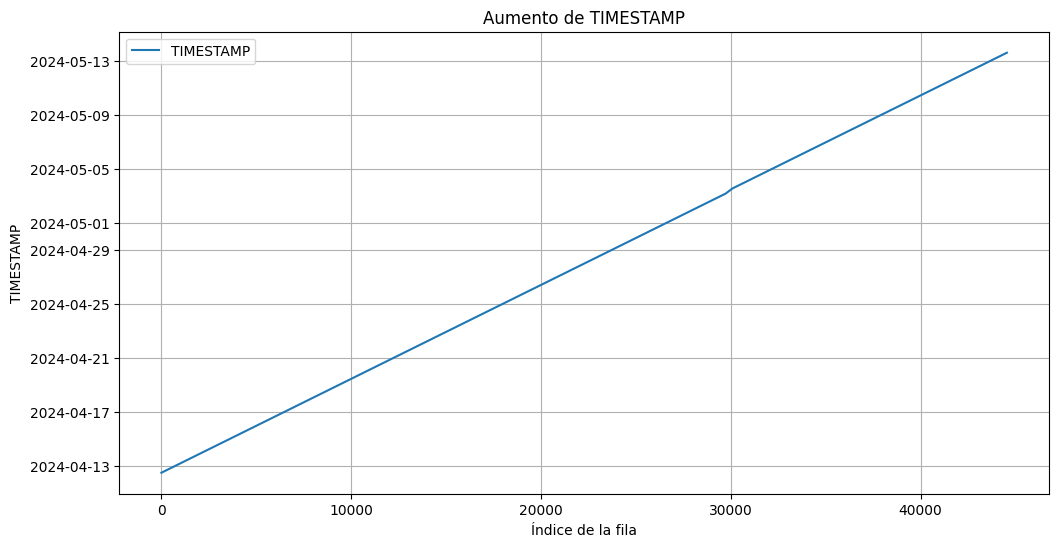

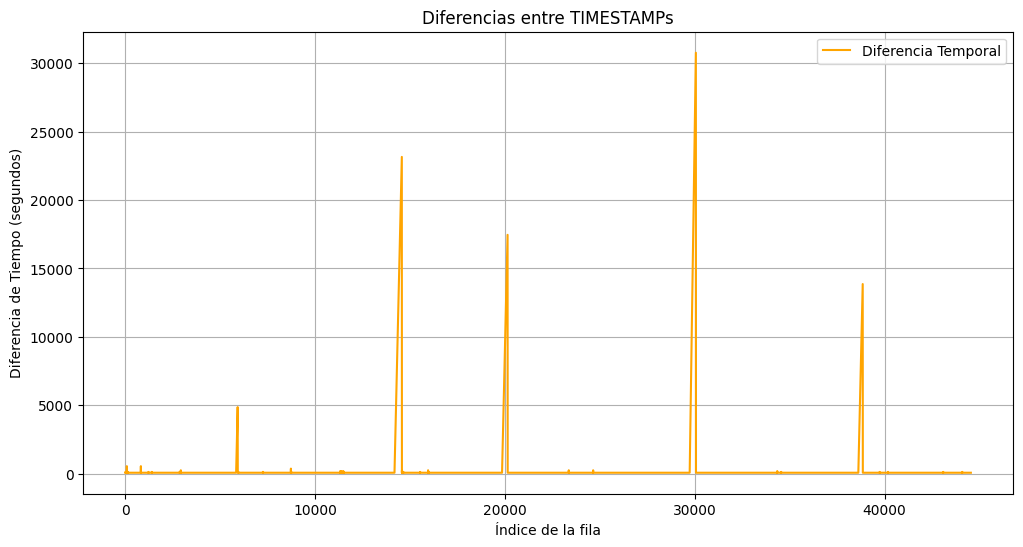

<bound method NDFrame.head of 2         NaN
3        60.0
4        60.0
5        60.0
6        60.0
         ... 
44545    60.0
44546    60.0
44547    60.0
44548    60.0
44549    60.0
Name: TIME_DIFF, Length: 43163, dtype: float64>
<bound method NDFrame.tail of 2         NaN
3        60.0
4        60.0
5        60.0
6        60.0
         ... 
44545    60.0
44546    60.0
44547    60.0
44548    60.0
44549    60.0
Name: TIME_DIFF, Length: 43163, dtype: float64>


In [ ]:
# Convertir TIMESTAMP a formato de fecha
X['DATETIME'] = pd.to_datetime(X['ZpTimestamp'], unit='s')

# Calcular diferencia temporal entre filas consecutivas
X['TIME_DIFF'] = X['DATETIME'].diff().dt.total_seconds()

# Graficar los TIMESTAMP
plt.figure(figsize=(12, 6))
plt.plot(X.index, X['DATETIME'], label='TIMESTAMP')
plt.xlabel('Índice de la fila')
plt.ylabel('TIMESTAMP')
plt.title('Aumento de TIMESTAMP')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las diferencias temporales
plt.figure(figsize=(12, 6))
plt.plot(X.index, X['TIME_DIFF'], label='Diferencia Temporal', color='orange')
plt.xlabel('Índice de la fila')
plt.ylabel('Diferencia de Tiempo (segundos)')
plt.title('Diferencias entre TIMESTAMPs')
plt.legend()
plt.grid(True)
plt.show()

print(X['TIME_DIFF'].head)
print(X['TIME_DIFF'].tail)

In [ ]:
# Filtrar los valores en DATASET2['TIME_DIFF'] que sean diferentes a 60
valores_diferentes = X.loc[X['TIME_DIFF'] != 60, 'TIME_DIFF'].to_numpy()

# Imprimir el array con los valores diferentes
print("Valores diferentes a 60 en TIME_DIFF:")
print(valores_diferentes)
print(len(valores_diferentes))
print(len(X))

Valores diferentes a 60 en TIME_DIFF:
[   nan   120.   540.   120.   120.   540.   120.   120.   120.   120.
   240.  4860.   120.   120.   120.   120.   120.   360.   120.   120.
   180.   120.   180.   120.   120.   180.   120. 23160.   240.   120.
   120.   120.   120.   120.   120.   120.   240.   120.   120.   120.
   120.   120.   120. 17460.   240.   240. 30780.   180.   120. 13860.
   120.   120.   120.   120.]
54
43163


### Dataset 2

In [ ]:
X,Y = preprocessing(DATASET2)

    RAW_INTENSITY  RAW_KIND  HEART_RATE  ZpTimestamp
4              12        80          66   1712947260
14             23        80          63   1712947860
24             41        96          71   1712948460
34             18        80          73   1712949060
44             26        80          67   1712949660
0: 4
1: 5
2: 7
3: 8


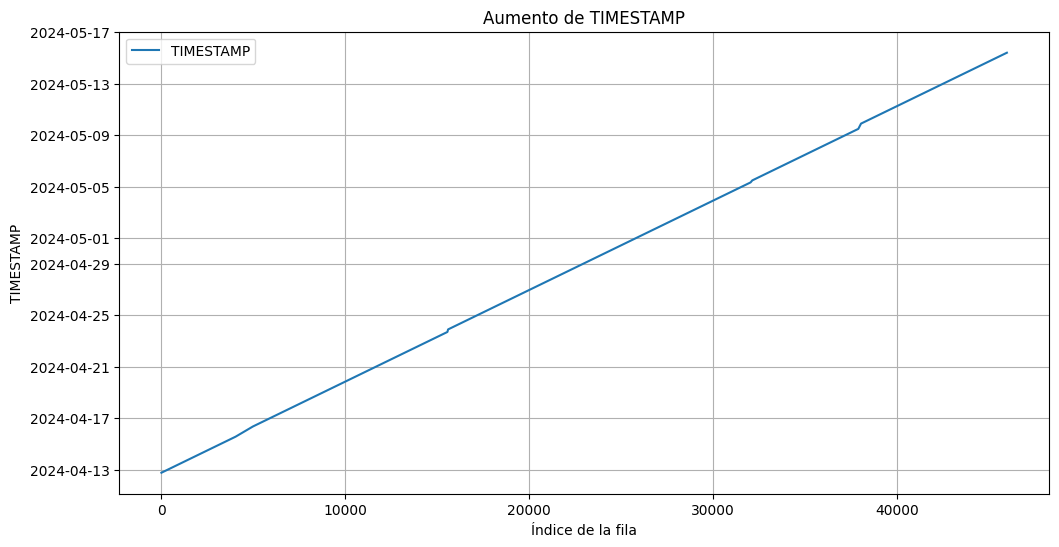

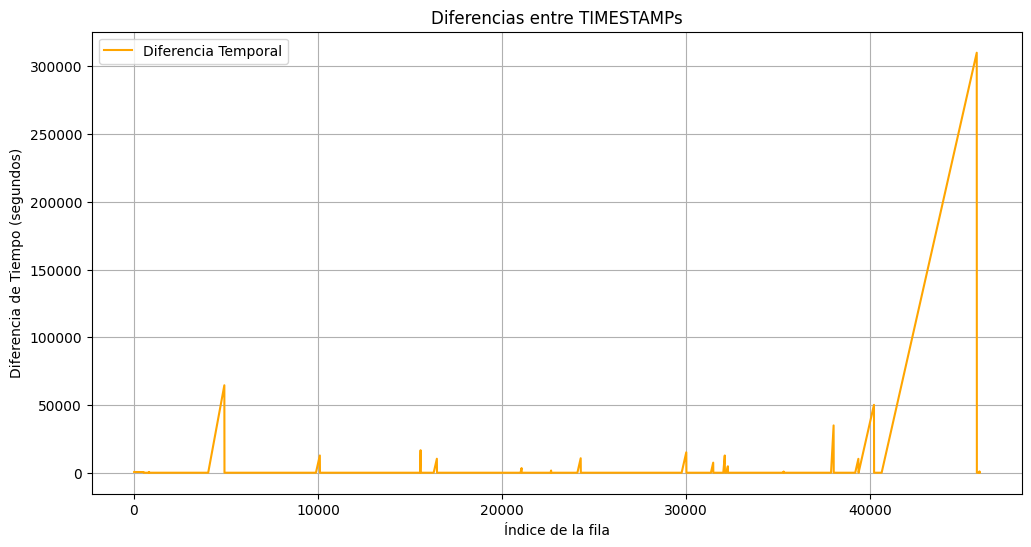

<bound method NDFrame.head of 4          NaN
14       600.0
24       600.0
34       600.0
44       600.0
         ...  
45952     60.0
45953     60.0
45954     60.0
45955     60.0
45956     60.0
Name: TIME_DIFF, Length: 37030, dtype: float64>
<bound method NDFrame.tail of 4          NaN
14       600.0
24       600.0
34       600.0
44       600.0
         ...  
45952     60.0
45953     60.0
45954     60.0
45955     60.0
45956     60.0
Name: TIME_DIFF, Length: 37030, dtype: float64>


In [ ]:
# Convertir TIMESTAMP a formato de fecha
X['DATETIME'] = pd.to_datetime(X['ZpTimestamp'], unit='s')

# Calcular diferencia temporal entre filas consecutivas
X['TIME_DIFF'] = X['DATETIME'].diff().dt.total_seconds()

# Graficar los TIMESTAMP
plt.figure(figsize=(12, 6))
plt.plot(X.index, X['DATETIME'], label='TIMESTAMP')
plt.xlabel('Índice de la fila')
plt.ylabel('TIMESTAMP')
plt.title('Aumento de TIMESTAMP')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las diferencias temporales
plt.figure(figsize=(12, 6))
plt.plot(X.index, X['TIME_DIFF'], label='Diferencia Temporal', color='orange')
plt.xlabel('Índice de la fila')
plt.ylabel('Diferencia de Tiempo (segundos)')
plt.title('Diferencias entre TIMESTAMPs')
plt.legend()
plt.grid(True)
plt.show()

print(X['TIME_DIFF'].head)
print(X['TIME_DIFF'].tail)

In [ ]:
# Filtrar los valores en DATASET2['TIME_DIFF'] que sean diferentes a 60
valores_diferentes = X.loc[X['TIME_DIFF'] != 60, 'TIME_DIFF'].to_numpy()

# Imprimir el array con los valores diferentes
print("Valores diferentes a 60 en TIME_DIFF:")
print(valores_diferentes)
print(len(valores_diferentes))
print(len(X))

Valores diferentes a 60 en TIME_DIFF:
[       nan 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02
 6.0000e+02 6.0000e+02 6.0000e+02 6.0000e+02 5.4000e+02 2.4000e+02
 6.0000e+02 6.0000e+02 6.4620e+04 1.2000e+02 1.2000e+02 1.2000e+02
 1.2780e+04 1.2000e+02 1.2000e+02 1.6680e+04 1.0380e+04 3.4800e+03
 1.6800e+03 1.0740e+04 1.2000e+02 1.5120e+04 7.5000e+03 1.2780e+04
 4.8000e+03 1.2000e+02 9.6000e+02 3.4980e+04 1.0320e+04 5.0160e+04
 3.1008e+05 1.0200e+03]
80
37030


### Dataset 3

In [ ]:
X,Y = preprocessing(DATASET3)

    RAW_INTENSITY  RAW_KIND  HEART_RATE  ZpTimestamp
2              10        80          67   1712644080
48            122       112         112   1712647200
49            106       112          98   1712647260
50            106        64         106   1712647320
51            108        96         109   1712647380
0: 4
1: 5
2: 7
3: 8


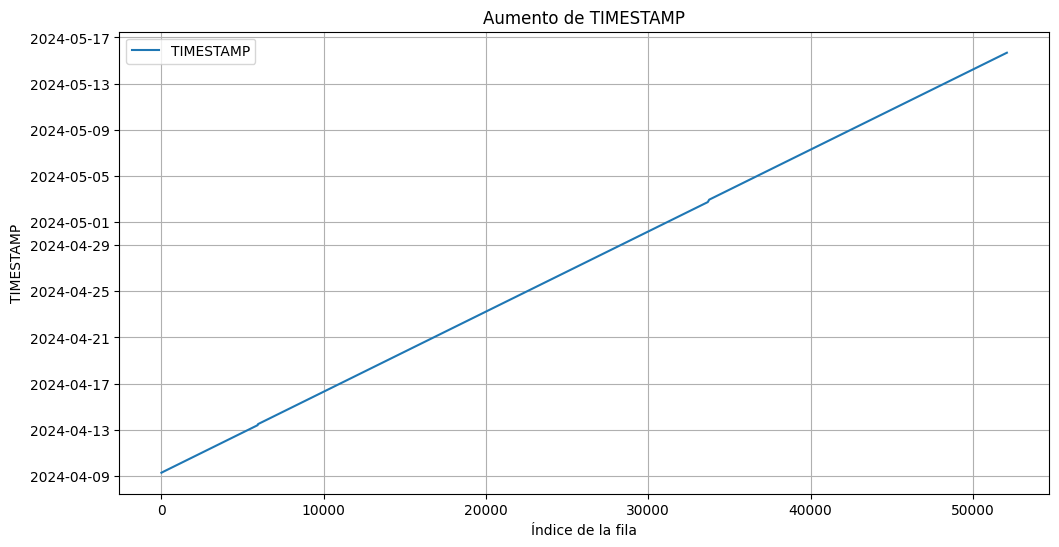

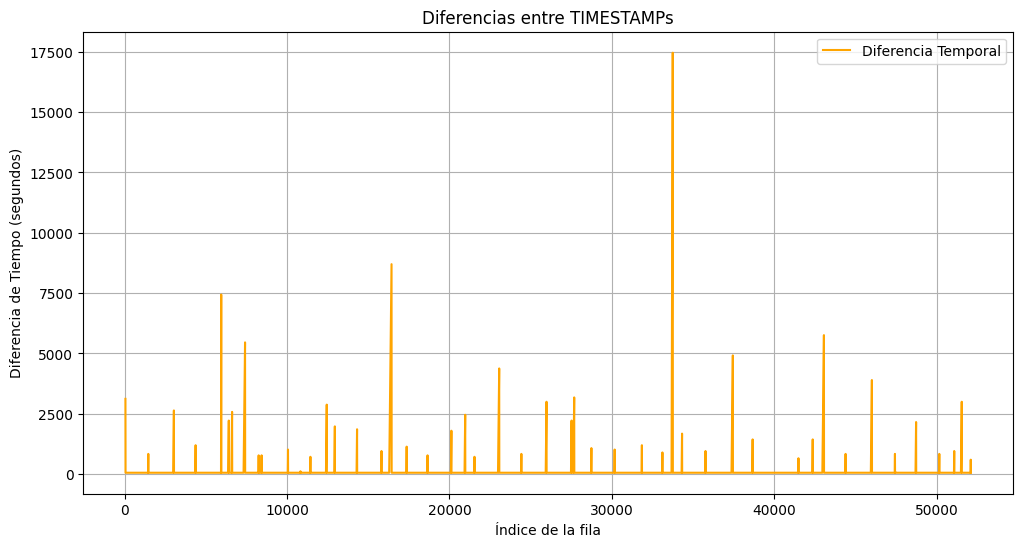

<bound method NDFrame.head of 2           NaN
48       3120.0
49         60.0
50         60.0
51         60.0
          ...  
52096     240.0
52097      60.0
52098      60.0
52099      60.0
52100      60.0
Name: TIME_DIFF, Length: 50518, dtype: float64>
<bound method NDFrame.tail of 2           NaN
48       3120.0
49         60.0
50         60.0
51         60.0
          ...  
52096     240.0
52097      60.0
52098      60.0
52099      60.0
52100      60.0
Name: TIME_DIFF, Length: 50518, dtype: float64>


In [ ]:
# Convertir TIMESTAMP a formato de fecha
X['DATETIME'] = pd.to_datetime(X['ZpTimestamp'], unit='s')

# Calcular diferencia temporal entre filas consecutivas
X['TIME_DIFF'] = X['DATETIME'].diff().dt.total_seconds()

# Graficar los TIMESTAMP
plt.figure(figsize=(12, 6))
plt.plot(X.index, X['DATETIME'], label='TIMESTAMP')
plt.xlabel('Índice de la fila')
plt.ylabel('TIMESTAMP')
plt.title('Aumento de TIMESTAMP')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las diferencias temporales
plt.figure(figsize=(12, 6))
plt.plot(X.index, X['TIME_DIFF'], label='Diferencia Temporal', color='orange')
plt.xlabel('Índice de la fila')
plt.ylabel('Diferencia de Tiempo (segundos)')
plt.title('Diferencias entre TIMESTAMPs')
plt.legend()
plt.grid(True)
plt.show()

print(X['TIME_DIFF'].head)
print(X['TIME_DIFF'].tail)

In [ ]:
# Filtrar los valores en DATASET2['TIME_DIFF'] que sean diferentes a 60
valores_diferentes = X.loc[X['TIME_DIFF'] != 60, 'TIME_DIFF'].to_numpy()

# Imprimir el array con los valores diferentes
print("Valores diferentes a 60 en TIME_DIFF:")
print(valores_diferentes)
print(len(valores_diferentes))
print(len(X))

Valores diferentes a 60 en TIME_DIFF:
[   nan  3120.   840.  2640.  1200.  7440.  2220.  2580.  5460.   780.
   780.  1020.   120.   720.  2880.  1980.  1860.   960.  8700.  1140.
   780.  1800.  2460.   720.  4380.   840.  3000.  2220.  3180.  1080.
  1020.  1200.   900. 17460.  1680.   960.  4920.  1440.   660.  1440.
  5760.   840.  3900.   840.   120.  2160.   840.   960.  3000.   600.
   240.]
51
50518


# Entreno con Dataset 1


> Se divide el dataset 1 en entrenamiento, validación y prueba (70%, 20% y 10%). Además, se prueban de manera independiente los modelos en el Dataset 3.



# LSTM


## LSTM: tamaño de ventana 5

In [ ]:
X, Y = preprocessing(DATASET1)

# 4:    Sueño ligero
# 5:    Sueño profundo
# 7:    Despierto
# 8:    REM

   RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2             66      7        80          80
3             77     62        80         130
4             15      0        80         112
5             63     26        64         131
6            106     95        64         125
0: 4
1: 5
2: 7
3: 8


Tamaño de los conjuntos de datos:
Entrenamiento: (30210, 5, 4), Validación: (8631, 5, 4), Test: (4317, 5, 4)
Etiquetas Entrenamiento: (30210, 4), Validación: (8631, 4), Test: (4317, 4)
Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.0994 - loss: 1.3965 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3986 - val_accuracy: 0.0506 - val_loss: 1.3910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3954
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1259 - loss: 1.3928 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4373 - val_accuracy: 0.1083 - val_loss: 1.3873 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4166
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2119 - loss: 1.3894 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5061 - val_accuracy: 0.2613 - val_loss: 1.3824 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5477
Epoch 4/30
11

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


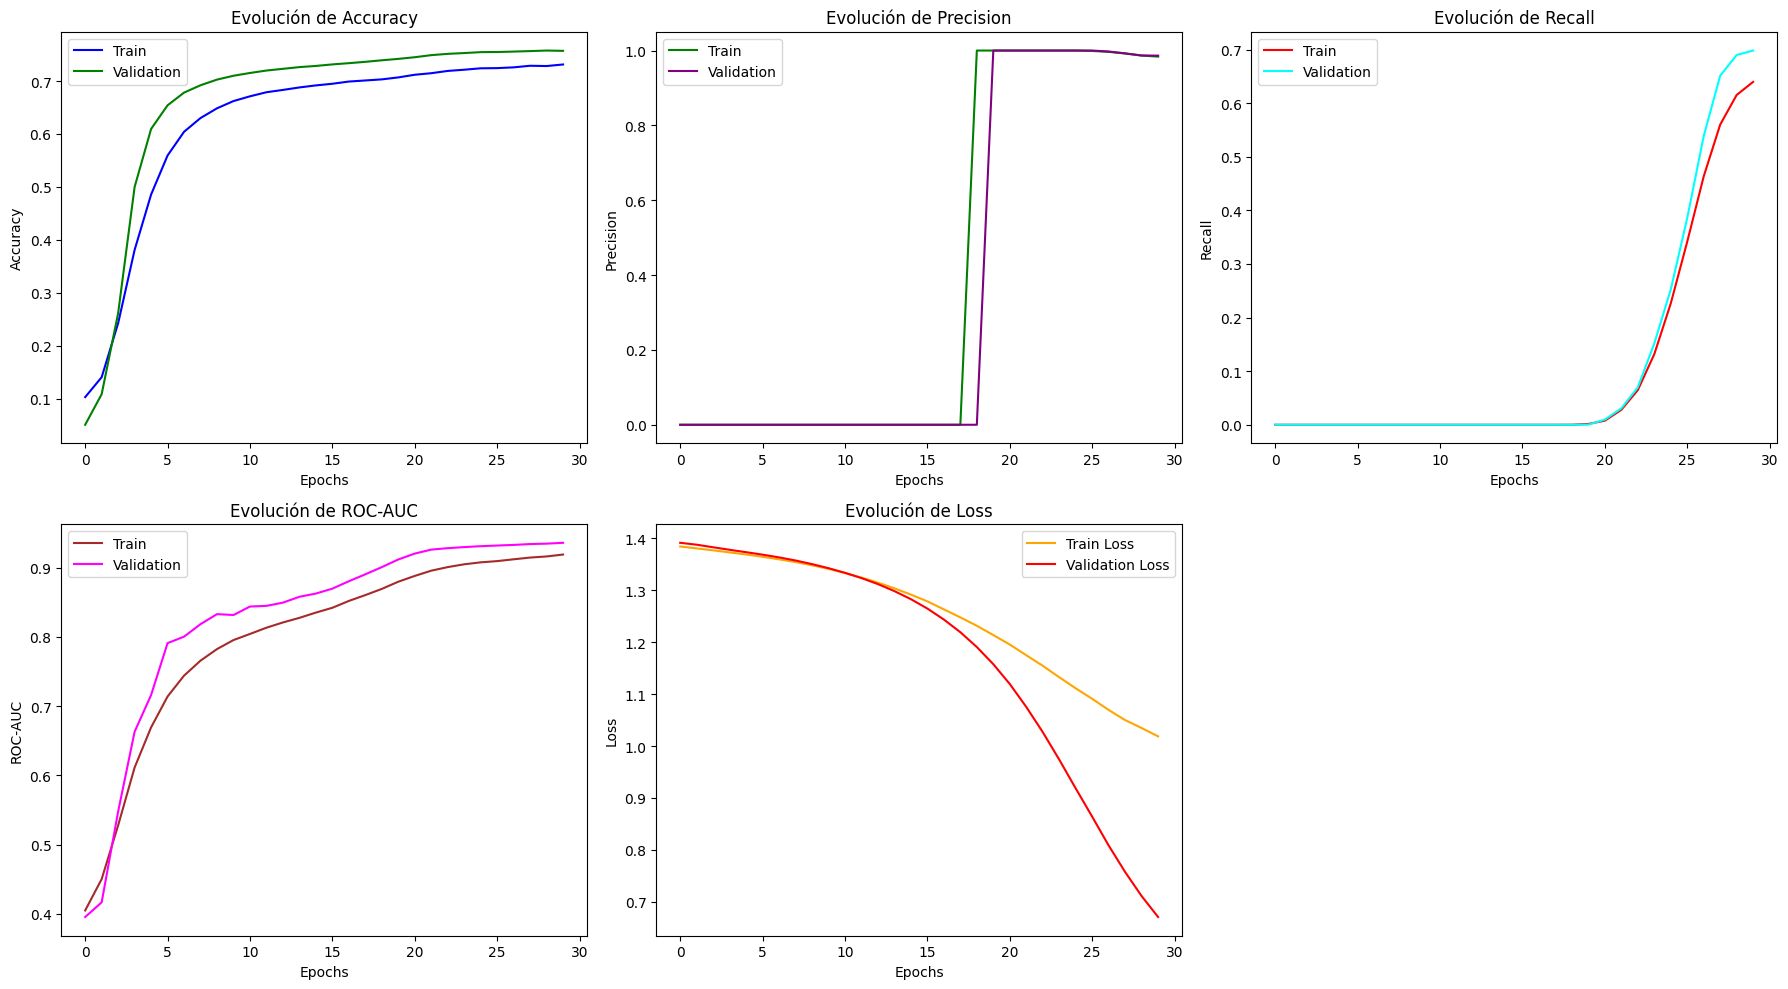

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save256, history_save256 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset1_pruebasmetrica256s_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12661
Porcentaje de acierto: 74.94%
Porcentaje de fallo: 25.06%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


{'accuracy': 0.7493516520499673,
 'f1_score': 0.7121517367374067,
 'precision': 0.7015620438723851,
 'recall': 0.7493516520499673,
 'confusion_matrix': array([[    0,  1080,  1421,  6147],
        [    0,   288,    95,  2140],
        [    0,   504, 34127,  1008],
        [    0,   235,    31,  3437]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (30210, 5, 4), Validación: (8631, 5, 4), Test: (4317, 5, 4)
Etiquetas Entrenamiento: (30210, 4), Validación: (8631, 4), Test: (4317, 4)
Epoch 1/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1030 - loss: 1.3970 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4028 - val_accuracy: 0.0994 - val_loss: 1.3883 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4076
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2100 - loss: 1.3906 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5046 - val_accuracy: 0.3806 - val_loss: 1.3798 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6143
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4279 - loss: 1.3832 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6370 - val_accuracy: 0.6146 - val_loss: 1.3714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7233
Epoch 4/30
23

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


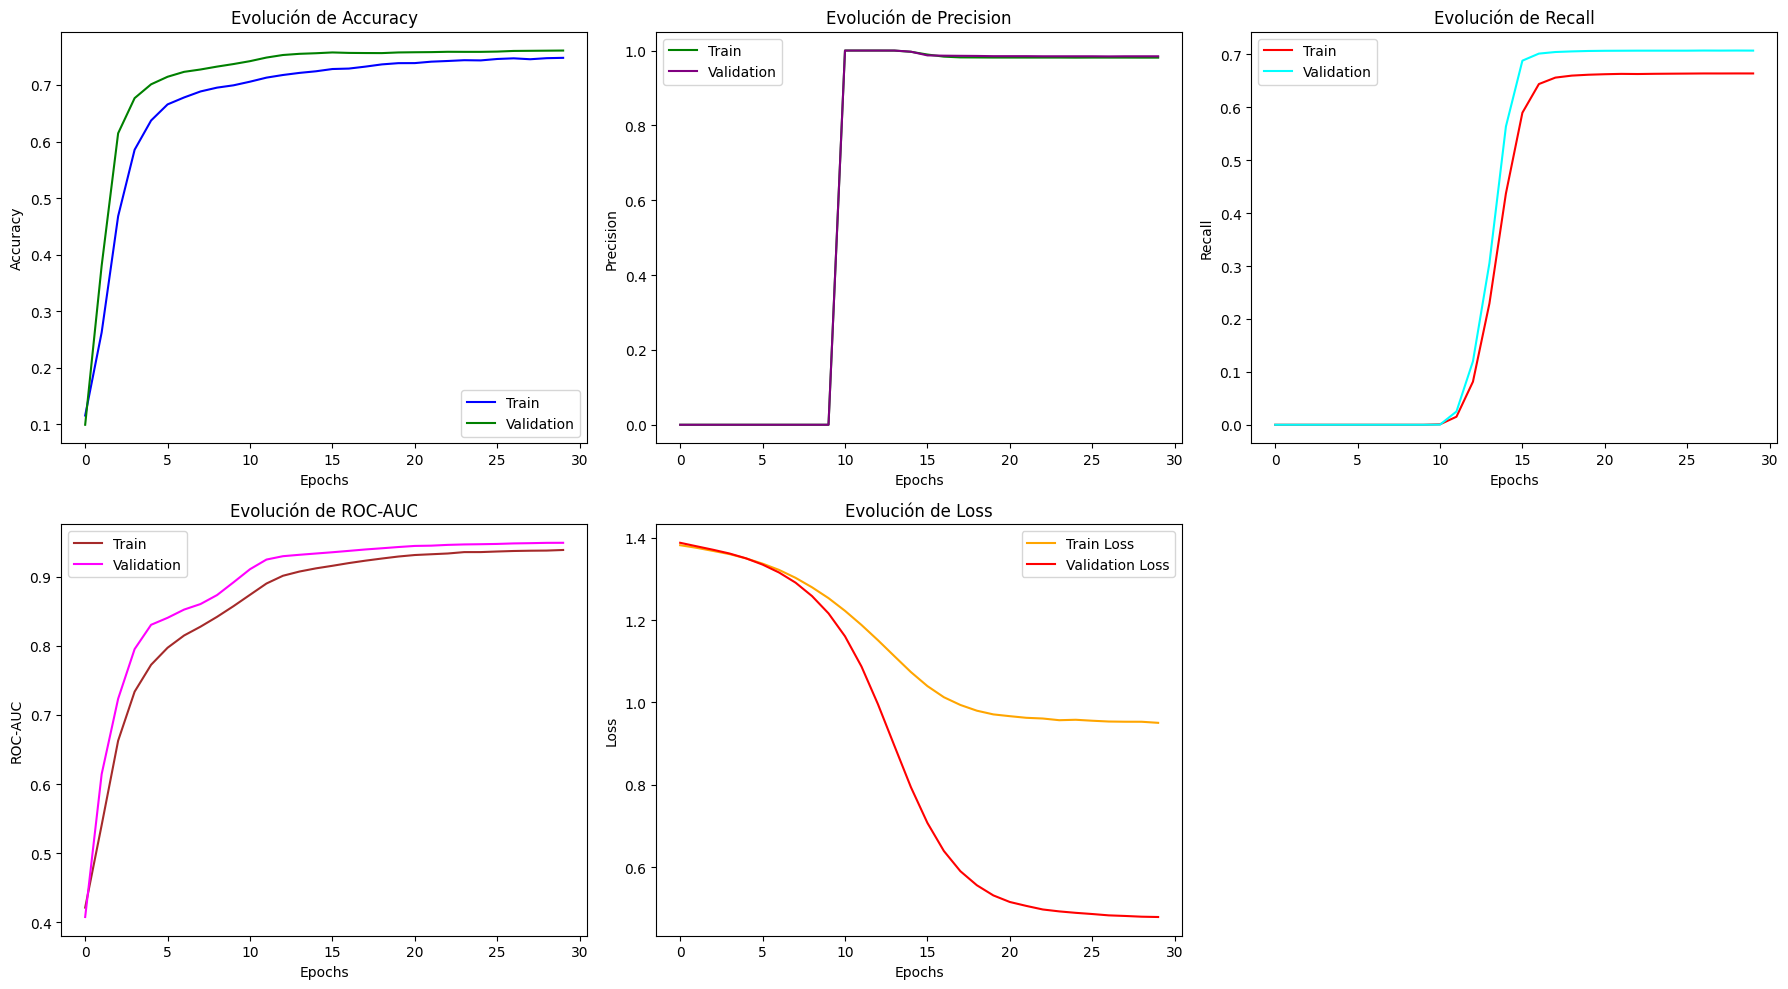

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save51, history_save51 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset1_pruebasmetricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save51, X_test, y_test)
GetMetrics(model_save51, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12437
Porcentaje de acierto: 75.38%
Porcentaje de fallo: 24.62%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


{'accuracy': 0.753786154059351,
 'f1_score': 0.7189352432592468,
 'precision': 0.7044177997336624,
 'recall': 0.753786154059351,
 'confusion_matrix': array([[    0,  2294,  1463,  4891],
        [    0,   753,   110,  1660],
        [    0,   600, 34234,   805],
        [    0,   576,    38,  3089]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (30210, 5, 4), Validación: (8631, 5, 4), Test: (4317, 5, 4)
Etiquetas Entrenamiento: (30210, 4), Validación: (8631, 4), Test: (4317, 4)
Epoch 1/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.1205 - loss: 1.3963 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4249 - val_accuracy: 0.2448 - val_loss: 1.3822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5477
Epoch 2/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3975 - loss: 1.3848 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6291 - val_accuracy: 0.6532 - val_loss: 1.3668 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7936
Epoch 3/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6121 - loss: 1.3701 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7564 - val_accuracy: 0.7061 - val_loss: 1.3472 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8378
Epoch 4/30
4

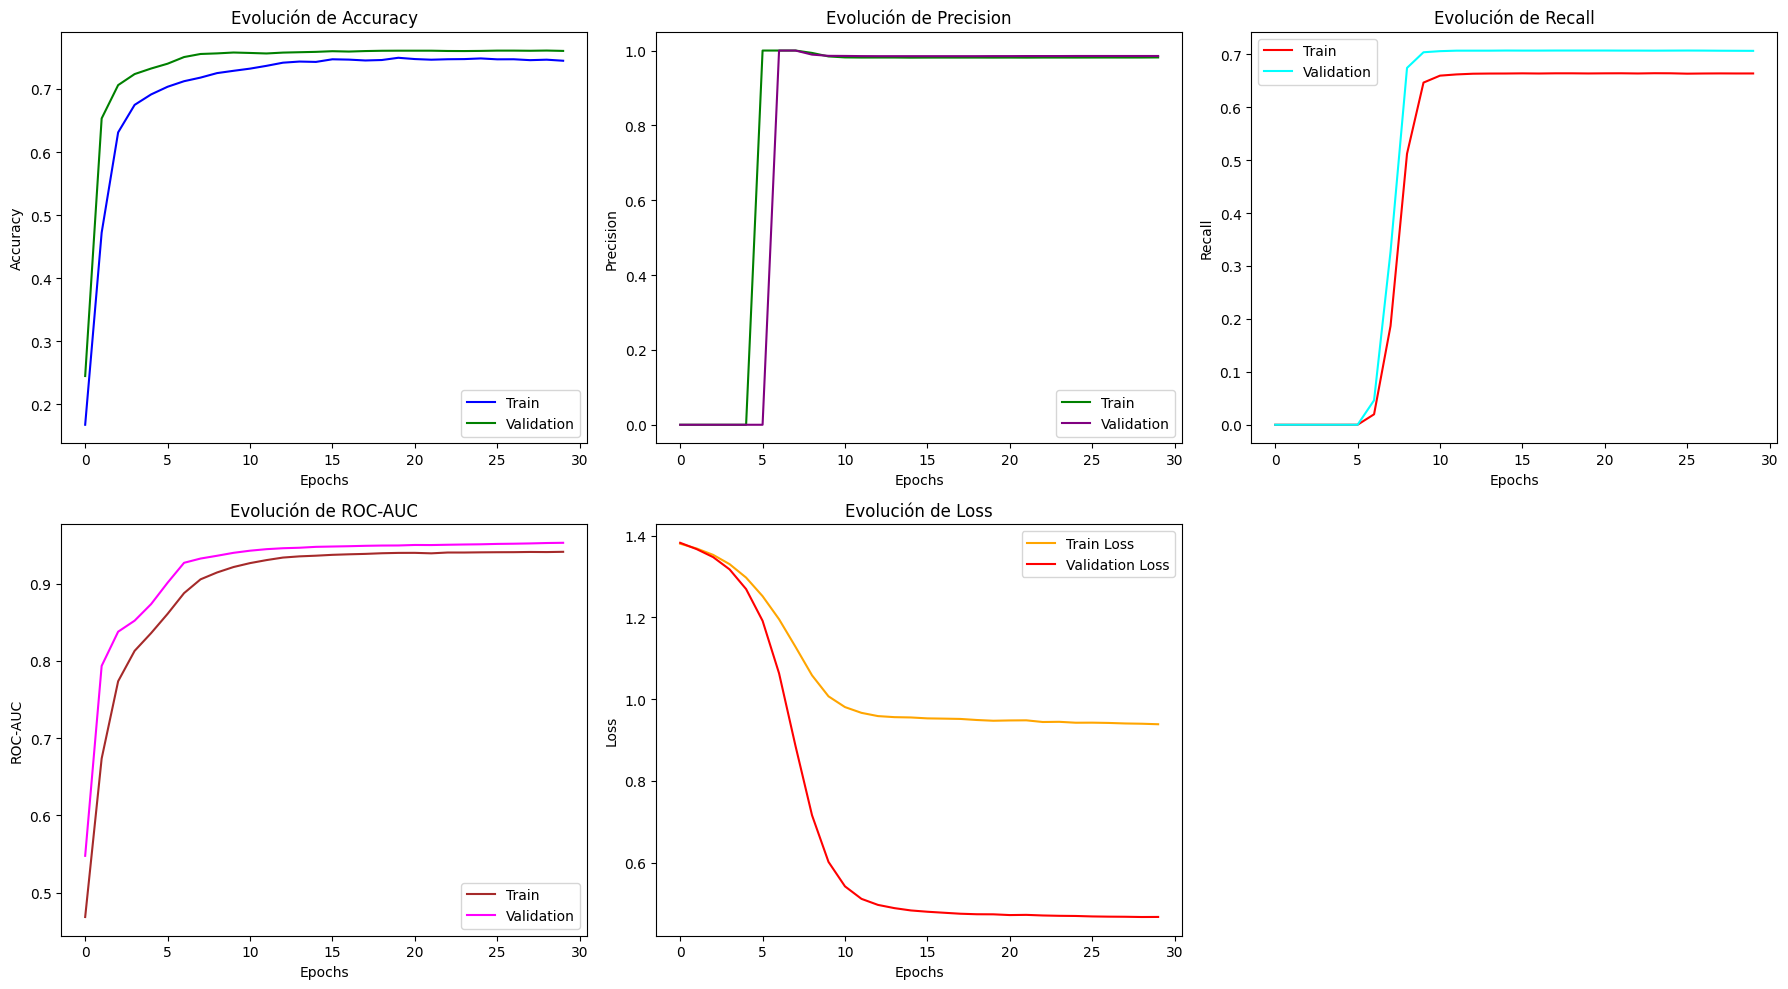

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save64, history_save64 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset1_pruebasbs_64metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12337
Porcentaje de acierto: 75.58%
Porcentaje de fallo: 24.42%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


{'accuracy': 0.7557658424563973,
 'f1_score': 0.7241420398720468,
 'precision': 0.7883544790734897,
 'recall': 0.7557658424563973,
 'confusion_matrix': array([[   77,  2691,  1433,  4447],
        [   17,   944,    93,  1469],
        [   53,   570, 34273,   743],
        [   14,   775,    32,  2882]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (30210, 5, 4), Validación: (8631, 5, 4), Test: (4317, 5, 4)
Etiquetas Entrenamiento: (30210, 4), Validación: (8631, 4), Test: (4317, 4)
Epoch 1/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1569 - loss: 1.3948 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4527 - val_accuracy: 0.5753 - val_loss: 1.3722 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7060
Epoch 2/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5785 - loss: 1.3732 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7404 - val_accuracy: 0.7138 - val_loss: 1.3377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8380
Epoch 3/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6797 - loss: 1.3359 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.8216 - val_accuracy: 0.7344 - val_loss: 1.2629 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8789
Epoch 4/30


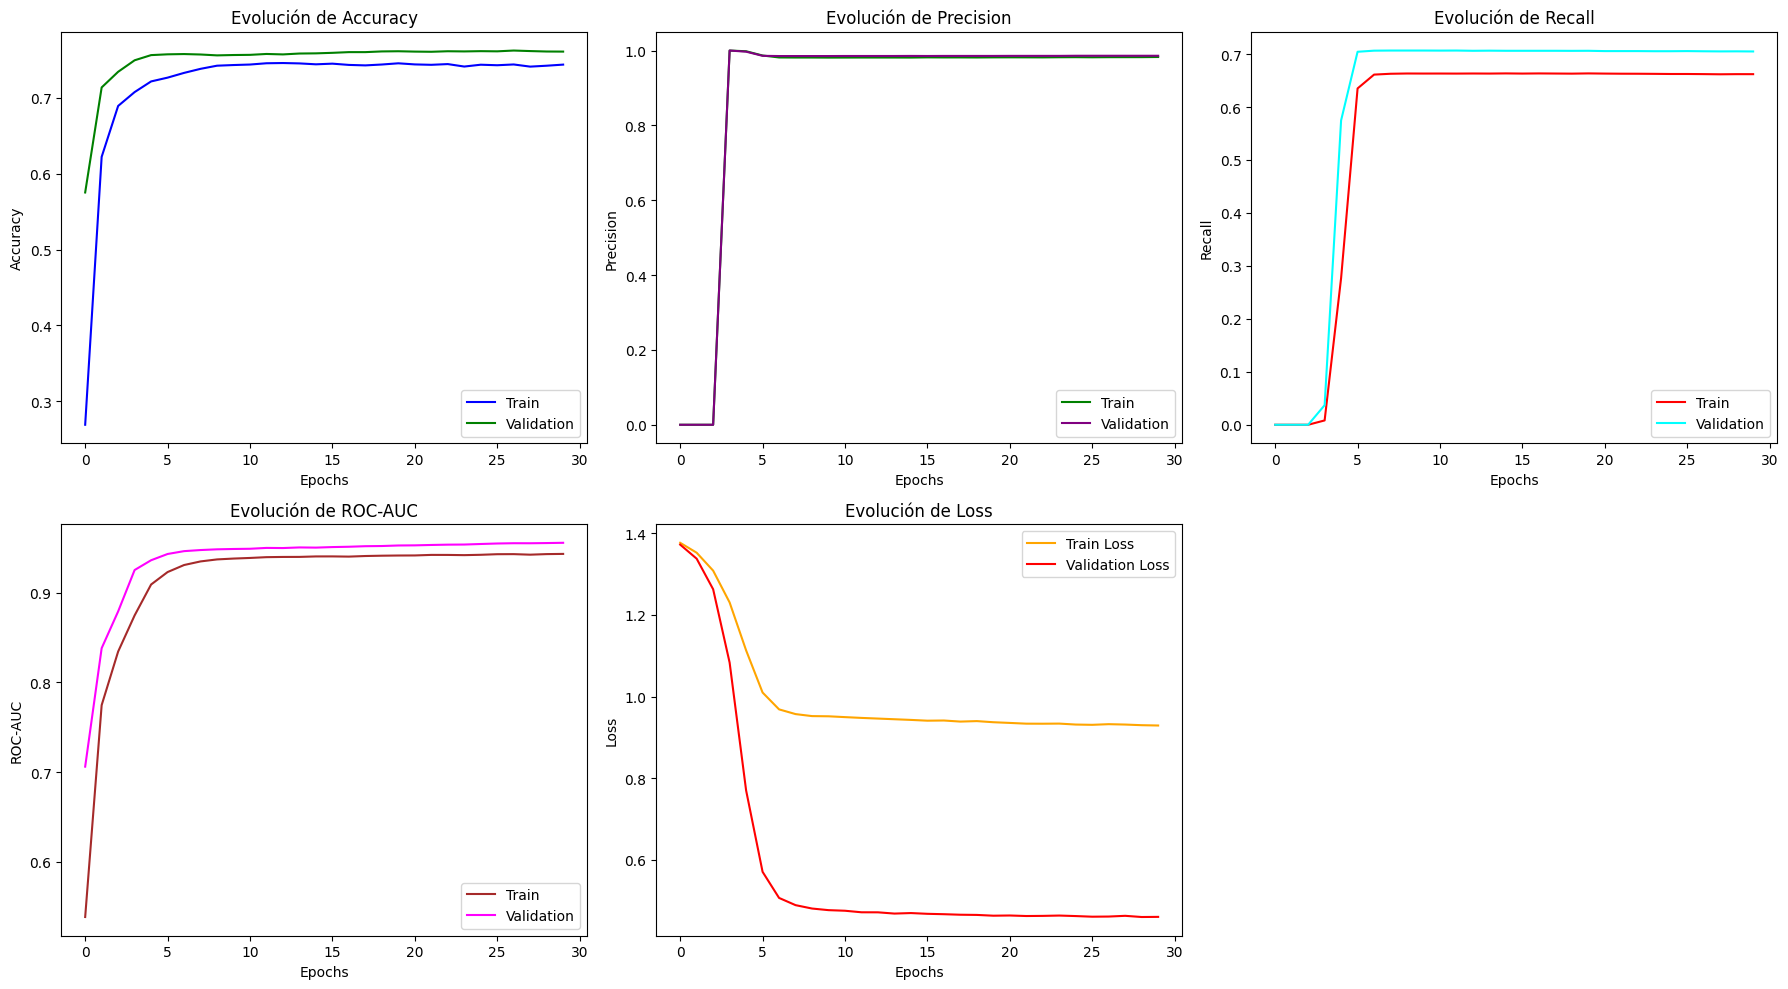

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save32, history_save32 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset1_pruebasbs_32metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12157
Porcentaje de acierto: 75.93%
Porcentaje de fallo: 24.07%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


{'accuracy': 0.7593292815710807,
 'f1_score': 0.736822551655113,
 'precision': 0.7898223754167969,
 'recall': 0.7593292815710807,
 'confusion_matrix': array([[  397,  2901,  1368,  3982],
        [   78,  1139,    66,  1240],
        [  302,   466, 34203,   668],
        [   70,   991,    25,  2617]]),
 'auc': None}

## LSTM: tamaño de ventana 10

In [ ]:
X, Y = preprocessing(DATASET1)

   RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2             66      7        80          80
3             77     62        80         130
4             15      0        80         112
5             63     26        64         131
6            106     95        64         125
0: 4
1: 5
2: 7
3: 8


Tamaño de los conjuntos de datos:
Entrenamiento: (30207, 10, 4), Validación: (8630, 10, 4), Test: (4316, 10, 4)
Etiquetas Entrenamiento: (30207, 4), Validación: (8630, 4), Test: (4316, 4)
Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.0973 - loss: 1.3766 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3807 - val_accuracy: 0.0492 - val_loss: 1.3951 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3550
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1199 - loss: 1.3691 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4201 - val_accuracy: 0.0910 - val_loss: 1.3910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3912
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.1940 - loss: 1.3627 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4875 - val_accuracy: 0.2190 - val_loss: 1.3835 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4791
Epoch 4/30

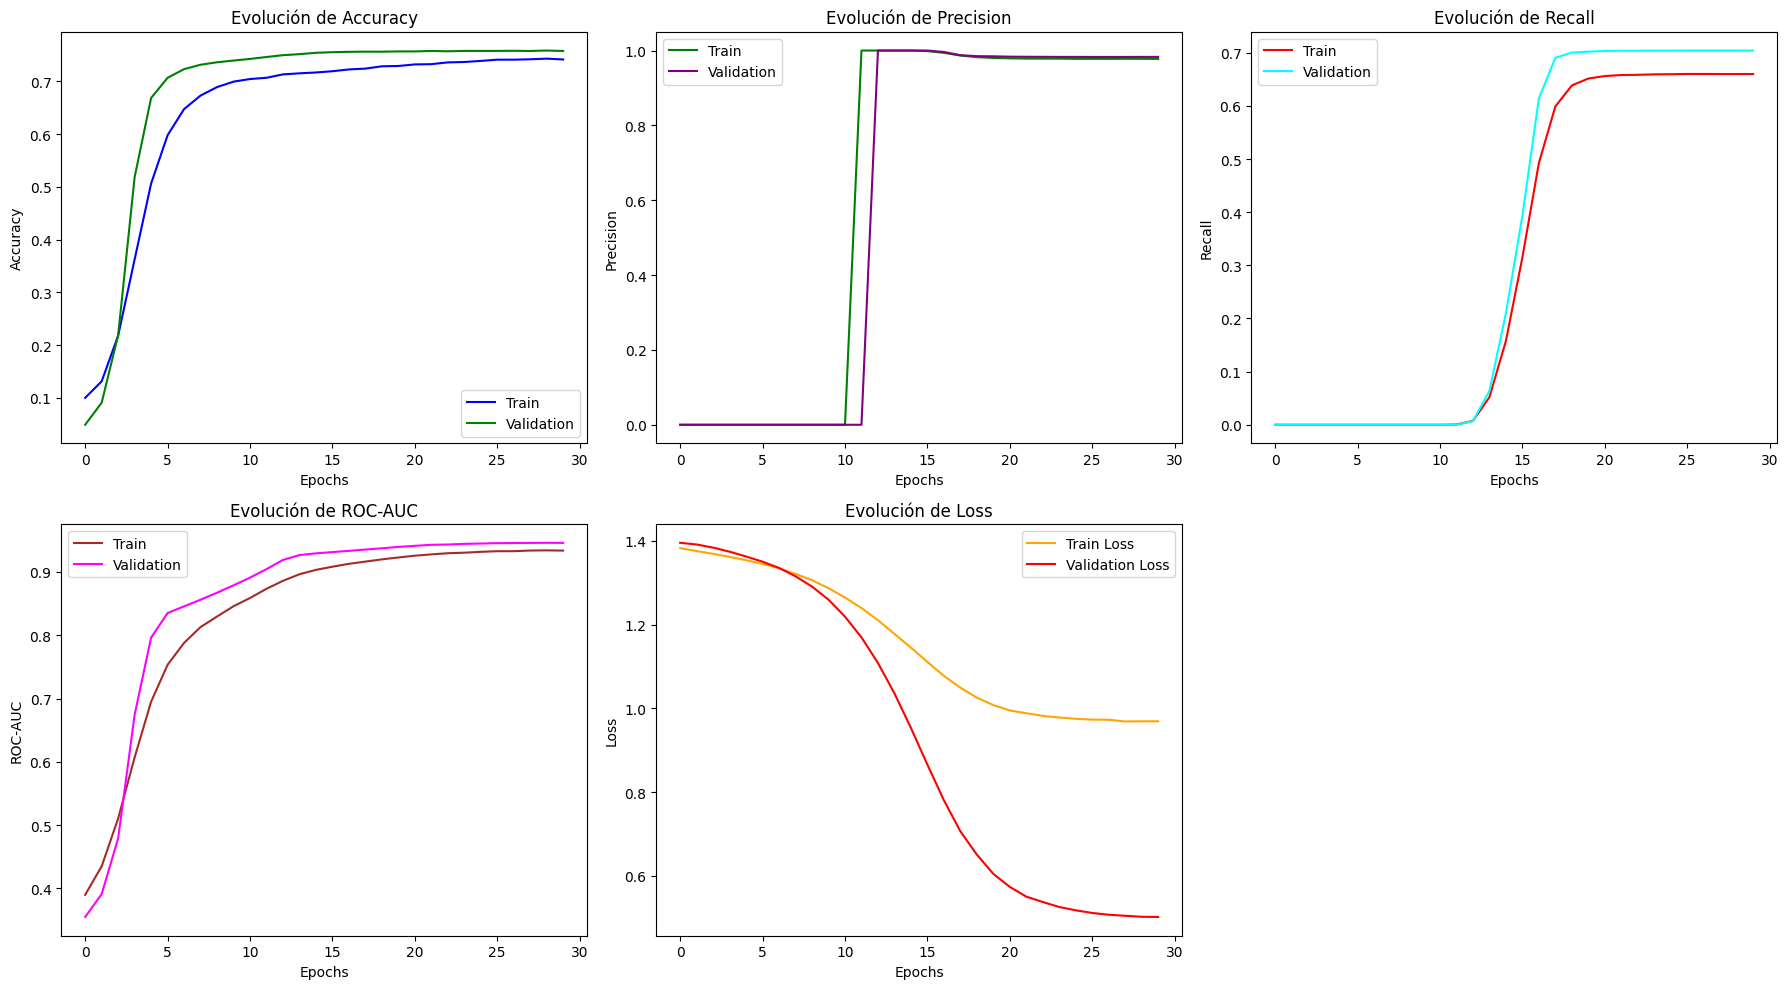

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save256, history_save256 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset1_pruebasbs_256metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12452
Porcentaje de acierto: 75.35%
Porcentaje de fallo: 24.65%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


{'accuracy': 0.7534647976558169,
 'f1_score': 0.726151960077049,
 'precision': 0.7931693463270012,
 'recall': 0.7534647976558169,
 'confusion_matrix': array([[  360,  1203,  1355,  5730],
        [   80,   441,   197,  1805],
        [  176,   401, 34009,  1048],
        [   65,   311,    81,  3246]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (30207, 10, 4), Validación: (8630, 10, 4), Test: (4316, 10, 4)
Etiquetas Entrenamiento: (30207, 4), Validación: (8630, 4), Test: (4316, 4)
Epoch 1/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.5717 - loss: 1.3969 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7448 - val_accuracy: 0.5663 - val_loss: 1.3658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8070
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.4696 - loss: 1.3770 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7377 - val_accuracy: 0.4841 - val_loss: 1.3605 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7994
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5674 - loss: 1.3608 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7811 - val_accuracy: 0.7183 - val_loss: 1.3398 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8545
Epoch 4/3

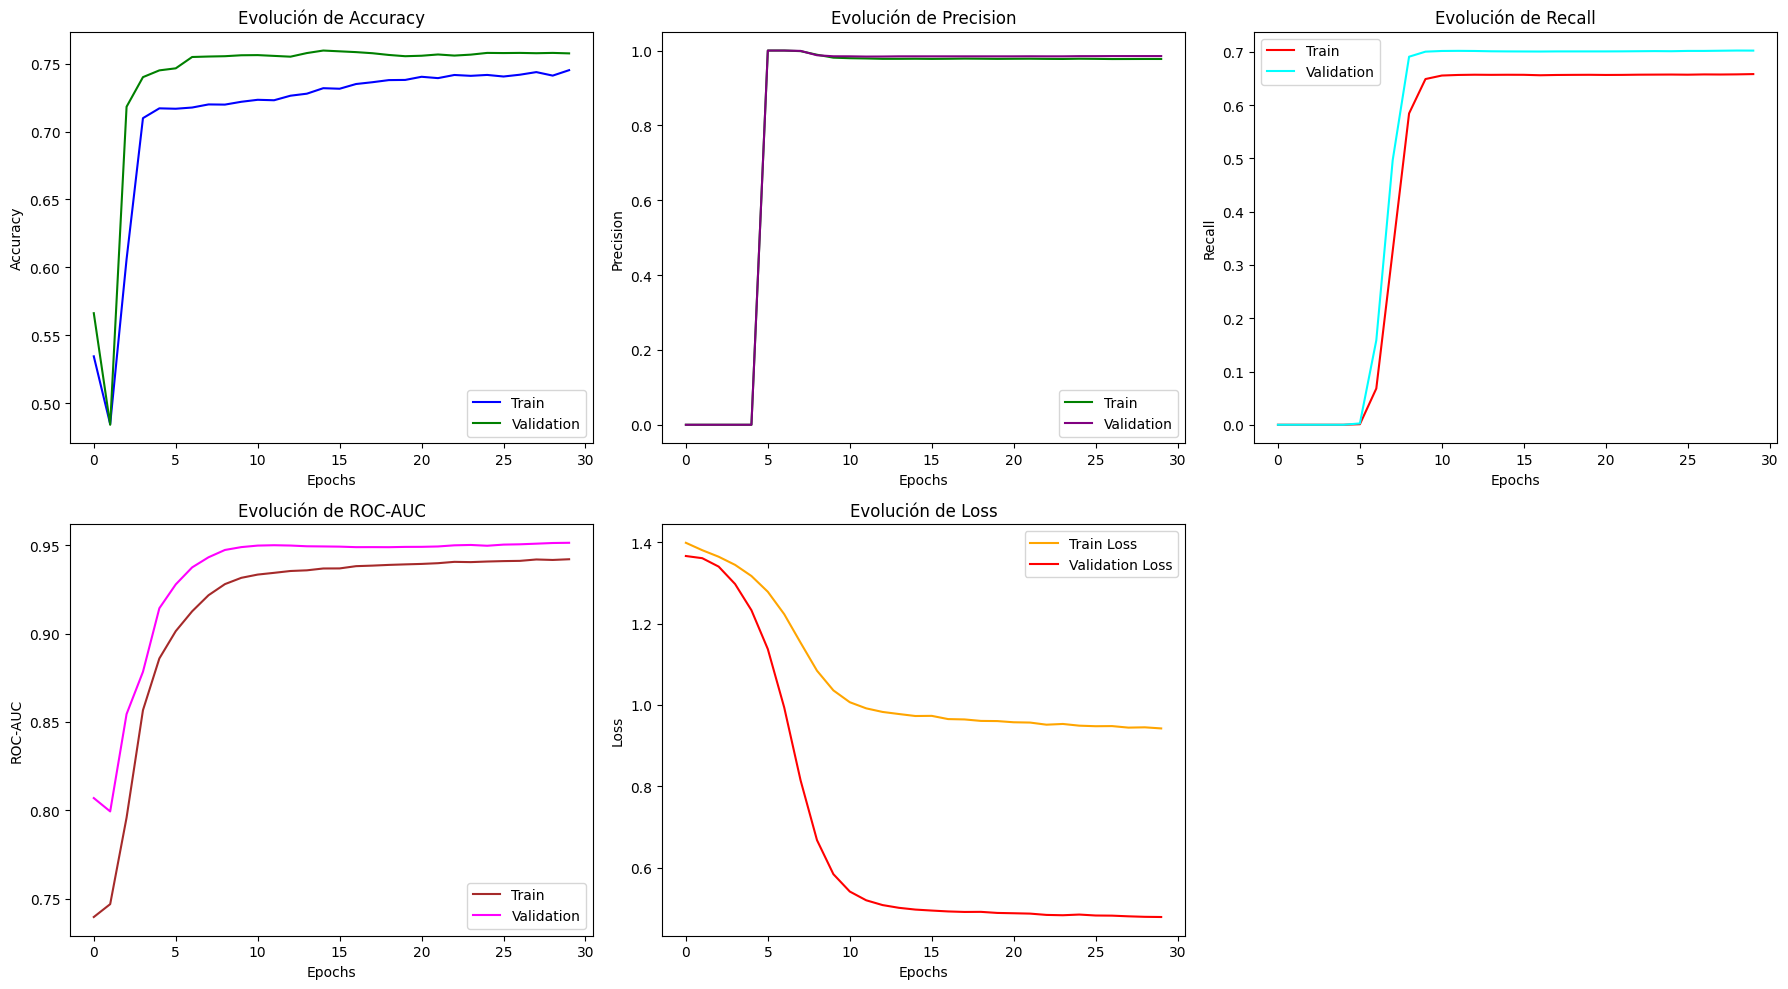

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save128, history_save128 = LSTM_(X_seq, y_seq, MODELOS+"18_10_LSTMDataset1_pruebasbs_128metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save128, X_test, y_test)
GetMetrics(model_save128, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12717
Porcentaje de acierto: 74.82%
Porcentaje de fallo: 25.18%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


{'accuracy': 0.7482181040627227,
 'f1_score': 0.7216897835226865,
 'precision': 0.7658640614181347,
 'recall': 0.7482181040627227,
 'confusion_matrix': array([[   57,  3363,  1221,  4007],
        [   19,  1307,   119,  1078],
        [   84,   887, 33926,   737],
        [   14,  1152,    36,  2501]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (30207, 10, 4), Validación: (8630, 10, 4), Test: (4316, 10, 4)
Etiquetas Entrenamiento: (30207, 4), Validación: (8630, 4), Test: (4316, 4)
Epoch 1/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.1195 - loss: 1.3720 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4099 - val_accuracy: 0.2892 - val_loss: 1.3813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5174
Epoch 2/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4325 - loss: 1.3505 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6552 - val_accuracy: 0.7248 - val_loss: 1.3391 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8538
Epoch 3/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6827 - loss: 1.3171 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.8222 - val_accuracy: 0.7430 - val_loss: 1.2550 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8907
Epoch 4/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


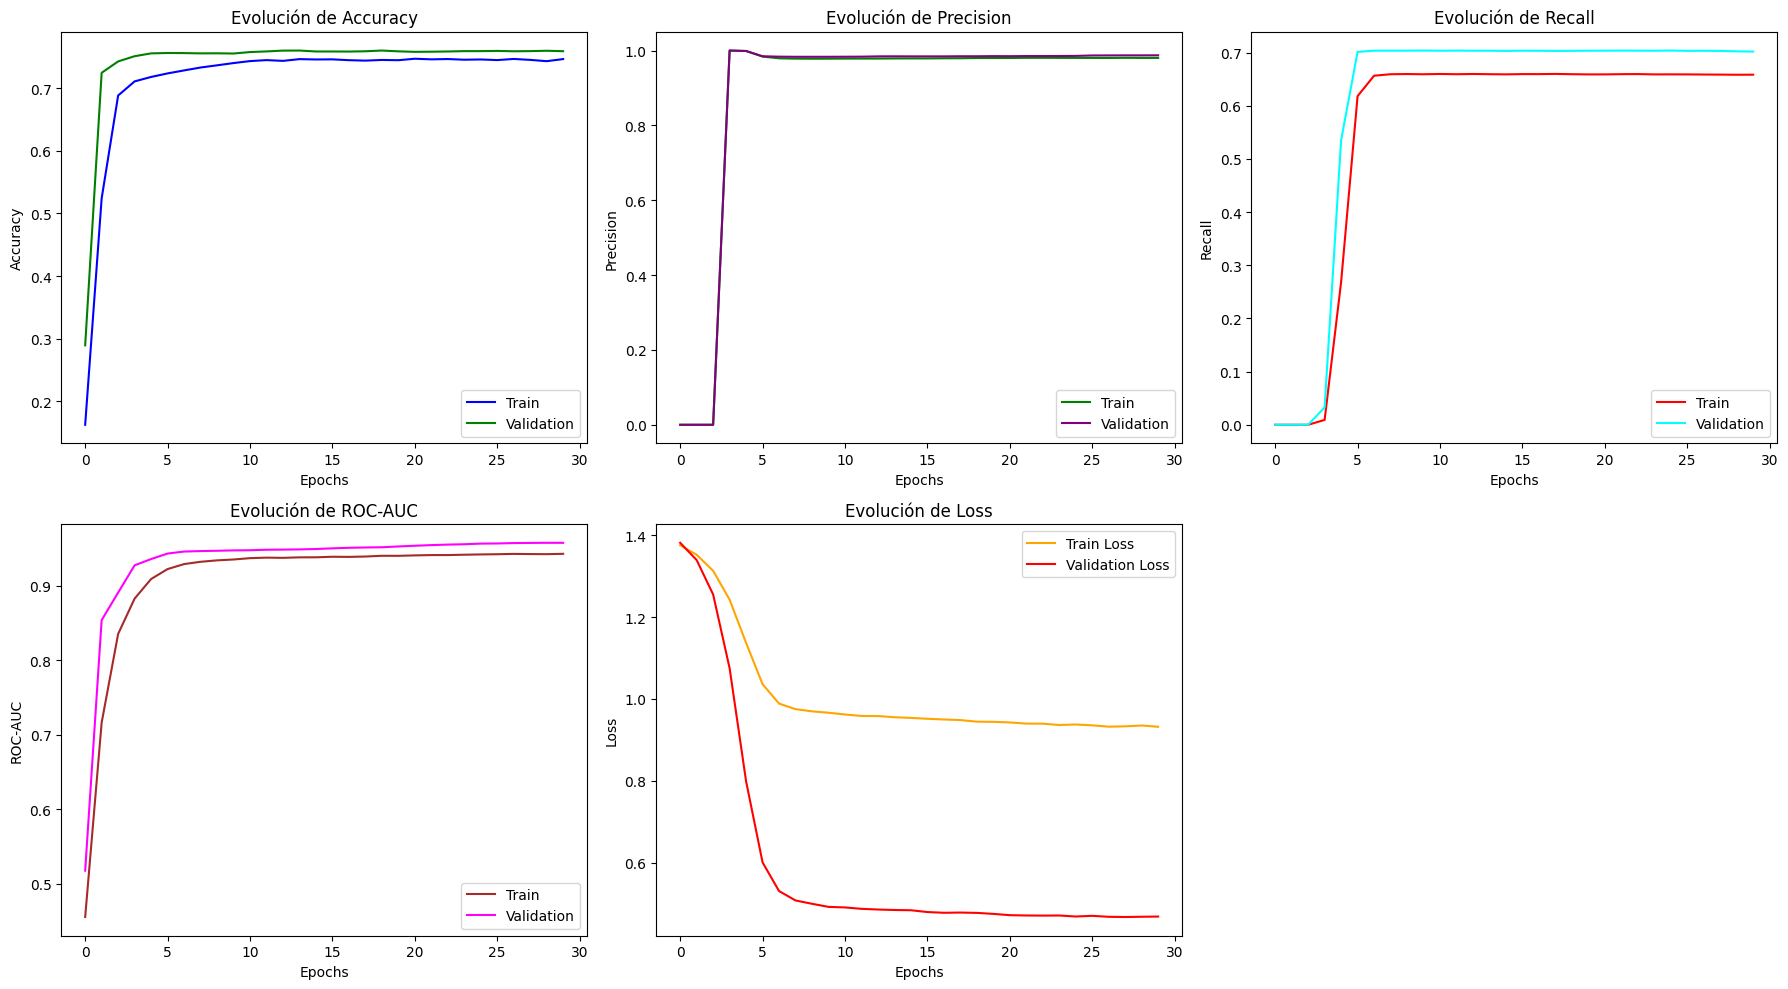

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y)
model_save64, history_save64 = LSTM_(X_seq, y_seq, MODELOS+"18_10_LSTMDataset1_pruebasbs_64metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12686
Porcentaje de acierto: 74.88%
Porcentaje de fallo: 25.12%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


{'accuracy': 0.748831868218896,
 'f1_score': 0.720832634106109,
 'precision': 0.8254814941246442,
 'recall': 0.748831868218896,
 'confusion_matrix': array([[    2,  3243,  1138,  4265],
        [    0,  1186,    95,  1242],
        [    1,   850, 34012,   771],
        [    0,  1058,    23,  2622]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (30207, 10, 4), Validación: (8630, 10, 4), Test: (4316, 10, 4)
Etiquetas Entrenamiento: (30207, 4), Validación: (8630, 4), Test: (4316, 4)
Epoch 1/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.1757 - loss: 1.3676 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4647 - val_accuracy: 0.7072 - val_loss: 1.3519 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8126
Epoch 2/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6710 - loss: 1.3204 - precision: 0.0804 - recall: 4.0033e-06 - roc_auc: 0.8193 - val_accuracy: 0.7504 - val_loss: 1.1696 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9208
Epoch 3/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7221 - loss: 1.1927 - precision: 0.9876 - recall: 0.0948 - roc_auc: 0.9066 - val_accuracy: 0.7560 - val_loss: 0.7225 - val_precision: 0.9939 - val_recall: 0.6600 - val_roc_auc: 0.9411
Epoch 4/30
944/944 ━━━━━━━━━

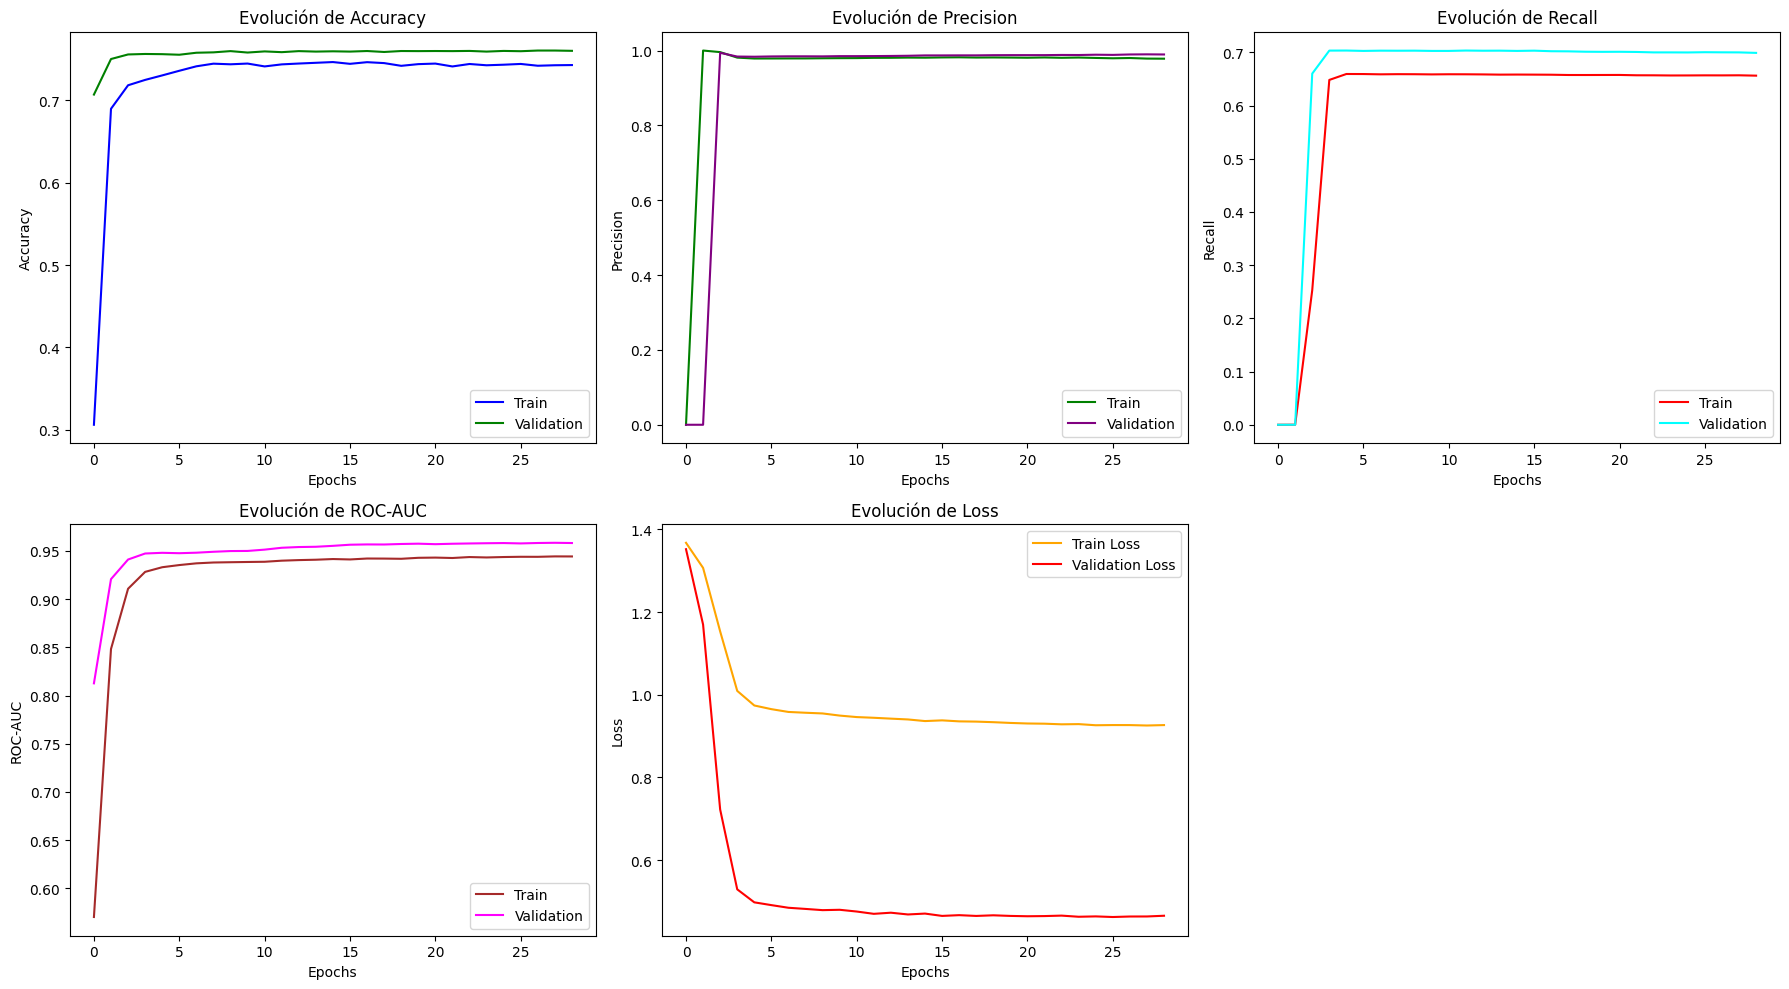

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save32, history_save32 = LSTM_(X_seq, y_seq, MODELOS+"18_10_LSTMDataset1_bs_32met_vent10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12437
Porcentaje de acierto: 75.38%
Porcentaje de fallo: 24.62%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


{'accuracy': 0.7537617803120298,
 'f1_score': 0.7316622004384988,
 'precision': 0.8502230870918227,
 'recall': 0.7537617803120298,
 'confusion_matrix': array([[  220,  3176,   947,  4305],
        [   17,  1196,    75,  1235],
        [   36,   792, 34029,   777],
        [    7,  1050,    20,  2626]]),
 'auc': None}

# RNN

## RNN: tamaño de ventana 5

In [ ]:
X, Y = preprocessing(DATASET1)

# 4:	Sueño ligero
# 5:	Sueño profundo
# 7:  Despierto
# 8:	REM


   RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2             66      7        80          80
3             77     62        80         130
4             15      0        80         112
5             63     26        64         131
6            106     95        64         125
0: 4
1: 5
2: 7
3: 8


Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4511 - loss: 1.5191 - precision: 0.3470 - recall: 0.0125 - roc_auc: 0.7063 - val_accuracy: 0.4081 - val_loss: 1.2772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7362
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4839 - loss: 1.4303 - precision: 0.5089 - recall: 0.0115 - roc_auc: 0.7307 - val_accuracy: 0.5531 - val_loss: 1.2302 - val_precision: 1.0000 - val_recall: 1.1586e-04 - val_roc_auc: 0.8137
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5706 - loss: 1.3669 - precision: 0.7297 - recall: 0.0258 - roc_auc: 0.7917 - val_accuracy: 0.6827 - val_loss: 1.1475 - val_precision: 1.0000 - val_recall: 0.0090 - val_roc_auc: 0.8876
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6637 - loss: 1.3043 - precision: 0.9068 - recall: 0.0755 - roc_auc: 0.8448 - val_accuracy: 0.7355 - val_loss: 1.0429 - val_precision: 1.0000 - val_recall: 0.0782 - val_ro

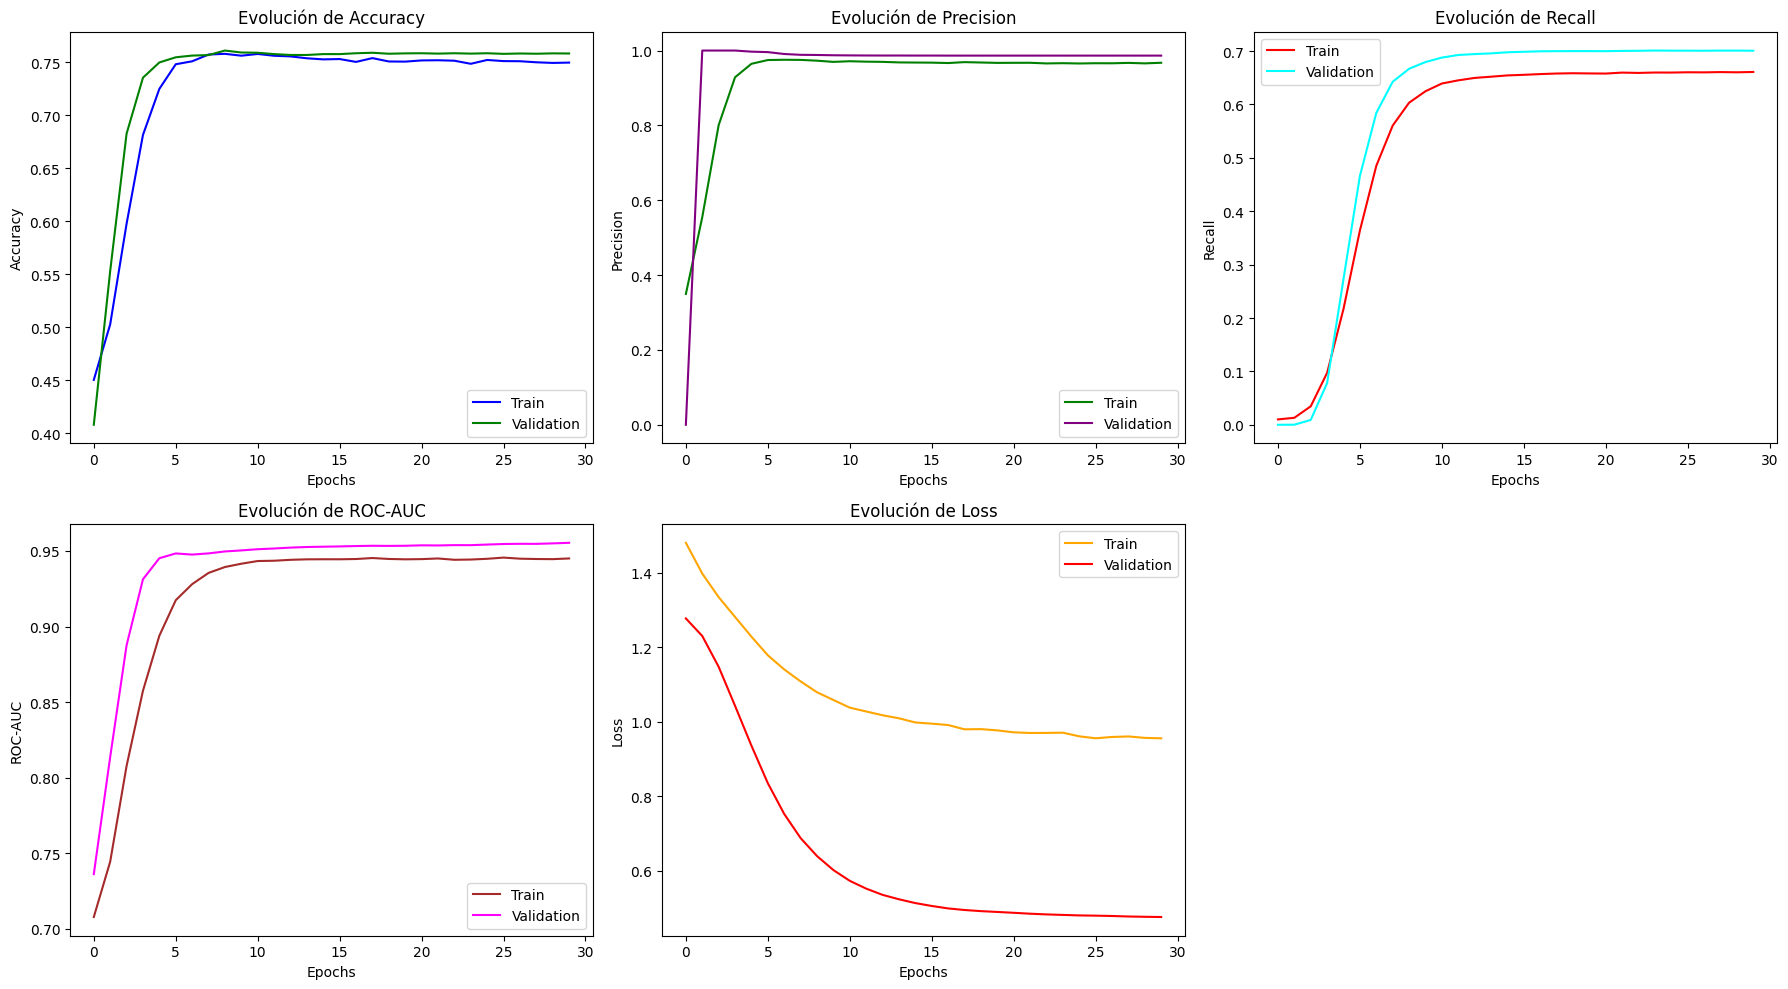

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save256, history_save256 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset1_pruebasbs_256metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12844
Porcentaje de acierto: 74.57%
Porcentaje de fallo: 25.43%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7457288222833726,
 'f1_score': 0.7208666449339391,
 'precision': 0.7946674447096952,
 'recall': 0.7457288222833726,
 'confusion_matrix': array([[   33,  4827,  1265,  2523],
        [    7,  1938,    54,   524],
        [   27,  1161, 33975,   476],
        [    2,  1965,    13,  1723]]),
 'auc': None}

Epoch 1/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4524 - loss: 1.5024 - precision: 0.3974 - recall: 0.0133 - roc_auc: 0.7097 - val_accuracy: 0.5091 - val_loss: 1.2441 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7914
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5662 - loss: 1.3620 - precision: 0.7024 - recall: 0.0284 - roc_auc: 0.7879 - val_accuracy: 0.7217 - val_loss: 1.0864 - val_precision: 1.0000 - val_recall: 0.0409 - val_roc_auc: 0.9152
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7027 - loss: 1.2651 - precision: 0.9358 - recall: 0.1571 - roc_auc: 0.8780 - val_accuracy: 0.7521 - val_loss: 0.8906 - val_precision: 0.9956 - val_recall: 0.3679 - val_roc_auc: 0.9477
Epoch 4/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7468 - loss: 1.1834 - precision: 0.9691 - recall: 0.4120 - roc_auc: 0.9187 - val_accuracy: 0.7566 - val_loss: 0.7365 - val_precision: 0.9903 - val_recall: 0.6012 - val_roc_auc:

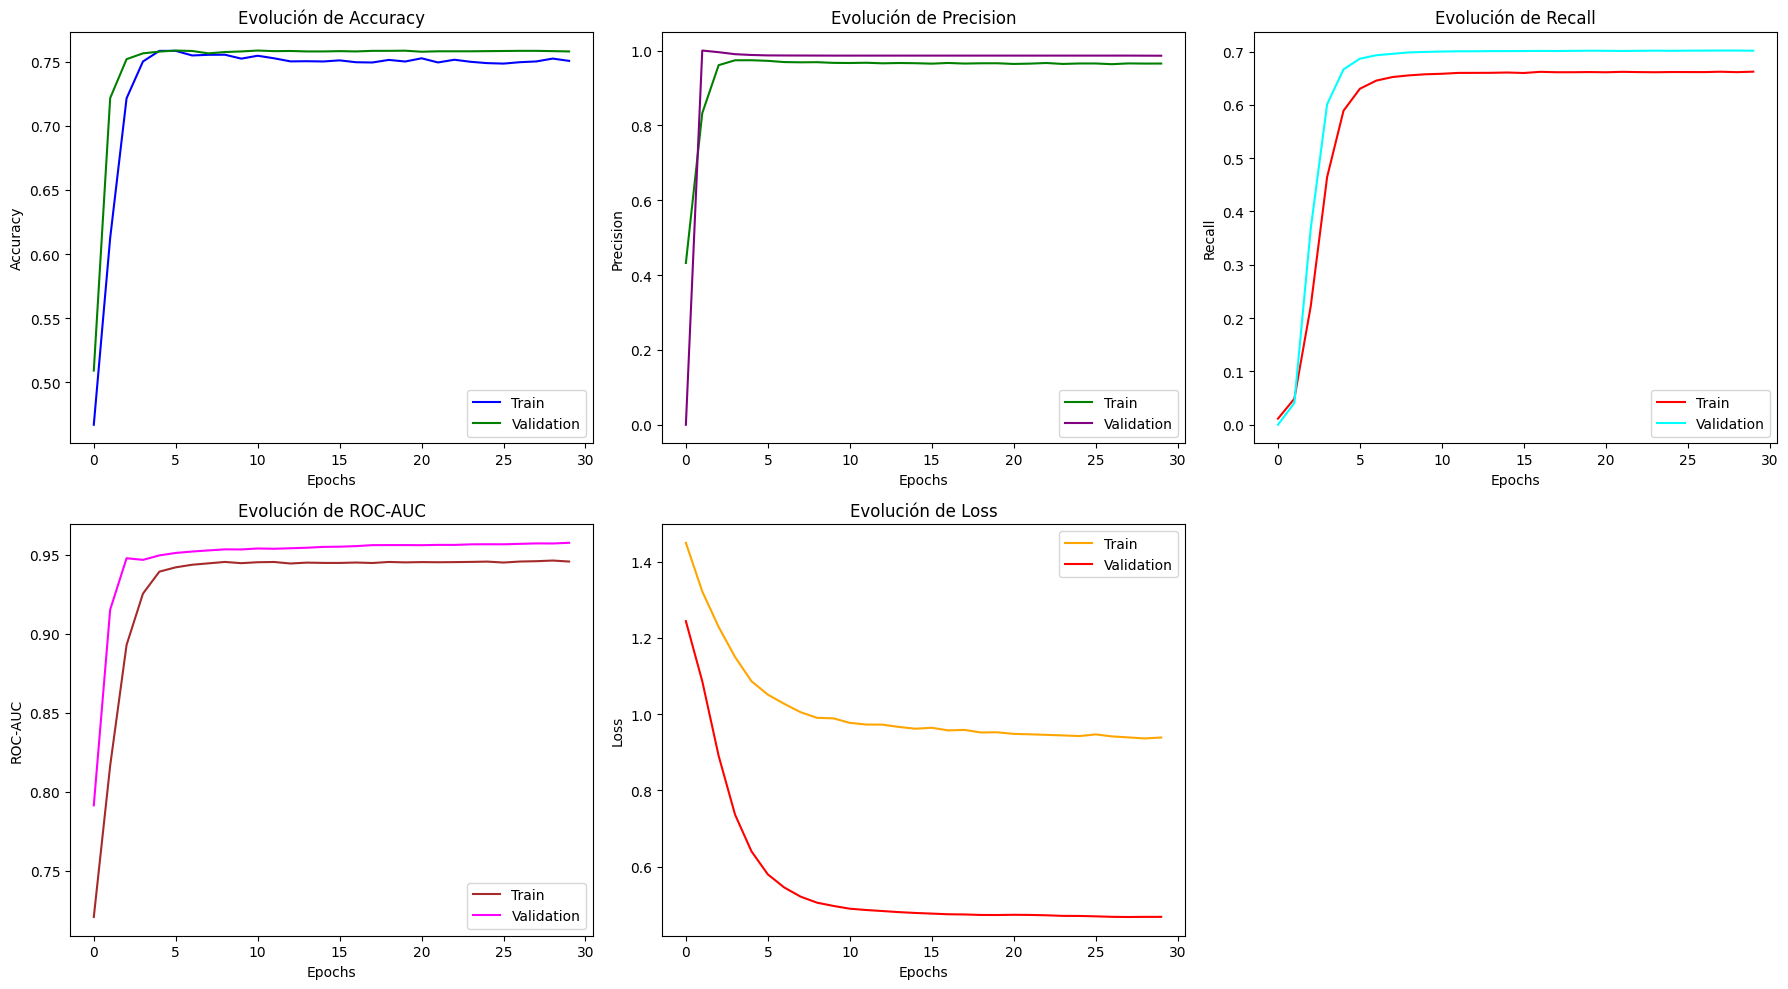

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save128, history_save128 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset1_pruebasbs_128metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save128, X_test, y_test)
GetMetrics(model_save128, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12661
Porcentaje de acierto: 74.94%
Porcentaje de fallo: 25.06%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7493516520499673,
 'f1_score': 0.729294223058025,
 'precision': 0.7968795837584464,
 'recall': 0.7493516520499673,
 'confusion_matrix': array([[  215,  4731,  1141,  2561],
        [   24,  1926,    43,   530],
        [  205,   977, 33970,   487],
        [    9,  1943,    10,  1741]]),
 'auc': None}

Epoch 1/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4748 - loss: 1.4719 - precision: 0.3976 - recall: 0.0125 - roc_auc: 0.7248 - val_accuracy: 0.6968 - val_loss: 1.1286 - val_precision: 1.0000 - val_recall: 0.0163 - val_roc_auc: 0.8954
Epoch 2/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6963 - loss: 1.2638 - precision: 0.9384 - recall: 0.1530 - roc_auc: 0.8730 - val_accuracy: 0.7547 - val_loss: 0.8135 - val_precision: 0.9961 - val_recall: 0.5014 - val_roc_auc: 0.9468
Epoch 3/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7478 - loss: 1.1405 - precision: 0.9744 - recall: 0.5255 - roc_auc: 0.9294 - val_accuracy: 0.7580 - val_loss: 0.6240 - val_precision: 0.9877 - val_recall: 0.6718 - val_roc_auc: 0.9499
Epoch 4/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7554 - loss: 1.0628 - precision: 0.9680 - recall: 0.6273 - roc_auc: 0.9412 - val_accuracy: 0.7580 - val_loss: 0.5443 - val_precision: 0.9868 - val_recall: 0.6934 - val_roc_auc: 0.9522


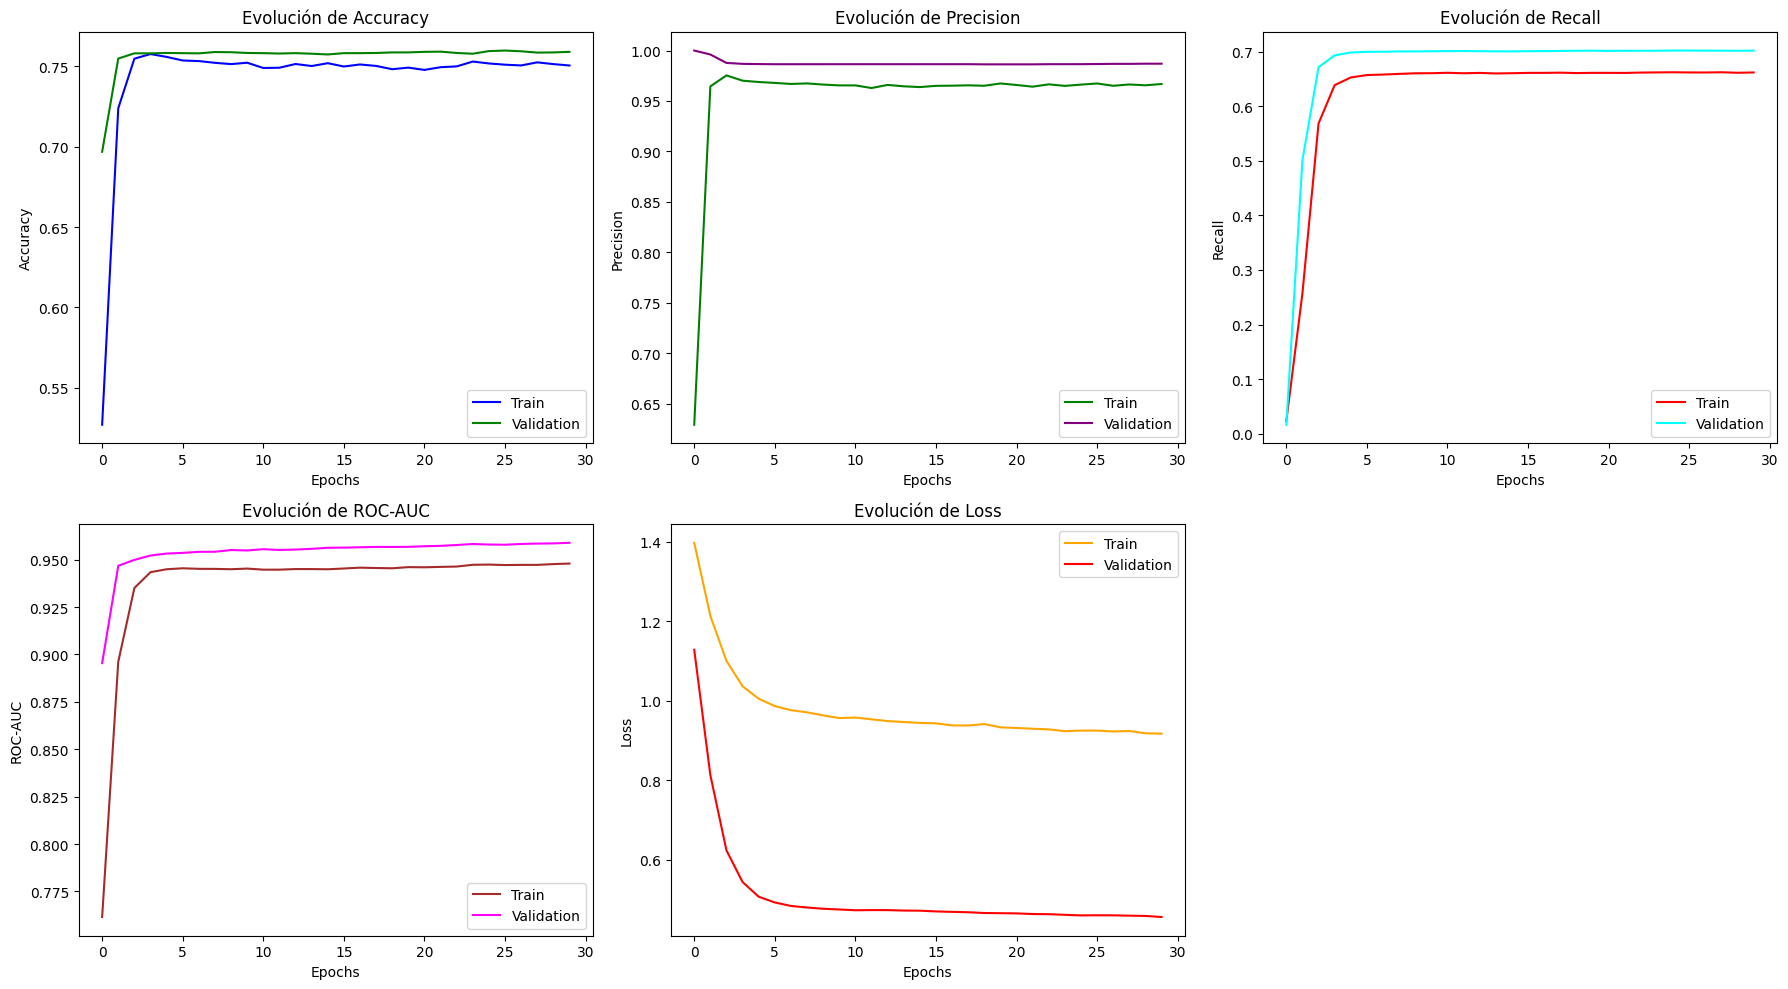

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save64, history_save64 = RNN(X_seq, y_seq, MODELOS+"18_10_RNNDataset1_pruebasbs_64metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12192
Porcentaje de acierto: 75.86%
Porcentaje de fallo: 24.14%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7586363906321145,
 'f1_score': 0.7440693974456106,
 'precision': 0.8175804564486586,
 'recall': 0.7586363906321145,
 'confusion_matrix': array([[  522,  4299,   926,  2901],
        [   42,  1858,    31,   592],
        [  323,   694, 34048,   574],
        [   30,  1771,     9,  1893]]),
 'auc': None}

Epoch 1/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2795 - loss: 1.3836 - precision: 0.6178 - recall: 0.0286 - roc_auc: 0.6250 - val_accuracy: 0.7538 - val_loss: 0.8481 - val_precision: 1.0000 - val_recall: 0.4544 - val_roc_auc: 0.9289
Epoch 2/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7263 - loss: 1.1863 - precision: 0.9941 - recall: 0.4953 - roc_auc: 0.9158 - val_accuracy: 0.7567 - val_loss: 0.5869 - val_precision: 0.9883 - val_recall: 0.6969 - val_roc_auc: 0.9594
Epoch 3/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7390 - loss: 1.0888 - precision: 0.9829 - recall: 0.6435 - roc_auc: 0.9426 - val_accuracy: 0.7569 - val_loss: 0.4940 - val_precision: 0.9871 - val_recall: 0.7026 - val_roc_auc: 0.9642
Epoch 4/30
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7537 - loss: 1.0417 - precision: 0.9778 - recall: 0.6533 - roc_auc: 0.9476 - val_accuracy: 0.7563 - val_loss: 0.4646 - val_precision: 0.9867 - val_recall: 0.7022 - val_roc_auc: 0.9643


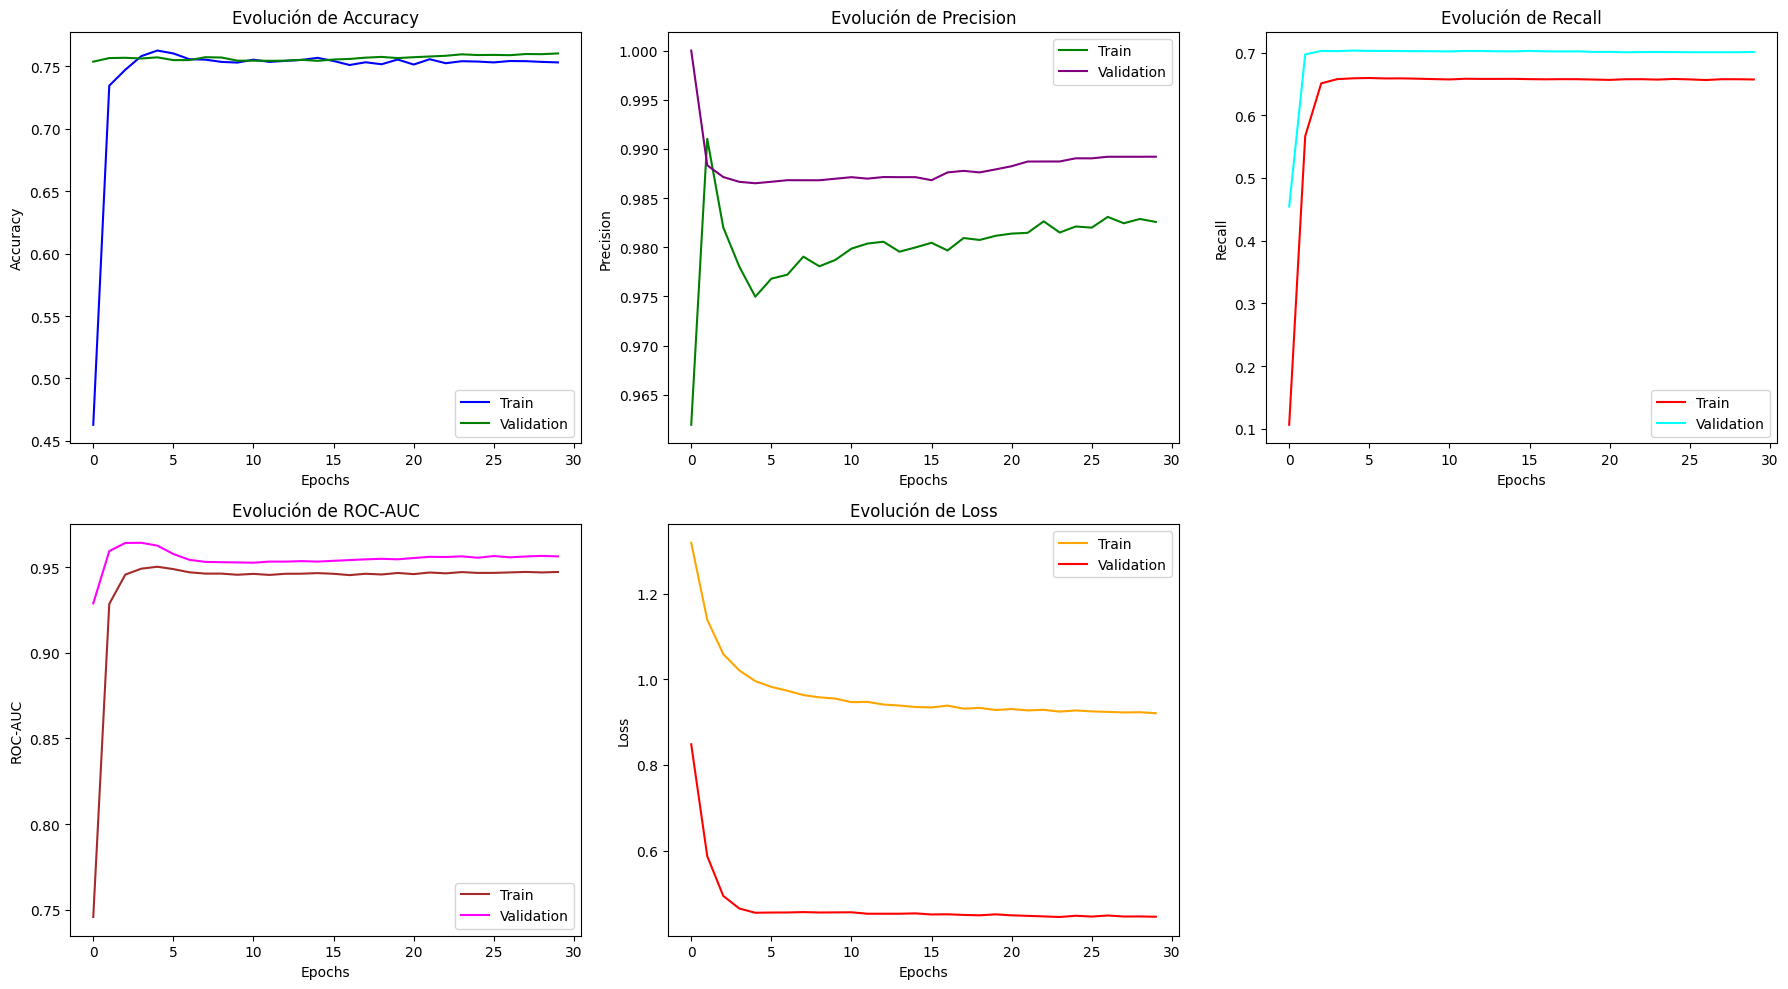

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save32, history_save32 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset1_pruebasbs_32metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 11857
Porcentaje de acierto: 76.53%
Porcentaje de fallo: 23.47%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7652683467622197,
 'f1_score': 0.7641946487253134,
 'precision': 0.8294083806536556,
 'recall': 0.7652683467622197,
 'confusion_matrix': array([[ 1221,  4695,   709,  2023],
        [  105,  1940,    29,   449],
        [  585,   659, 34015,   380],
        [  103,  2105,    15,  1480]]),
 'auc': None}

## RNN: tamaño de ventana 10

In [ ]:
X, Y = preprocessing(DATASET1)

   RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2             66      7        80          80
3             77     62        80         130
4             15      0        80         112
5             63     26        64         131
6            106     95        64         125
0: 4
1: 5
2: 7
3: 8


Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2022 - loss: 1.3613 - precision: 0.2498 - recall: 0.0023 - roc_auc: 0.4372 - val_accuracy: 0.5458 - val_loss: 1.3003 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7305
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4096 - loss: 1.3112 - precision: 0.7292 - recall: 0.0057 - roc_auc: 0.6503 - val_accuracy: 0.7446 - val_loss: 1.1264 - val_precision: 1.0000 - val_recall: 0.0036 - val_roc_auc: 0.9111
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5801 - loss: 1.2495 - precision: 0.9689 - recall: 0.0420 - roc_auc: 0.7941 - val_accuracy: 0.7563 - val_loss: 0.9915 - val_precision: 1.0000 - val_recall: 0.1066 - val_roc_auc: 0.9325
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6723 - loss: 1.1954 - precision: 0.9839 - recall: 0.1520 - roc_auc: 0.8610 - val_accuracy: 0.7587 - val_loss: 0.8675 - val_precision: 0.9964 - val_recall: 0.4487 - val_roc_auc

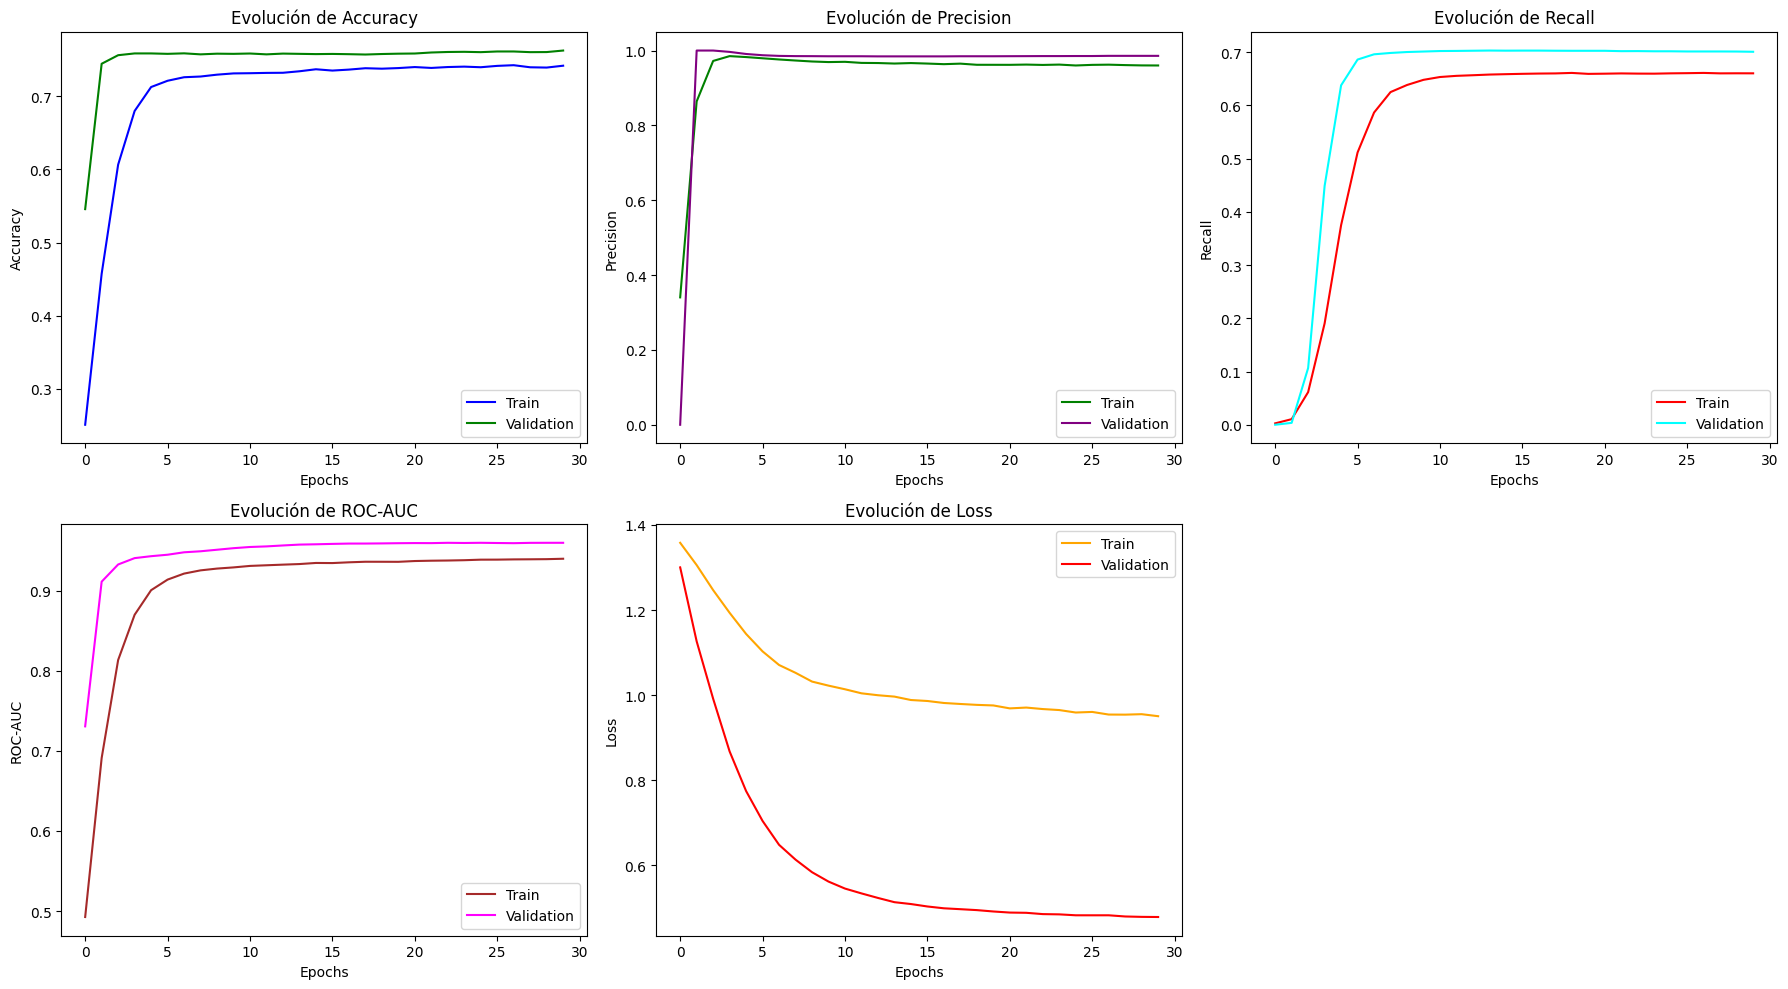

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save256, history_save256 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset1_pruebasbs_256metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12259
Porcentaje de acierto: 75.73%
Porcentaje de fallo: 24.27%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7572859744990893,
 'f1_score': 0.7487844264075929,
 'precision': 0.8165184755719594,
 'recall': 0.7572859744990893,
 'confusion_matrix': array([[  784,  3400,   880,  3584],
        [  178,  1503,    68,   774],
        [  155,   914, 33809,   756],
        [  250,  1288,    12,  2153]]),
 'auc': None}

Epoch 1/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4507 - loss: 1.4359 - precision: 0.2413 - recall: 1.6847e-04 - roc_auc: 0.7081 - val_accuracy: 0.3499 - val_loss: 1.3130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7491
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3804 - loss: 1.3580 - precision: 0.3910 - recall: 2.2391e-04 - roc_auc: 0.6957 - val_accuracy: 0.3589 - val_loss: 1.2795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7658
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4709 - loss: 1.3197 - precision: 0.8727 - recall: 0.0034 - roc_auc: 0.7680 - val_accuracy: 0.7269 - val_loss: 1.1233 - val_precision: 1.0000 - val_recall: 0.0028 - val_roc_auc: 0.9113
Epoch 4/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6820 - loss: 1.2522 - precision: 0.9989 - recall: 0.1019 - roc_auc: 0.8799 - val_accuracy: 0.8505 - val_loss: 0.8002 - val_precision: 0.9989 - val_recall: 0.51

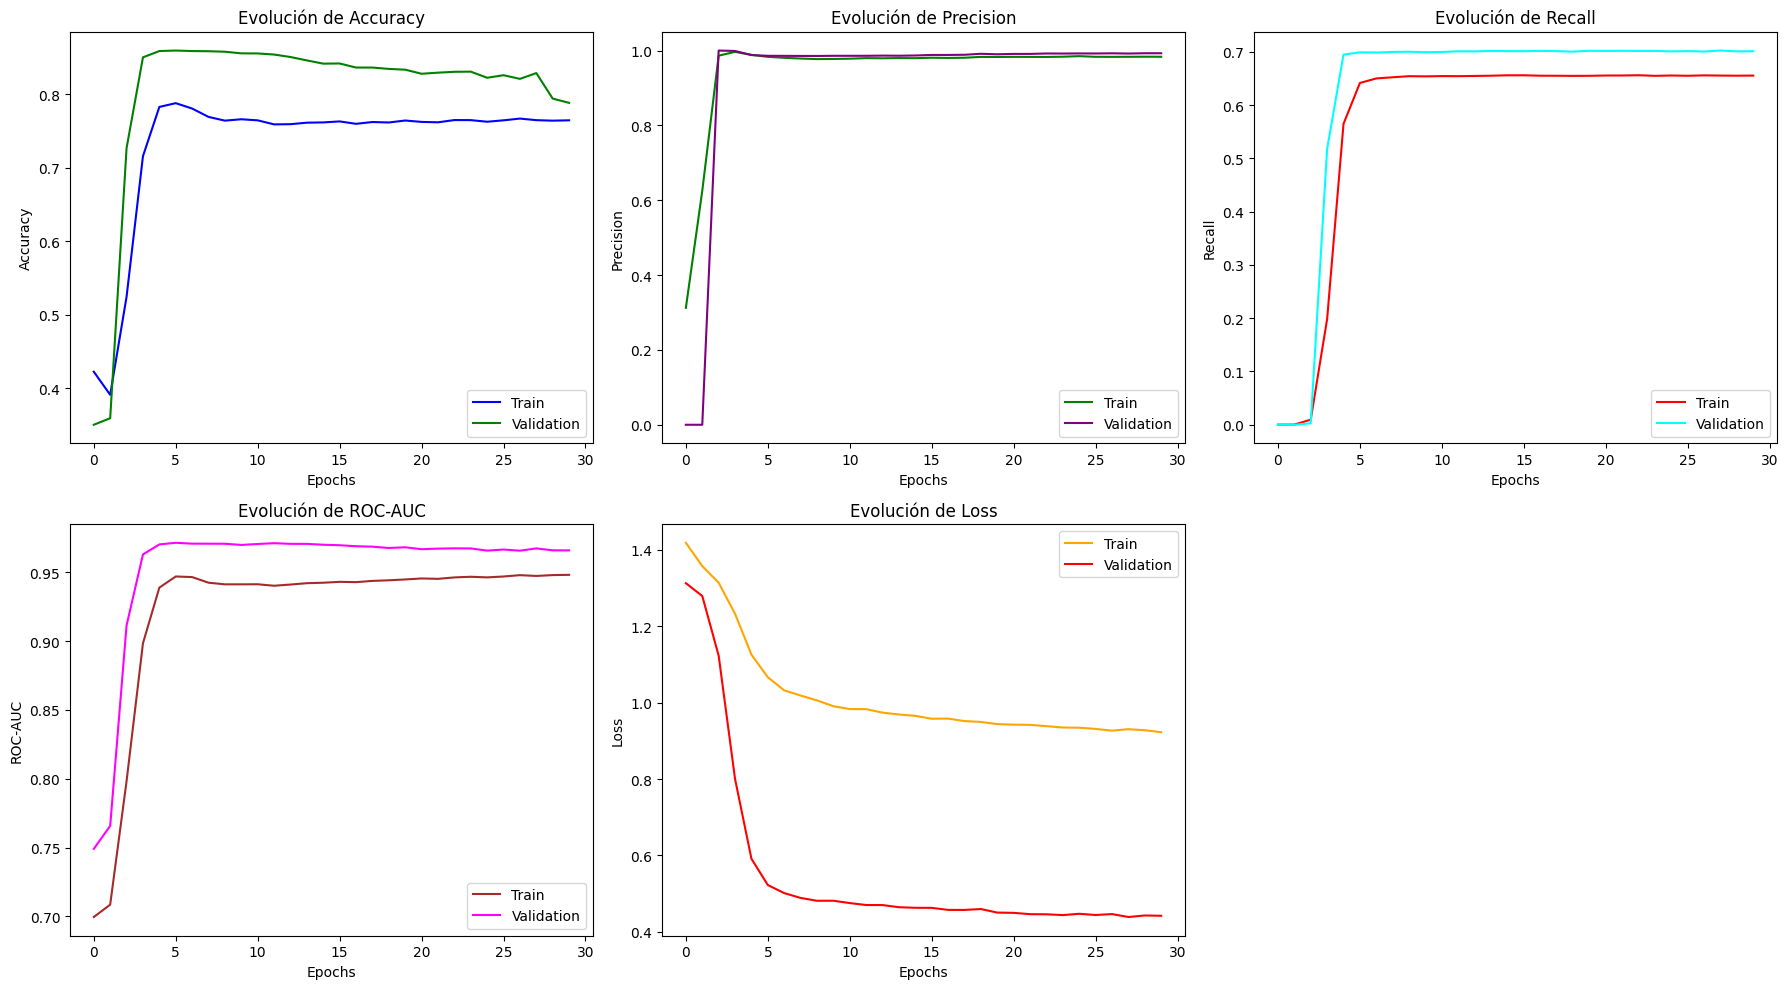

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y)
model_save128, history_save128 = RNN(X_seq, y_seq, MODELOS+"18_10_RNNDataset1_pruebasbs_128metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save128, X_test, y_test)
GetMetrics(model_save128, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 10249
Porcentaje de acierto: 79.71%
Porcentaje de fallo: 20.29%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7970816504316148,
 'f1_score': 0.7898596439077691,
 'precision': 0.7995294019001188,
 'recall': 0.7970816504316148,
 'confusion_matrix': array([[ 4491,  2970,   922,   265],
        [  885,  1569,    56,    13],
        [ 1017,   384, 34101,   132],
        [ 2380,  1176,    49,    98]]),
 'auc': None}

Epoch 1/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2677 - loss: 1.3907 - precision: 0.2414 - recall: 0.0056 - roc_auc: 0.5729 - val_accuracy: 0.7447 - val_loss: 1.0681 - val_precision: 1.0000 - val_recall: 0.0969 - val_roc_auc: 0.9149
Epoch 2/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6873 - loss: 1.2350 - precision: 0.9880 - recall: 0.2741 - roc_auc: 0.8766 - val_accuracy: 0.7552 - val_loss: 0.6615 - val_precision: 0.9895 - val_recall: 0.6856 - val_roc_auc: 0.9619
Epoch 3/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7466 - loss: 1.1162 - precision: 0.9807 - recall: 0.6309 - roc_auc: 0.9367 - val_accuracy: 0.7549 - val_loss: 0.5548 - val_precision: 0.9874 - val_recall: 0.6991 - val_roc_auc: 0.9629
Epoch 4/30
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7430 - loss: 1.0746 - precision: 0.9739 - recall: 0.6546 - roc_auc: 0.9435 - val_accuracy: 0.7535 - val_loss: 0.5144 - val_precision: 0.9872 - val_recall: 0.6990 - val_roc_auc: 0.9629


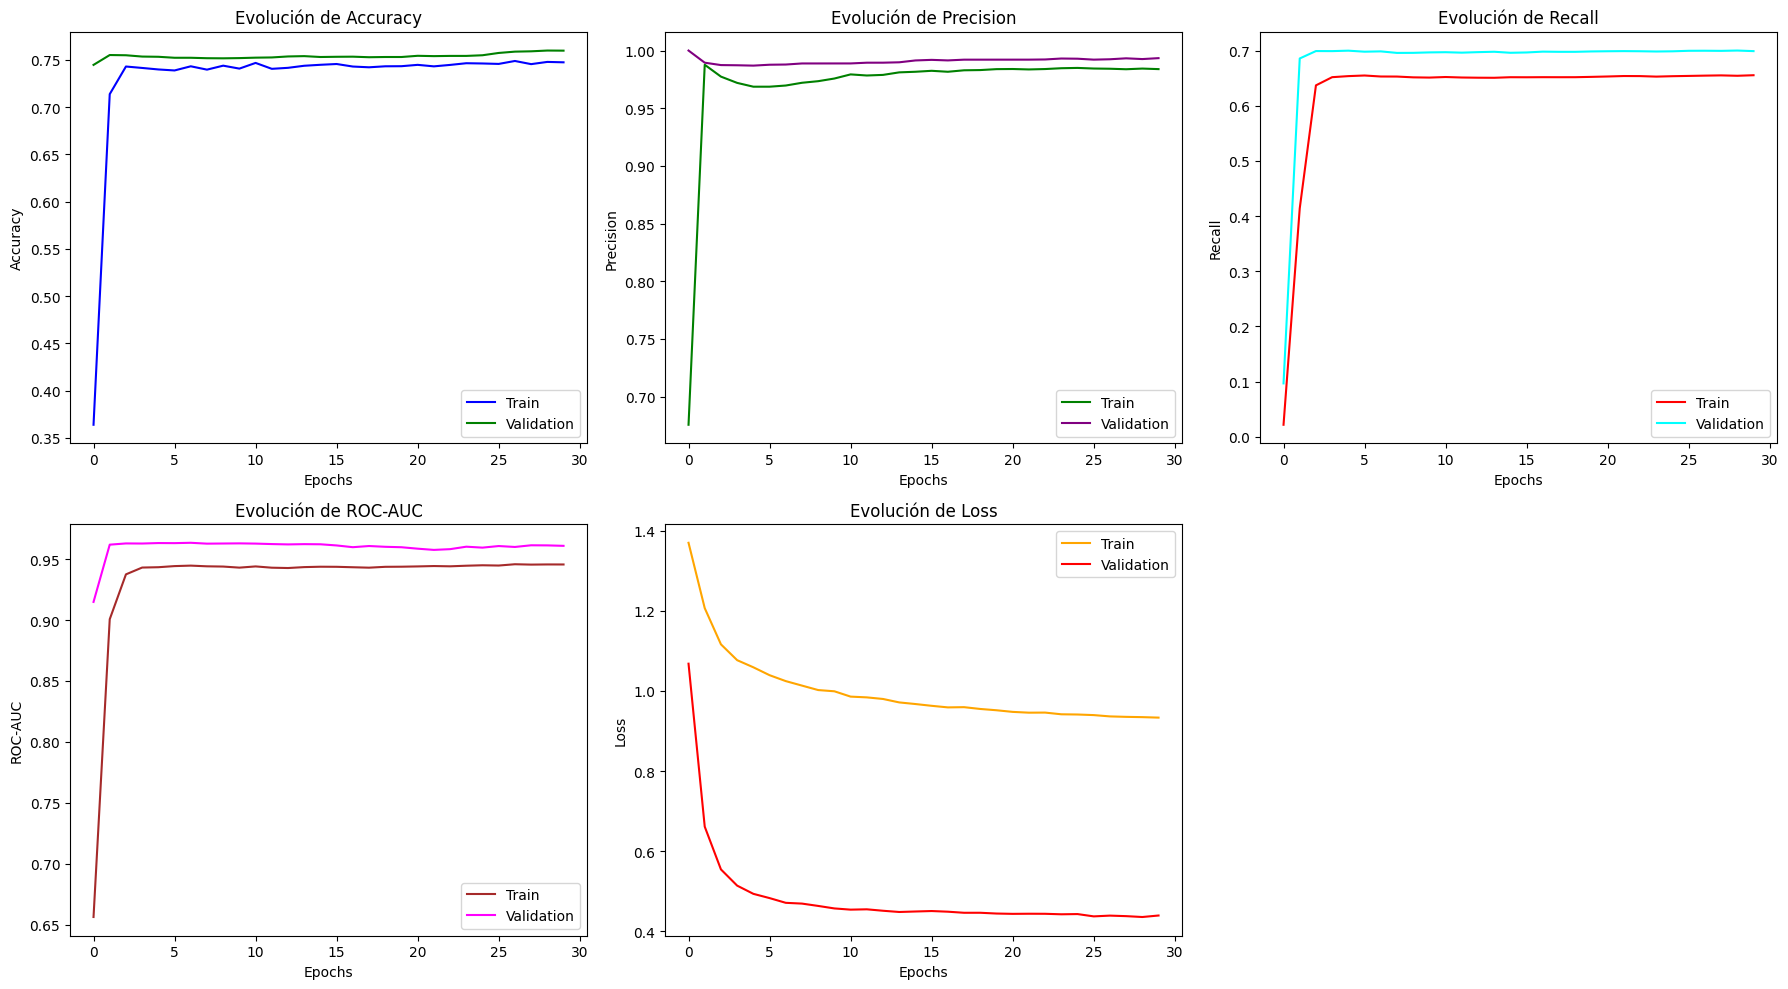

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y)
model_save64, history_save64 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset1_pruebasbs_64metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 11809
Porcentaje de acierto: 76.62%
Porcentaje de fallo: 23.38%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


{'accuracy': 0.7661954541854755,
 'f1_score': 0.7594541128350683,
 'precision': 0.8268905083601703,
 'recall': 0.7661954541854755,
 'confusion_matrix': array([[ 1094,  1880,   533,  5141],
        [   97,   574,    19,  1833],
        [  542,   347, 33904,   841],
        [   83,   486,     7,  3127]]),
 'auc': None}

Epoch 1/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5254 - loss: 1.3240 - precision: 0.5601 - recall: 0.0016 - roc_auc: 0.7524 - val_accuracy: 0.7466 - val_loss: 1.0512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.9301
Epoch 2/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7161 - loss: 1.1671 - precision: 0.9676 - recall: 0.0691 - roc_auc: 0.8756 - val_accuracy: 0.7545 - val_loss: 0.8822 - val_precision: 0.9963 - val_recall: 0.4647 - val_roc_auc: 0.9357
Epoch 3/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7415 - loss: 1.0895 - precision: 0.9770 - recall: 0.4533 - roc_auc: 0.9095 - val_accuracy: 0.7585 - val_loss: 0.7331 - val_precision: 0.9858 - val_recall: 0.6980 - val_roc_auc: 0.9393
Epoch 4/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7505 - loss: 1.0331 - precision: 0.9746 - recall: 0.6305 - roc_auc: 0.9217 - val_accuracy: 0.7593 - val_loss: 0.6347 - val_precision: 0.9849 - val_recall: 0.7034 - val_roc_auc

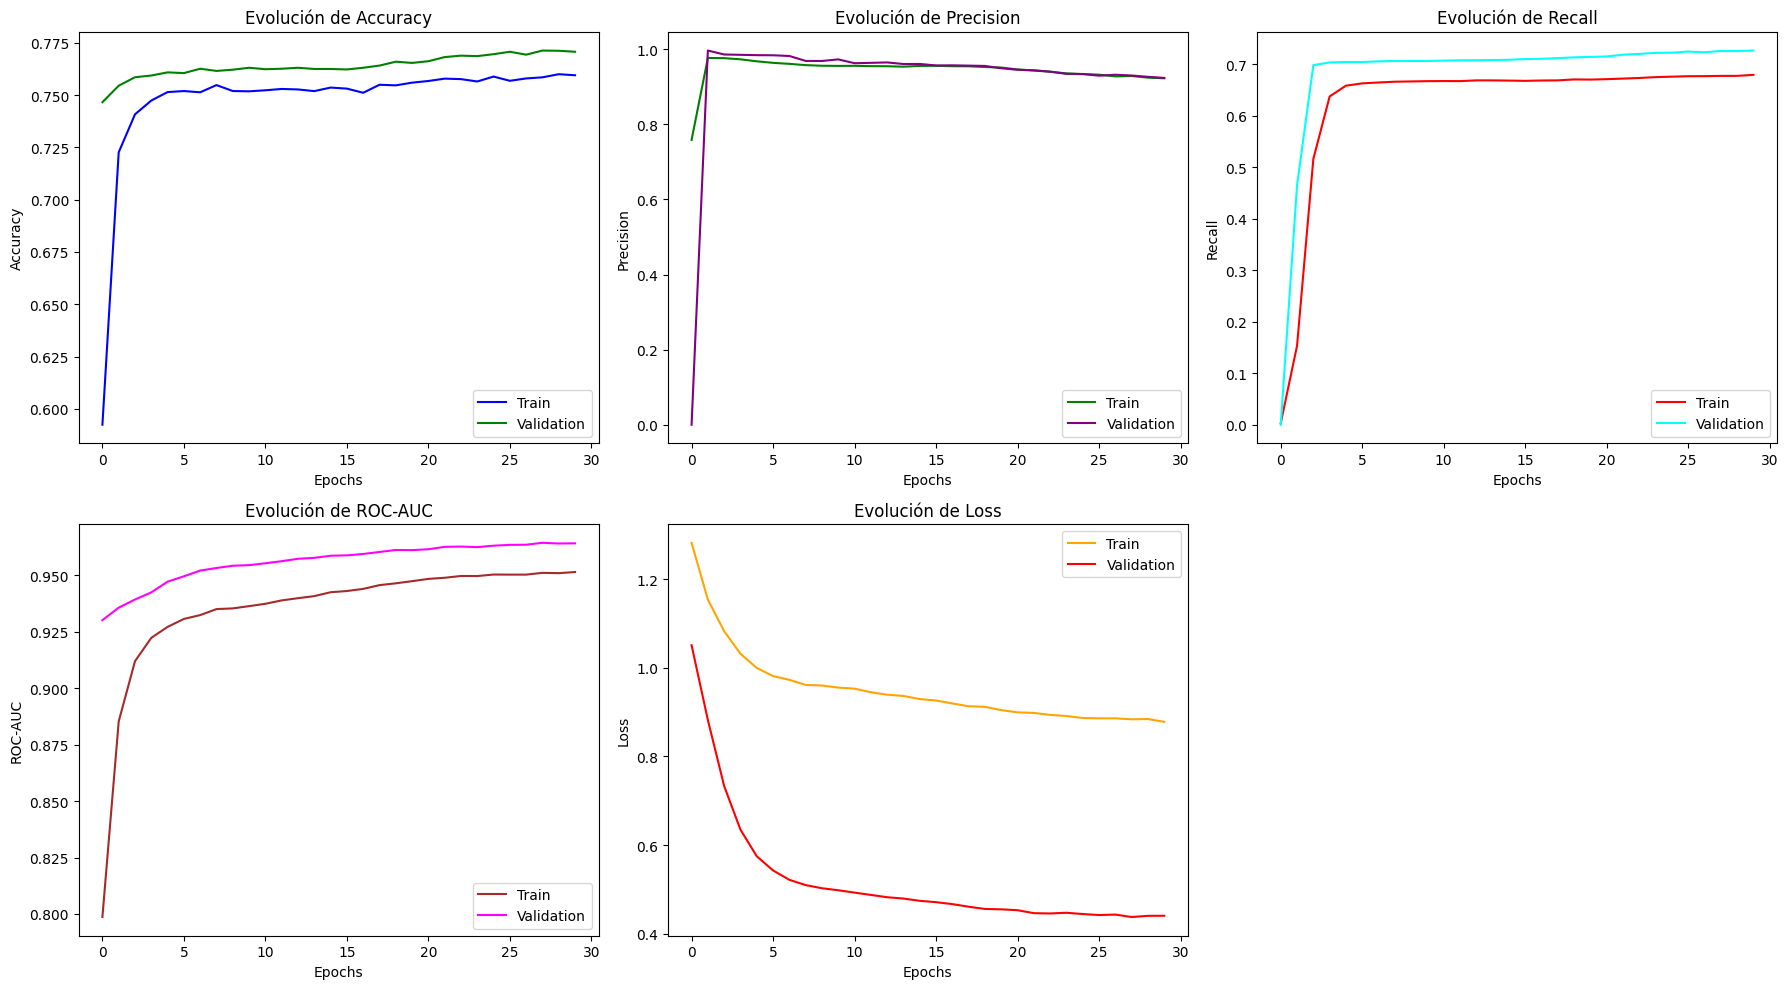

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y)
model_save32, history_save32 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset1_bs_32met_vent10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12043
Porcentaje de acierto: 76.16%
Porcentaje de fallo: 23.84%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


{'accuracy': 0.7615625247485547,
 'f1_score': 0.7363832672516331,
 'precision': 0.8286752273182049,
 'recall': 0.7615625247485547,
 'confusion_matrix': array([[  221,  3415,   970,  4042],
        [   42,  1859,    38,   584],
        [   41,   439, 34228,   926],
        [   38,  1470,    38,  2157]]),
 'auc': None}

# Entreno con Dataset 2

> Se divide el dataset 2 en entrenamiento, validación y prueba (70%, 20% y 10%).
Además, se prueban de manera independiente los modelos en el Dataset 3.





# LSTM


## LSTM: tamaño de ventana 5

In [ ]:
X, Y = preprocessing(DATASET2)

# 4:    Sueño ligero
# 5:    Sueño profundo
# 7:  Despierto
# 8:    REM

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
4              12      0        80          66
14             23      0        80          63
24             41      0        96          71
34             18      0        80          73
44             26      0        80          67
0: 4
1: 5
2: 7
3: 8


Tamaño de los conjuntos de datos:
Entrenamiento: (25917, 5, 4), Validación: (7405, 5, 4), Test: (3703, 5, 4)
Etiquetas Entrenamiento: (25917, 4), Validación: (7405, 4), Test: (3703, 4)
Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.1612 - loss: 1.3783 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5105 - val_accuracy: 0.0492 - val_loss: 1.3874 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5247
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1460 - loss: 1.3758 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5432 - val_accuracy: 0.0486 - val_loss: 1.3843 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6122
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.1391 - loss: 1.3735 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5692 - val_accuracy: 0.0535 - val_loss: 1.3808 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6483
Epoch 4/30
102

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


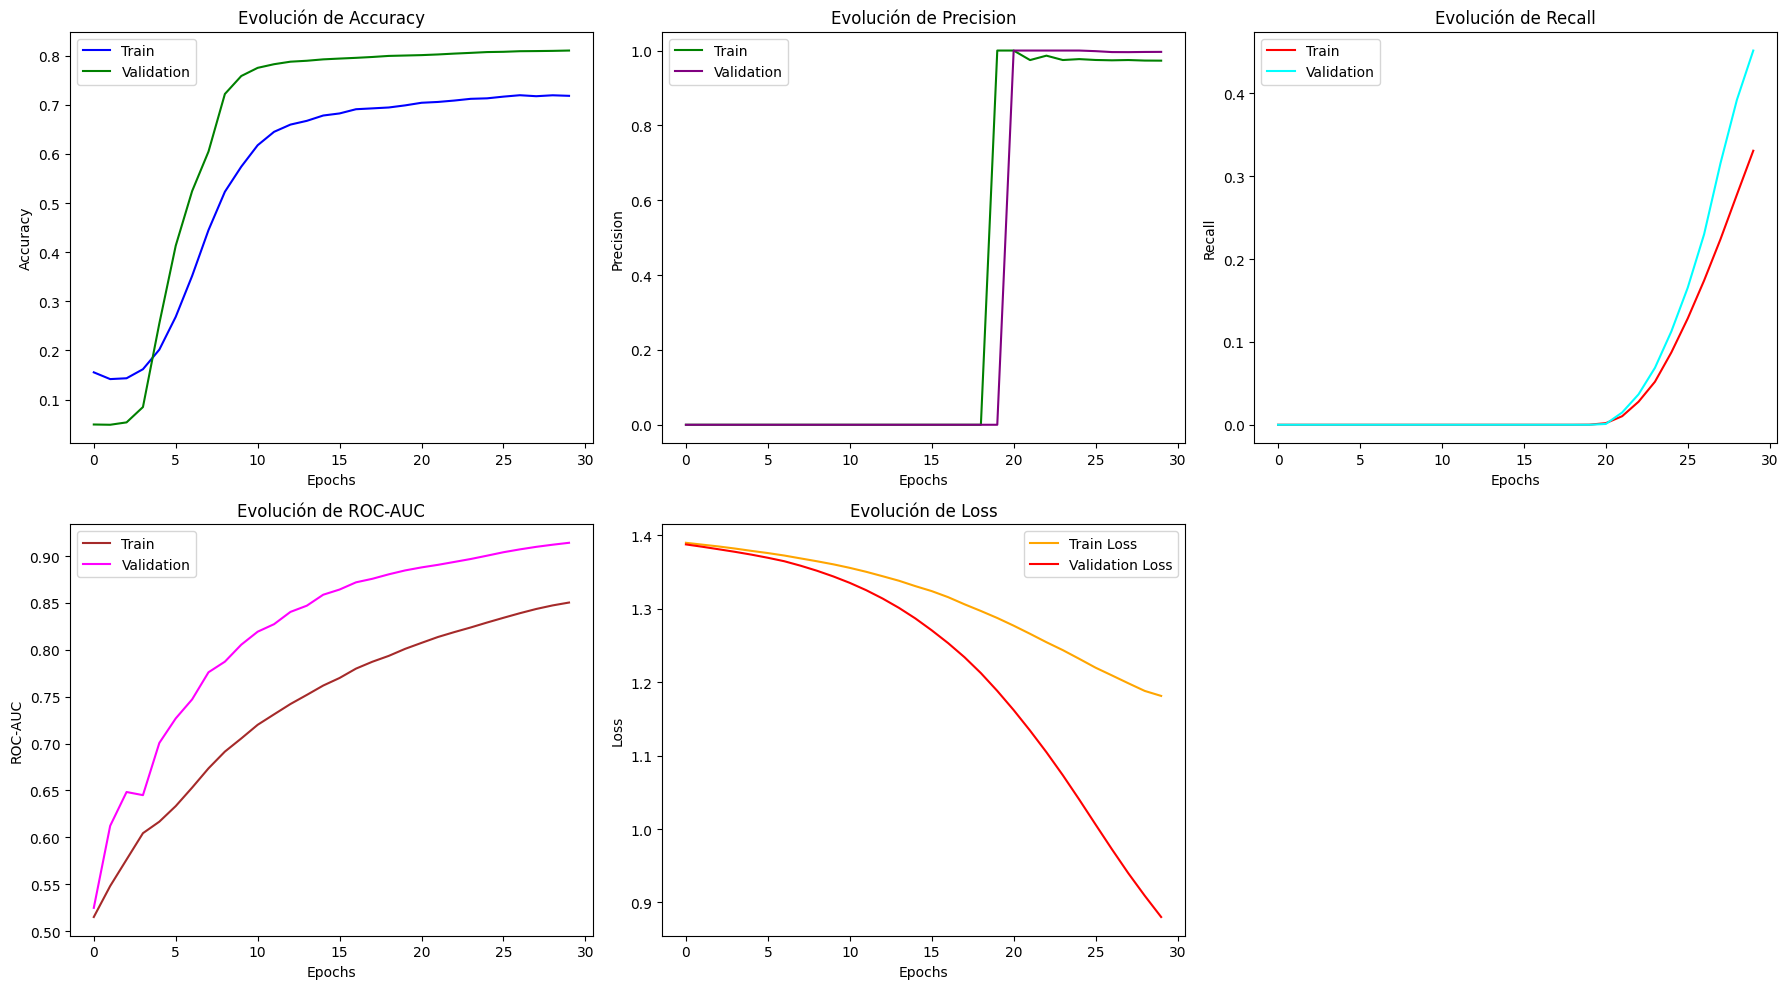

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save256, history_save256 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasmetrica256s_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 9315
Porcentaje de acierto: 81.56%
Porcentaje de fallo: 18.44%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


{'accuracy': 0.8155920258151367,
 'f1_score': 0.781455978218322,
 'precision': 0.7638867448745583,
 'recall': 0.8155920258151367,
 'confusion_matrix': array([[ 7142,     0,  1336,   170],
        [ 2410,     0,    76,    37],
        [ 1346,     0, 34037,   256],
        [ 3662,     0,    22,    19]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (25917, 5, 4), Validación: (7405, 5, 4), Test: (3703, 5, 4)
Etiquetas Entrenamiento: (25917, 4), Validación: (7405, 4), Test: (3703, 4)
Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.0965 - loss: 1.3739 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3877 - val_accuracy: 0.1049 - val_loss: 1.3899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4186
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1560 - loss: 1.3706 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4254 - val_accuracy: 0.1834 - val_loss: 1.3848 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5032
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2802 - loss: 1.3665 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5044 - val_accuracy: 0.3889 - val_loss: 1.3791 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5982
Epoch 4/30
20

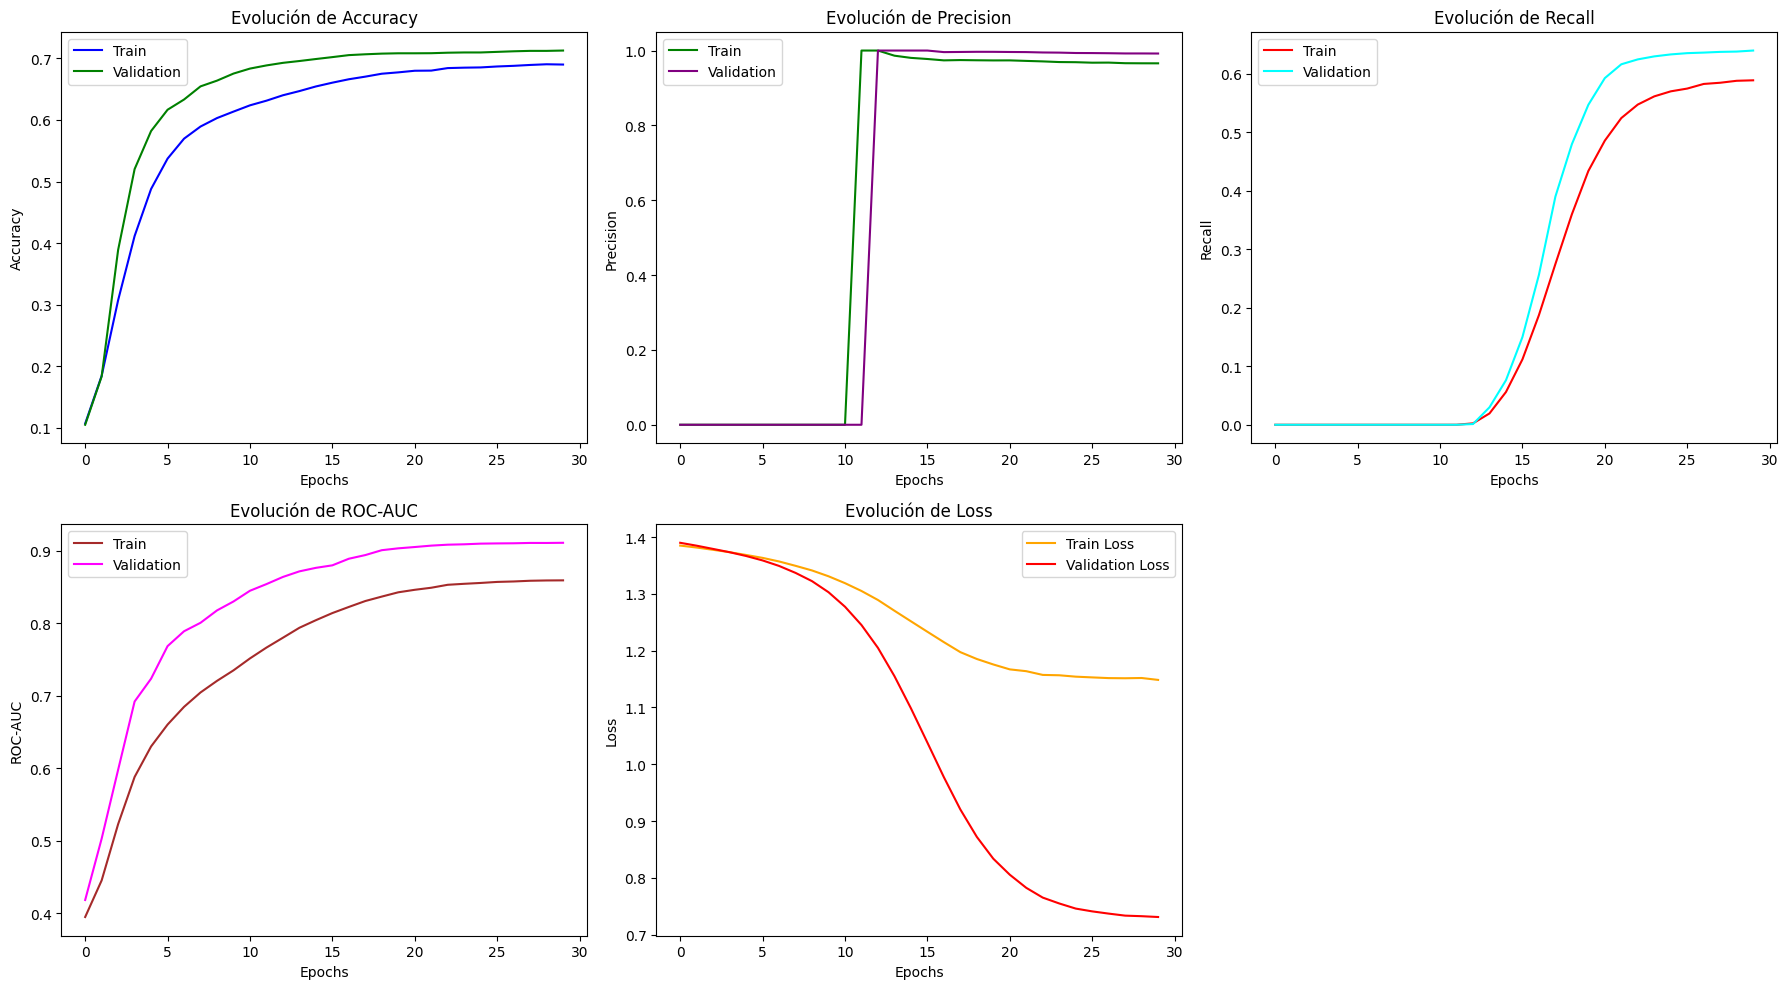

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save51, history_save51 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasmetricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save51, X_test, y_test)
GetMetrics(model_save51, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 13567
Porcentaje de acierto: 73.14%
Porcentaje de fallo: 26.86%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


{'accuracy': 0.7314156751727278,
 'f1_score': 0.7085559394277285,
 'precision': 0.7829075586813667,
 'recall': 0.7314156751727278,
 'confusion_matrix': array([[  488,  6512,  1423,   225],
        [   93,  2286,    87,    57],
        [  209,  1059, 34136,   235],
        [   94,  3544,    29,    36]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (25917, 5, 4), Validación: (7405, 5, 4), Test: (3703, 5, 4)
Etiquetas Entrenamiento: (25917, 4), Validación: (7405, 4), Test: (3703, 4)
Epoch 1/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.1101 - loss: 1.3747 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3969 - val_accuracy: 0.1596 - val_loss: 1.3864 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4623
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2588 - loss: 1.3683 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4907 - val_accuracy: 0.4357 - val_loss: 1.3769 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6545
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4314 - loss: 1.3617 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5964 - val_accuracy: 0.5874 - val_loss: 1.3653 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7302
Epoch 4/30
40

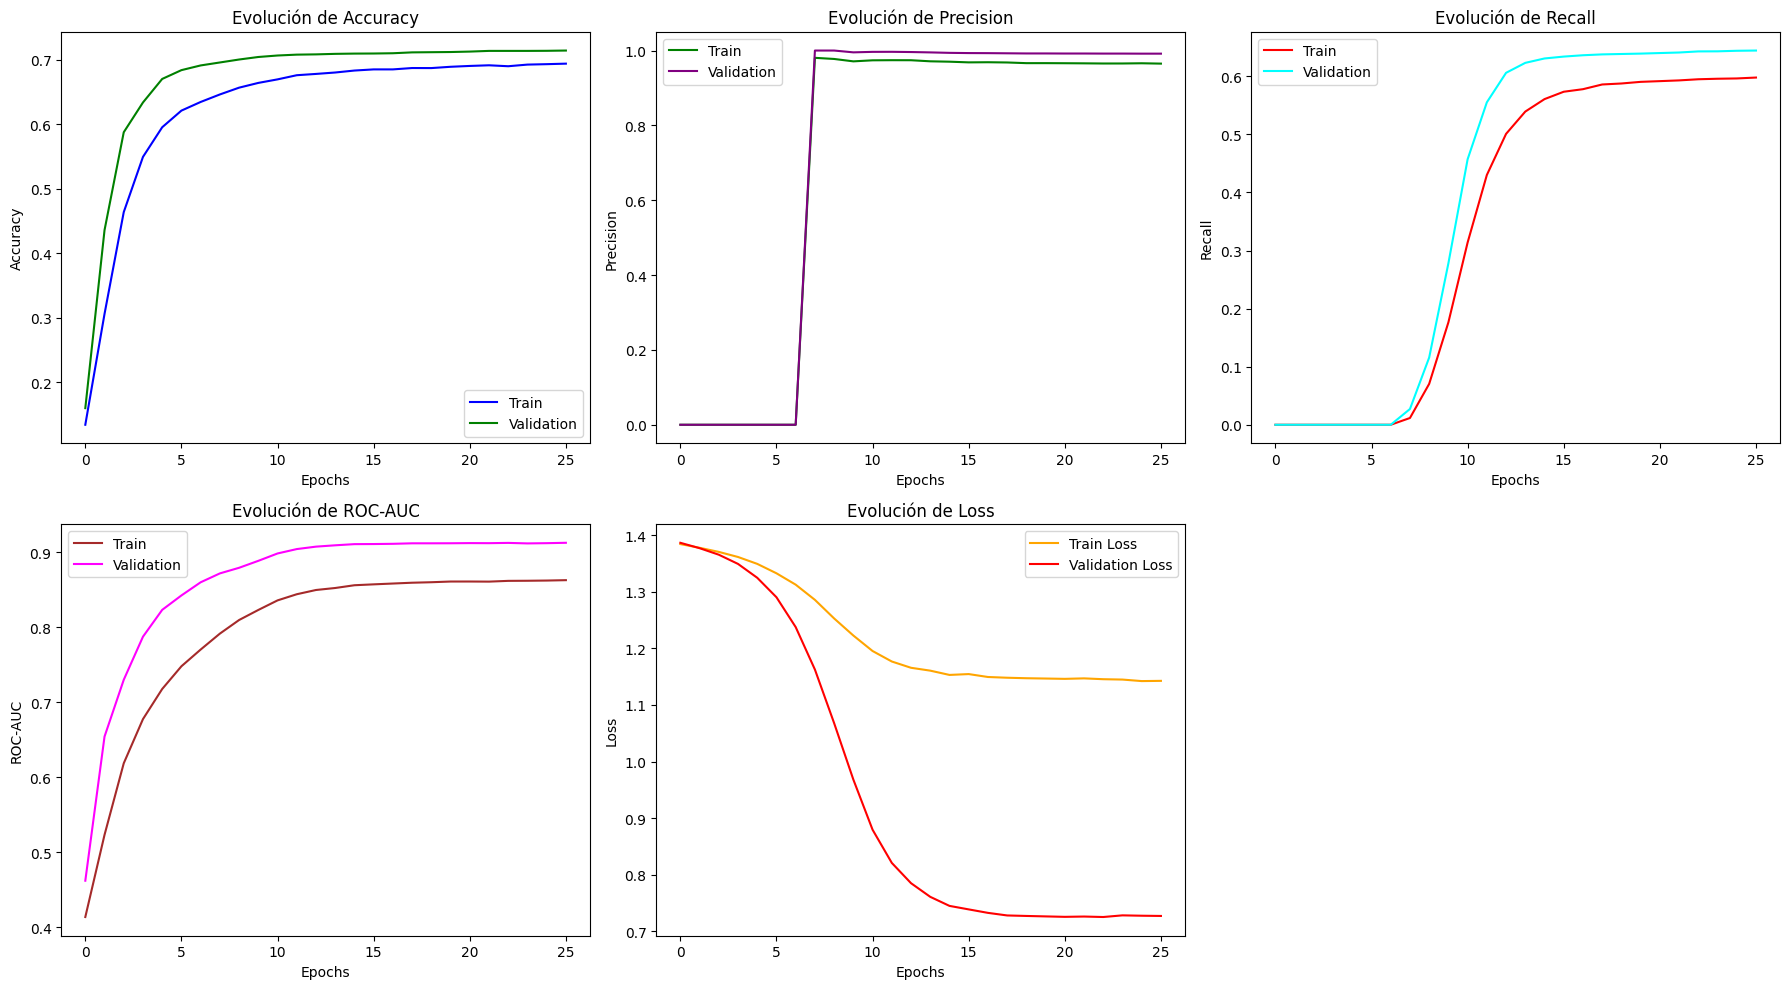

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save64, history_save64 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasbs_64metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 13525
Porcentaje de acierto: 73.22%
Porcentaje de fallo: 26.78%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


{'accuracy': 0.7322471442994872,
 'f1_score': 0.7104876923749421,
 'precision': 0.7828932941307385,
 'recall': 0.7322471442994872,
 'confusion_matrix': array([[  529,  6397,  1422,   300],
        [  115,  2257,    88,    63],
        [  205,  1012, 34152,   270],
        [  116,  3508,    29,    50]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (25917, 5, 4), Validación: (7405, 5, 4), Test: (3703, 5, 4)
Etiquetas Entrenamiento: (25917, 4), Validación: (7405, 4), Test: (3703, 4)
Epoch 1/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.1334 - loss: 1.3736 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4188 - val_accuracy: 0.3136 - val_loss: 1.3804 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5817
Epoch 2/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3898 - loss: 1.3635 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5828 - val_accuracy: 0.6027 - val_loss: 1.3606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7556
Epoch 3/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5589 - loss: 1.3499 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6897 - val_accuracy: 0.6648 - val_loss: 1.3255 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8239
Epoch 4/30
8

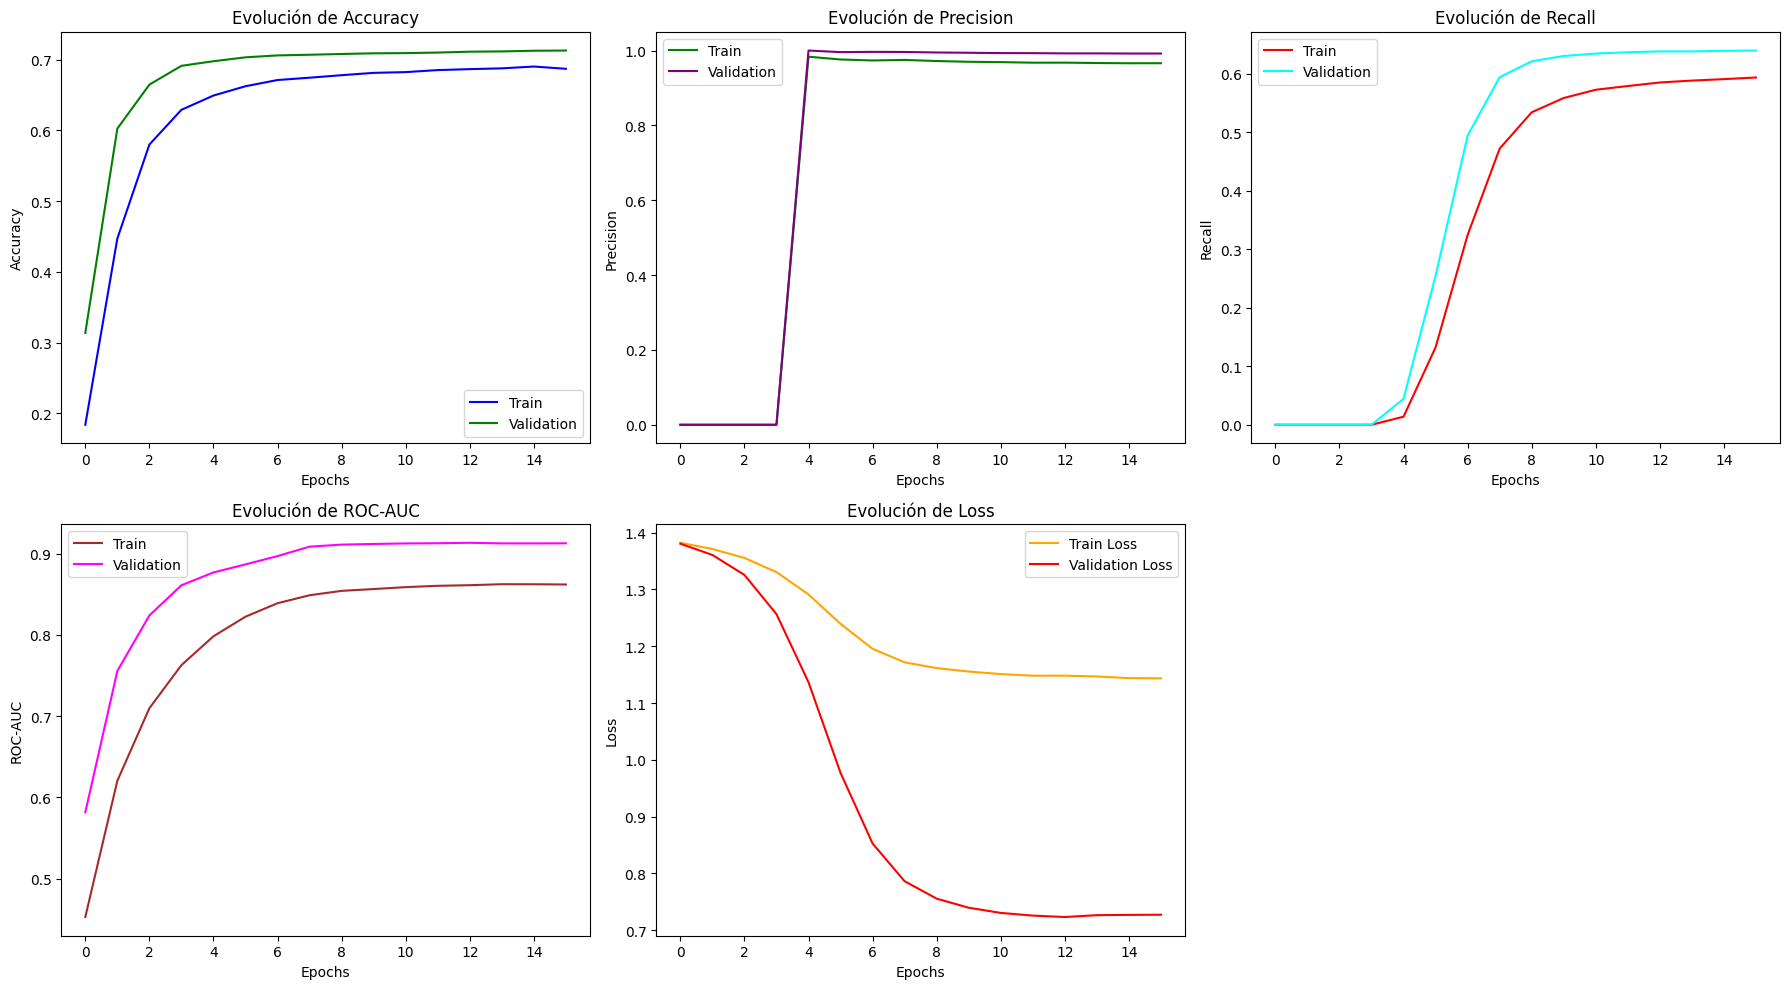

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save32, history_save32 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasbs_32metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 13645
Porcentaje de acierto: 72.99%
Porcentaje de fallo: 27.01%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


{'accuracy': 0.7298715182230316,
 'f1_score': 0.7055641598221936,
 'precision': 0.7825775909416076,
 'recall': 0.7298715182230316,
 'confusion_matrix': array([[  376,  6562,  1395,   315],
        [   80,  2293,    86,    64],
        [  156,  1065, 34152,   266],
        [   77,  3550,    29,    47]]),
 'auc': None}

## LSTM: tamaño de ventana 10

In [ ]:
X, Y = preprocessing(DATASET2)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
4              12      0        80          66
14             23      0        80          63
24             41      0        96          71
34             18      0        80          73
44             26      0        80          67
0: 4
1: 5
2: 7
3: 8


Tamaño de los conjuntos de datos:
Entrenamiento: (25914, 10, 4), Validación: (7404, 10, 4), Test: (3702, 10, 4)
Etiquetas Entrenamiento: (25914, 4), Validación: (7404, 4), Test: (3702, 4)
Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.0913 - loss: 1.3642 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3738 - val_accuracy: 0.0486 - val_loss: 1.3952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3664
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1125 - loss: 1.3599 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3827 - val_accuracy: 0.0983 - val_loss: 1.3927 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3925
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.1587 - loss: 1.3564 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4108 - val_accuracy: 0.1977 - val_loss: 1.3877 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4374
Epoch 4/30

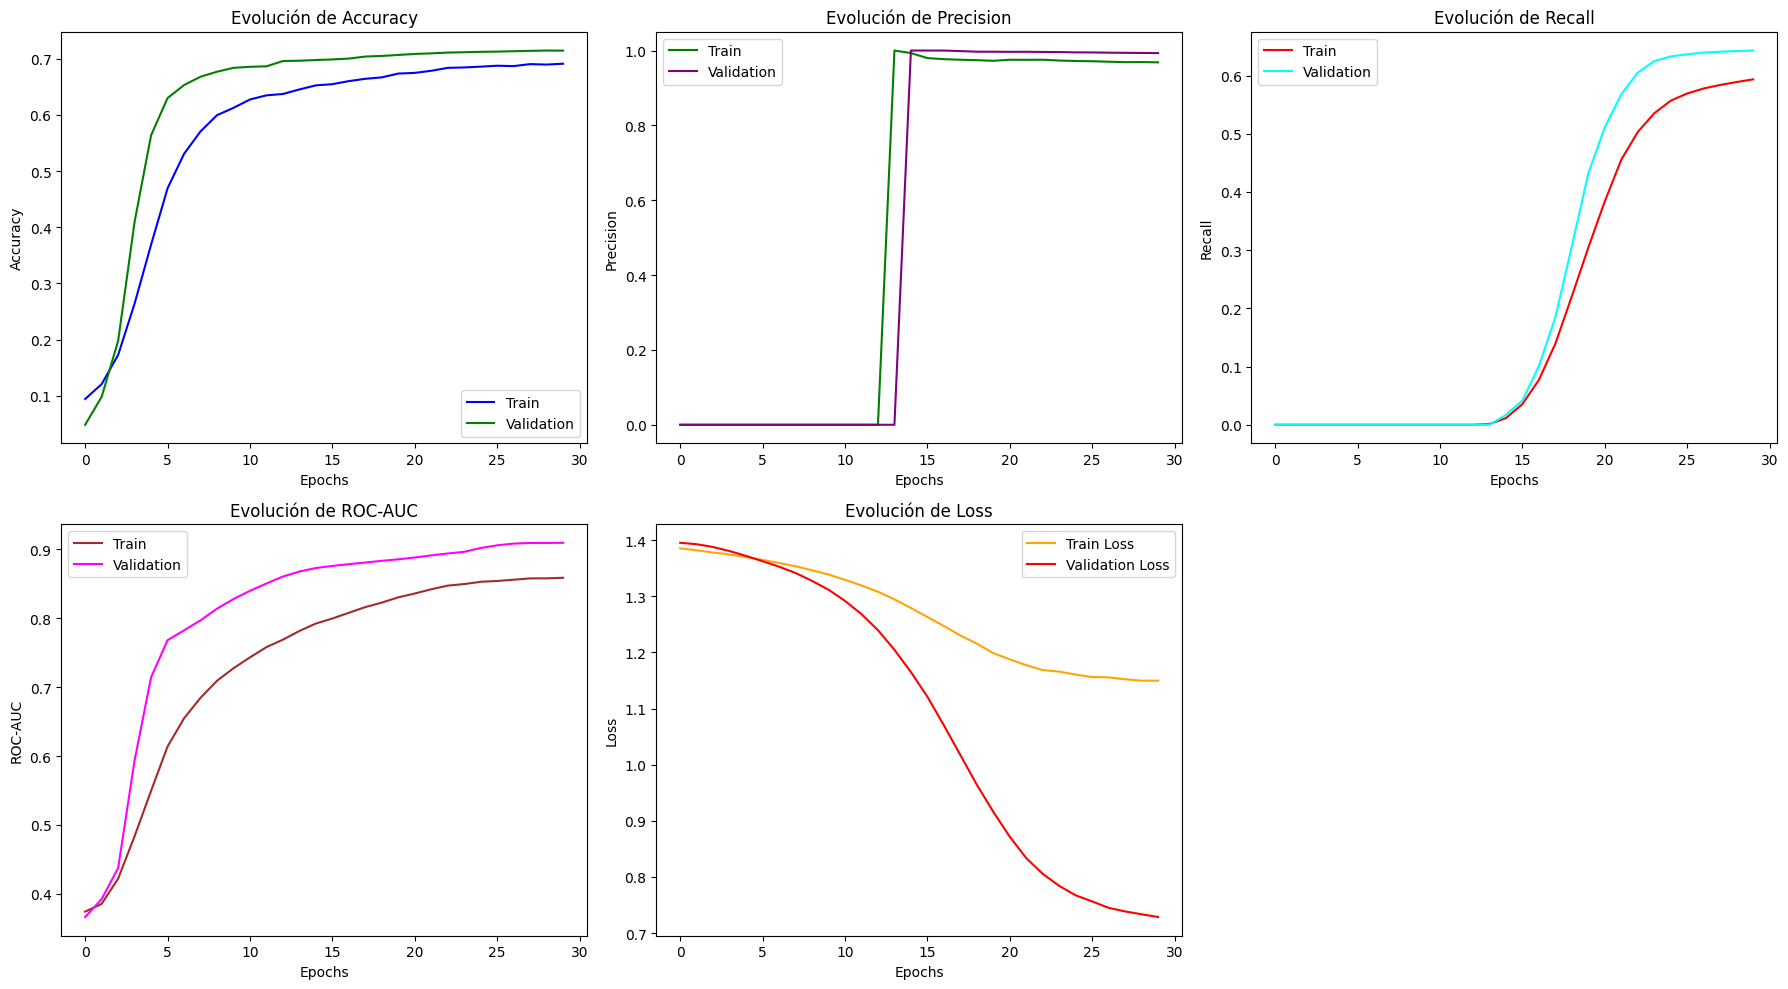

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save256, history_save256 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasbs_256metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 13691
Porcentaje de acierto: 72.89%
Porcentaje de fallo: 27.11%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


{'accuracy': 0.7289340302526333,
 'f1_score': 0.7099325600395824,
 'precision': 0.7642717038816486,
 'recall': 0.7289340302526333,
 'confusion_matrix': array([[  687,  6593,  1354,    14],
        [  187,  2140,   189,     7],
        [  430,  1193, 33989,    22],
        [  144,  3480,    78,     1]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (25914, 10, 4), Validación: (7404, 10, 4), Test: (3702, 10, 4)
Etiquetas Entrenamiento: (25914, 4), Validación: (7404, 4), Test: (3702, 4)
Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.0976 - loss: 1.3631 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3818 - val_accuracy: 0.0758 - val_loss: 1.3928 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3966
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1590 - loss: 1.3566 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4192 - val_accuracy: 0.2907 - val_loss: 1.3846 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5077
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3010 - loss: 1.3496 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5107 - val_accuracy: 0.5700 - val_loss: 1.3701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7185
Epoch 4/30

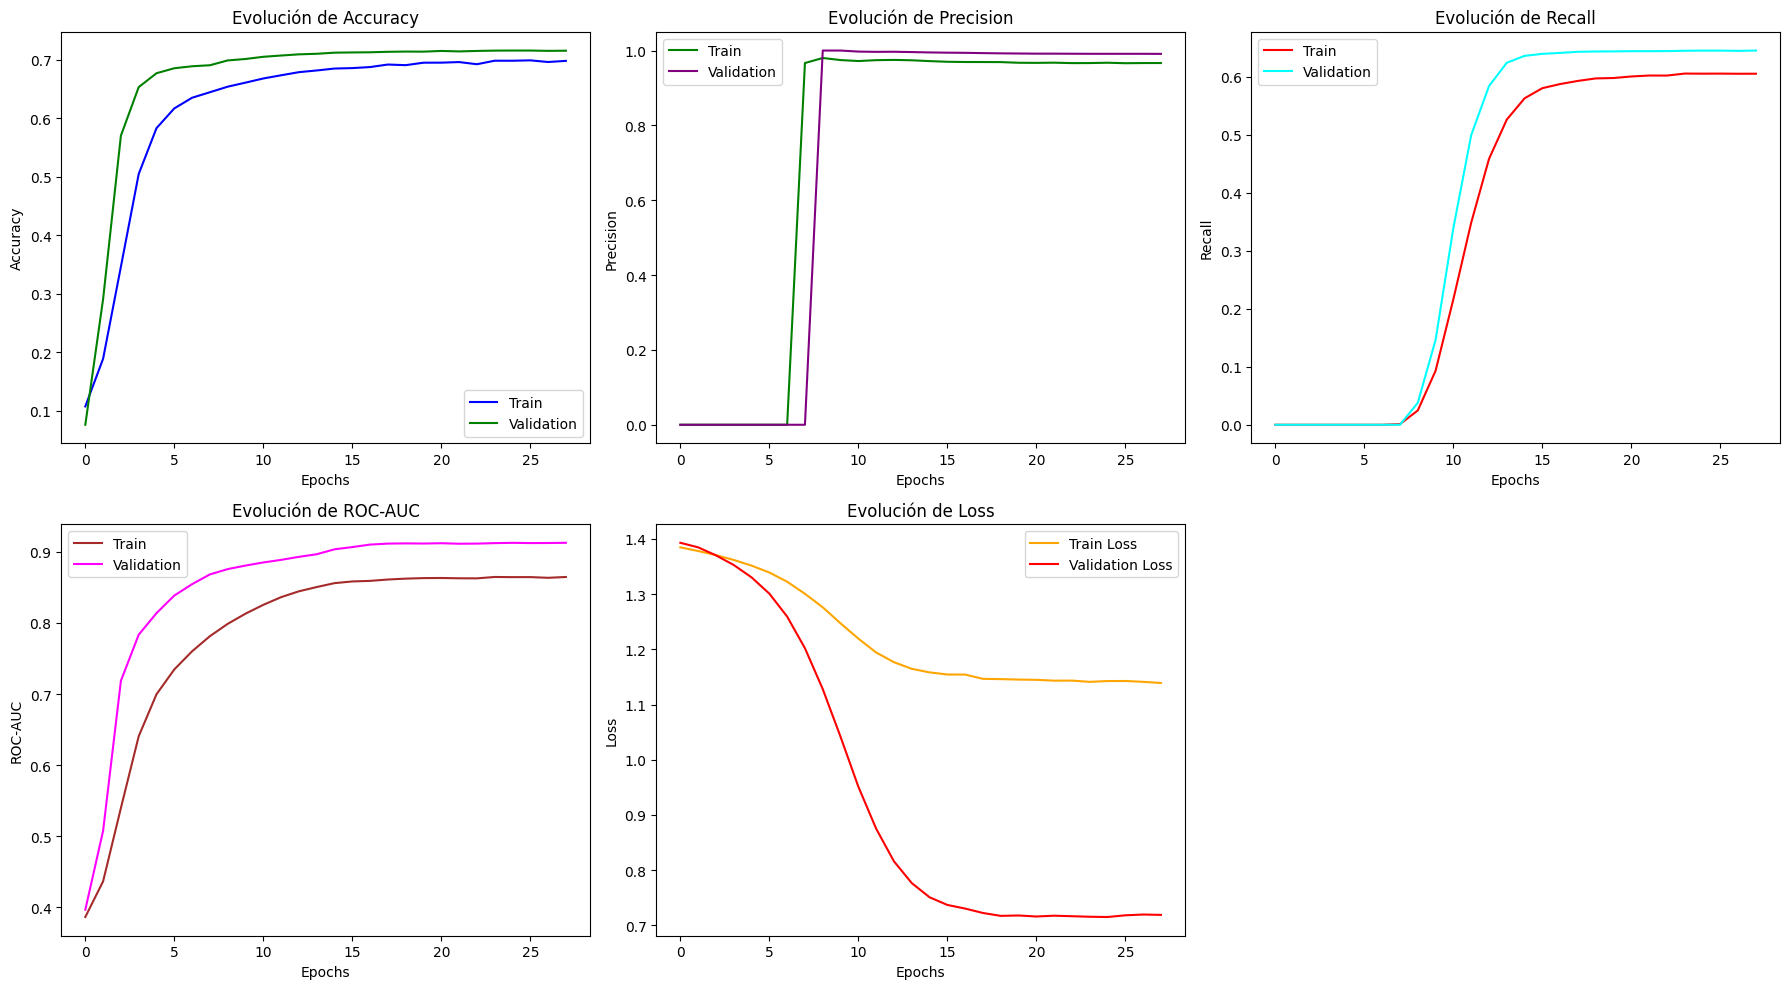

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save128, history_save128 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasbs_128metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save128, X_test, y_test)
GetMetrics(model_save128, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 13640
Porcentaje de acierto: 72.99%
Porcentaje de fallo: 27.01%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


{'accuracy': 0.729943771283757,
 'f1_score': 0.7129804263786284,
 'precision': 0.7724060360984701,
 'recall': 0.729943771283757,
 'confusion_matrix': array([[  758,  6415,  1364,   111],
        [  216,  2064,   198,    45],
        [  334,  1137, 34024,   139],
        [  195,  3407,    79,    22]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (25914, 10, 4), Validación: (7404, 10, 4), Test: (3702, 10, 4)
Etiquetas Entrenamiento: (25914, 4), Validación: (7404, 4), Test: (3702, 4)
Epoch 1/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.1099 - loss: 1.3619 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3916 - val_accuracy: 0.2042 - val_loss: 1.3870 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4613
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2859 - loss: 1.3507 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5056 - val_accuracy: 0.6110 - val_loss: 1.3636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7603
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5300 - loss: 1.3376 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6619 - val_accuracy: 0.6794 - val_loss: 1.3274 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8167
Epoch 4/30

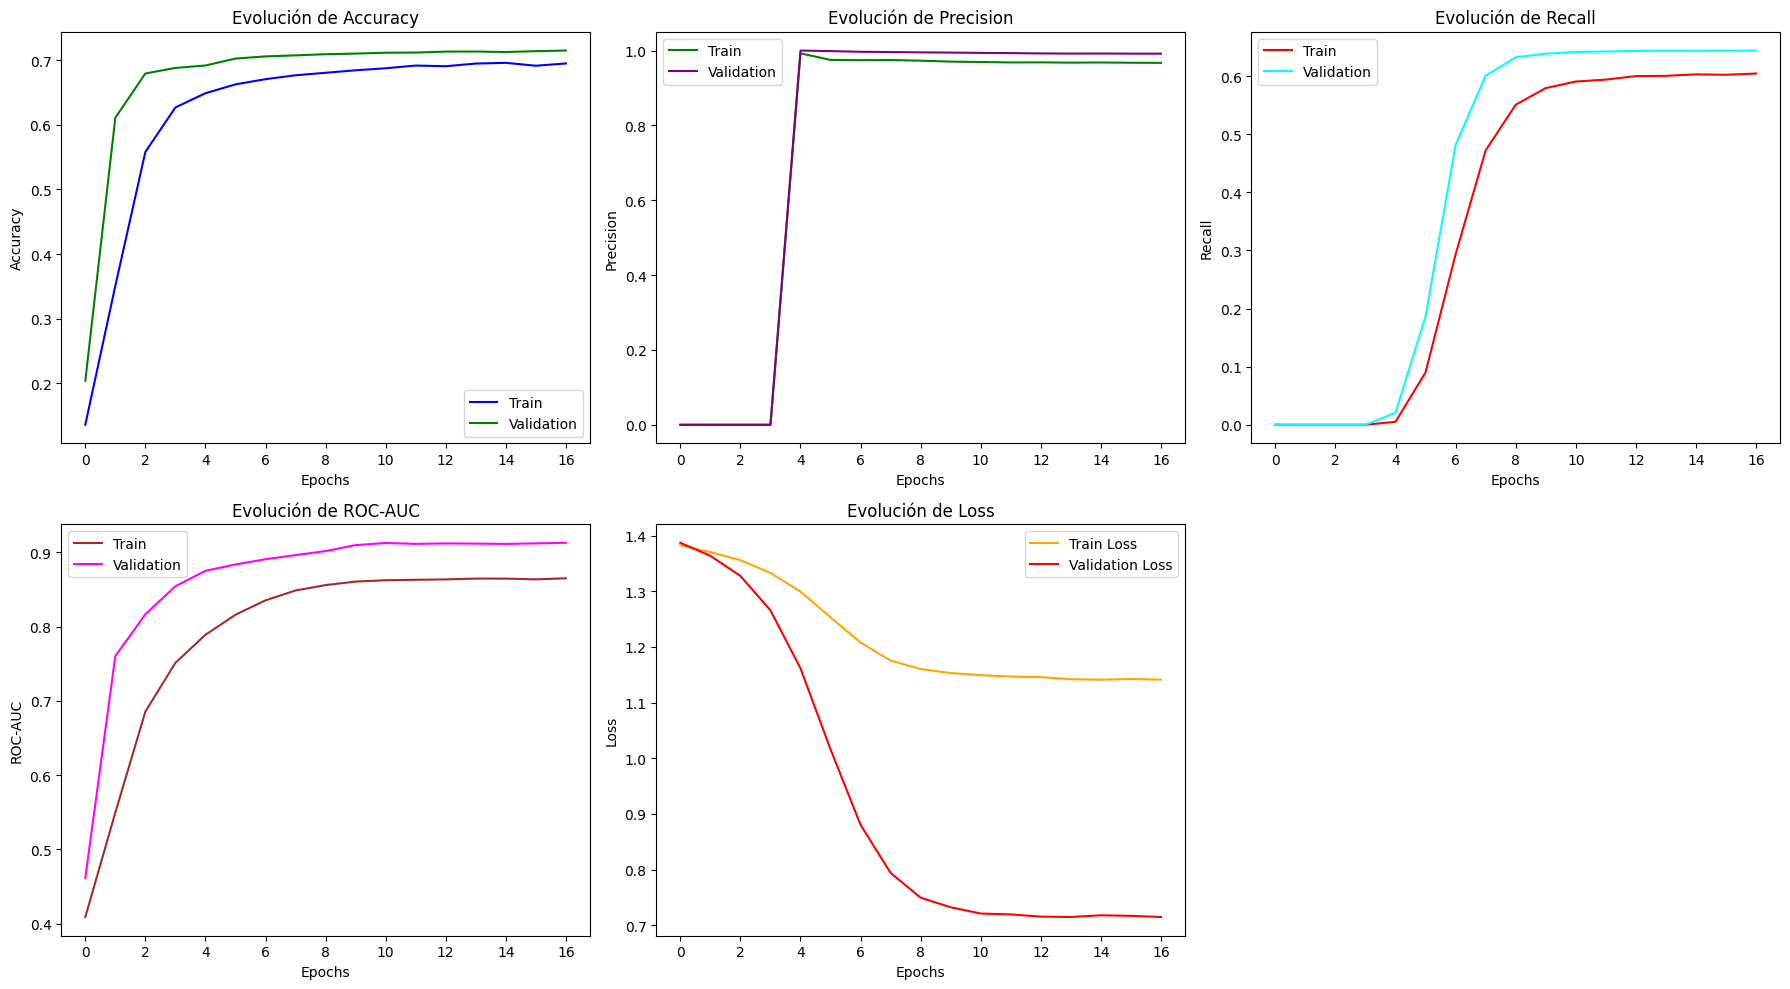

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y)
model_save64, history_save64 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_pruebasbs_64metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 13710
Porcentaje de acierto: 72.86%
Porcentaje de fallo: 27.14%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


{'accuracy': 0.7285578522214302,
 'f1_score': 0.7096871612191294,
 'precision': 0.7724417514648814,
 'recall': 0.7285578522214302,
 'confusion_matrix': array([[  637,  6598,  1336,    77],
        [  168,  2129,   185,    41],
        [  335,  1189, 34014,    96],
        [  145,  3467,    73,    18]]),
 'auc': None}

Tamaño de los conjuntos de datos:
Entrenamiento: (25914, 10, 4), Validación: (7404, 10, 4), Test: (3702, 10, 4)
Etiquetas Entrenamiento: (25914, 4), Validación: (7404, 4), Test: (3702, 4)
Epoch 1/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.1421 - loss: 1.3589 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4227 - val_accuracy: 0.5182 - val_loss: 1.3722 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6769
Epoch 2/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5007 - loss: 1.3399 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.6497 - val_accuracy: 0.6846 - val_loss: 1.3087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8367
Epoch 3/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6388 - loss: 1.3049 - precision: 0.3986 - recall: 6.5365e-04 - roc_auc: 0.7721 - val_accuracy: 0.6933 - val_loss: 1.1555 - val_precision: 1.0000 - val_recall: 0.0238 - val_roc_auc: 0.8771
Epoch 4/30
810/810 ━

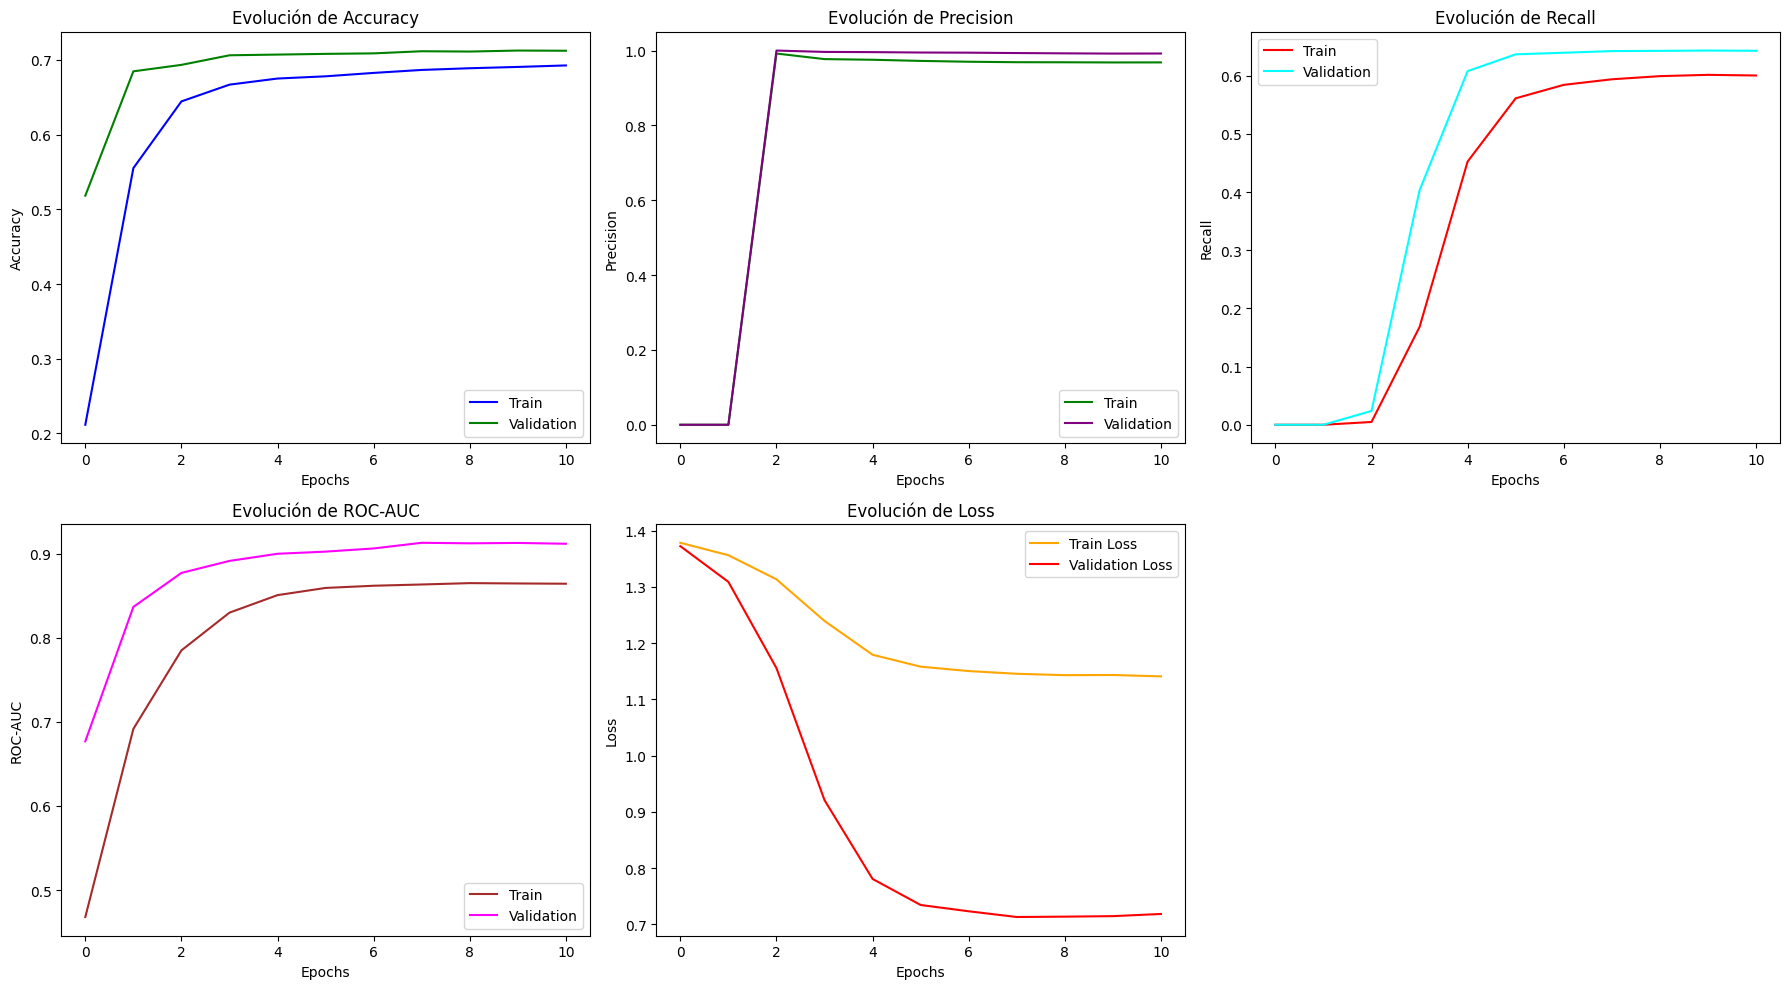

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save32, history_save32 = LSTM_(X_seq, y_seq, MODELOS+"final_LSTMDataset2_bs_32met_vent10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 13857
Porcentaje de acierto: 72.56%
Porcentaje de fallo: 27.44%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


{'accuracy': 0.7256474221905441,
 'f1_score': 0.7045494477686048,
 'precision': 0.7775072684764387,
 'recall': 0.7256474221905441,
 'confusion_matrix': array([[  446,  6699,  1312,   191],
        [  105,  2172,   171,    75],
        [  192,  1230, 34003,   209],
        [  101,  3502,    70,    30]]),
 'auc': None}

# RNN

## RNN: tamaño de ventana 5

In [ ]:
X, Y = preprocessing(DATASET2)

# 4:	Sueño ligero
# 5:	Sueño profundo
# 7:  Despierto
# 8:	REM


    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
4              12      0        80          66
14             23      0        80          63
24             41      0        96          71
34             18      0        80          73
44             26      0        80          67
0: 4
1: 5
2: 7
3: 8


Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2978 - loss: 1.4005 - precision: 0.0964 - recall: 1.3046e-04 - roc_auc: 0.6190 - val_accuracy: 0.3273 - val_loss: 1.3105 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6928
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3438 - loss: 1.3670 - precision: 0.4825 - recall: 1.5127e-04 - roc_auc: 0.6253 - val_accuracy: 0.4317 - val_loss: 1.3017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7311
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3635 - loss: 1.3481 - precision: 0.8246 - recall: 8.5347e-04 - roc_auc: 0.6266 - val_accuracy: 0.5093 - val_loss: 1.2882 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7648
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3995 - loss: 1.3417 - precision: 0.8676 - recall: 0.0018 - roc_auc: 0.6446 - val_accuracy: 0.5779 - val_loss: 1.2694 - val_precision: 0.0000e+00

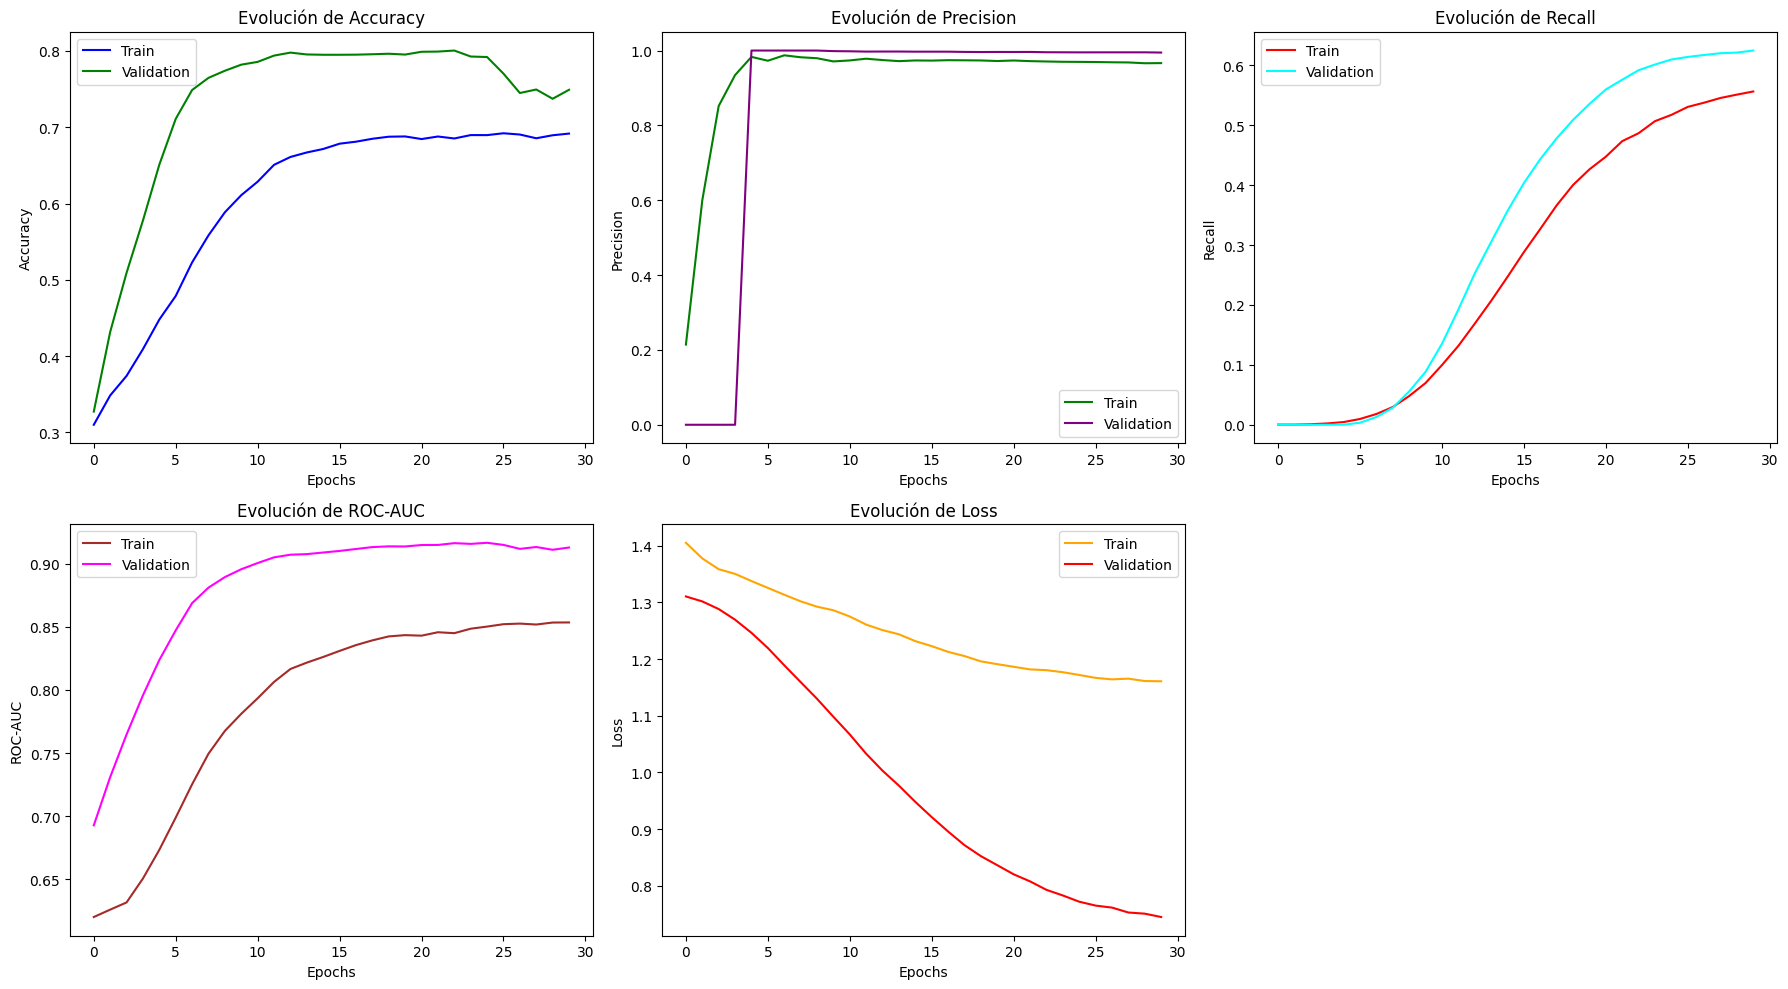

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save256, history_save256 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_256metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12022
Porcentaje de acierto: 76.20%
Porcentaje de fallo: 23.80%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


{'accuracy': 0.7620018609070932,
 'f1_score': 0.7611472119121009,
 'precision': 0.7761133620299849,
 'recall': 0.7620018609070932,
 'confusion_matrix': array([[ 3212,  3978,  1338,   120],
        [ 1155,  1240,    92,    36],
        [  702,   663, 34019,   255],
        [ 1122,  2532,    29,    20]]),
 'auc': None}

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1899 - loss: 1.3906 - precision: 0.1165 - recall: 0.0015 - roc_auc: 0.4906 - val_accuracy: 0.4817 - val_loss: 1.3091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6921
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3515 - loss: 1.3427 - precision: 0.6864 - recall: 0.0031 - roc_auc: 0.6087 - val_accuracy: 0.6759 - val_loss: 1.2033 - val_precision: 1.0000 - val_recall: 4.0513e-04 - val_roc_auc: 0.8262
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4779 - loss: 1.3065 - precision: 0.9624 - recall: 0.0155 - roc_auc: 0.7016 - val_accuracy: 0.6987 - val_loss: 1.1141 - val_precision: 1.0000 - val_recall: 0.0236 - val_roc_auc: 0.8705
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5600 - loss: 1.2785 - precision: 0.9733 - recall: 0.0536 - roc_auc: 0.7575 - val_accuracy: 0.7018 - val_loss: 1.0400 - val_precision: 0.9990 - val_recall: 0.1371 - val_ro

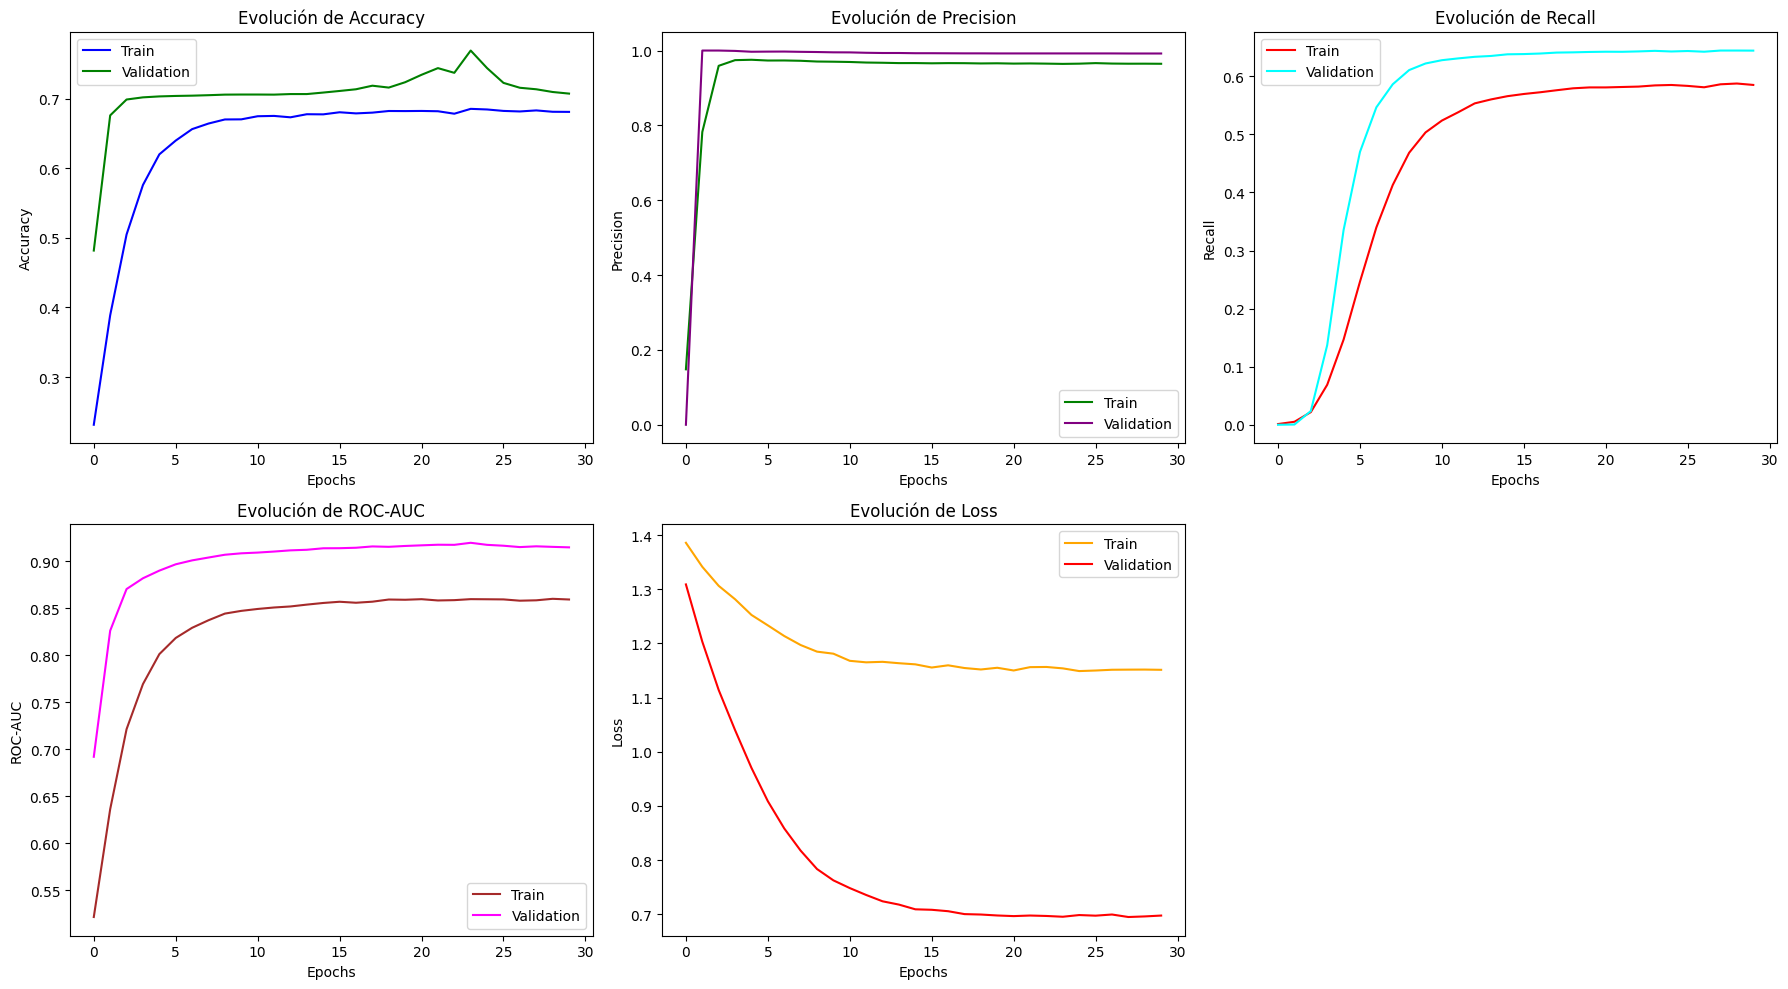

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save128, history_save128 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_128metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save128, X_test, y_test)
GetMetrics(model_save128, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 13663
Porcentaje de acierto: 72.95%
Porcentaje de fallo: 27.05%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


{'accuracy': 0.7295151743115633,
 'f1_score': 0.7085427923266584,
 'precision': 0.787317389151241,
 'recall': 0.7295151743115633,
 'confusion_matrix': array([[  461,  6406,  1353,   428],
        [   95,  2265,    84,    79],
        [  143,  1053, 34056,   387],
        [  114,  3496,    25,    68]]),
 'auc': None}

Epoch 1/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2232 - loss: 1.3830 - precision: 0.1332 - recall: 0.0011 - roc_auc: 0.5135 - val_accuracy: 0.6385 - val_loss: 1.2346 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7996
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4618 - loss: 1.3151 - precision: 0.9483 - recall: 0.0135 - roc_auc: 0.6885 - val_accuracy: 0.6997 - val_loss: 1.0944 - val_precision: 1.0000 - val_recall: 0.0394 - val_roc_auc: 0.8756
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5758 - loss: 1.2690 - precision: 0.9722 - recall: 0.0795 - roc_auc: 0.7718 - val_accuracy: 0.7032 - val_loss: 0.9841 - val_precision: 0.9973 - val_recall: 0.2974 - val_roc_auc: 0.8888
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6283 - loss: 1.2347 - precision: 0.9733 - recall: 0.2138 - roc_auc: 0.8073 - val_accuracy: 0.7040 - val_loss: 0.8884 - val_precision: 0.9973 - val_recall: 0.5060 - val_roc_auc

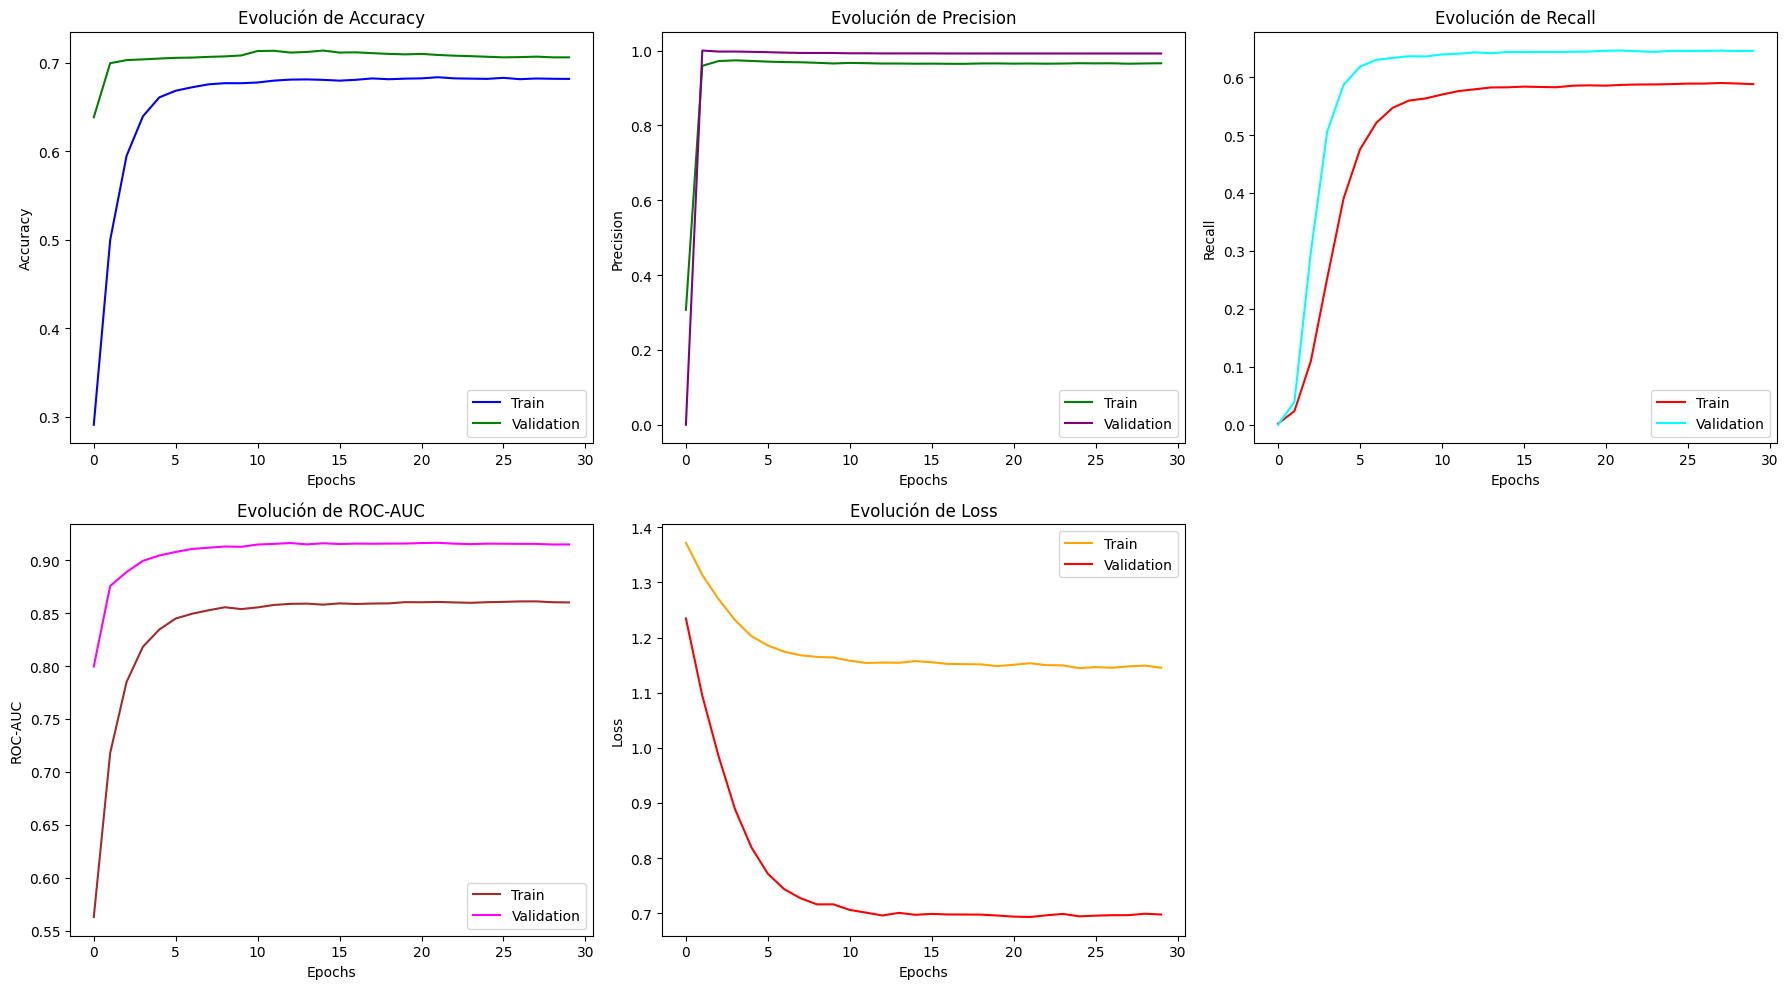

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save64, history_save64 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_64metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 13802
Porcentaje de acierto: 72.68%
Porcentaje de fallo: 27.32%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


{'accuracy': 0.726763407439669,
 'f1_score': 0.7021067909915647,
 'precision': 0.7701301600394227,
 'recall': 0.726763407439669,
 'confusion_matrix': array([[  289,  6624,  1365,   370],
        [  124,  2277,    85,    37],
        [  131,  1089, 34094,   325],
        [   69,  3556,    27,    51]]),
 'auc': None}

Epoch 1/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3313 - loss: 1.3837 - precision: 0.3832 - recall: 4.5042e-04 - roc_auc: 0.6218 - val_accuracy: 0.5973 - val_loss: 1.2599 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8063
Epoch 2/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4695 - loss: 1.3185 - precision: 0.9645 - recall: 0.0097 - roc_auc: 0.6912 - val_accuracy: 0.7662 - val_loss: 1.1443 - val_precision: 1.0000 - val_recall: 0.0411 - val_roc_auc: 0.8857
Epoch 3/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5995 - loss: 1.2750 - precision: 0.9663 - recall: 0.0692 - roc_auc: 0.7768 - val_accuracy: 0.7901 - val_loss: 1.0243 - val_precision: 0.9968 - val_recall: 0.2112 - val_roc_auc: 0.9048
Epoch 4/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6658 - loss: 1.2344 - precision: 0.9723 - recall: 0.2025 - roc_auc: 0.8177 - val_accuracy: 0.8003 - val_loss: 0.9116 - val_precision: 0.9971 - val_recall: 0.4176 - val_roc

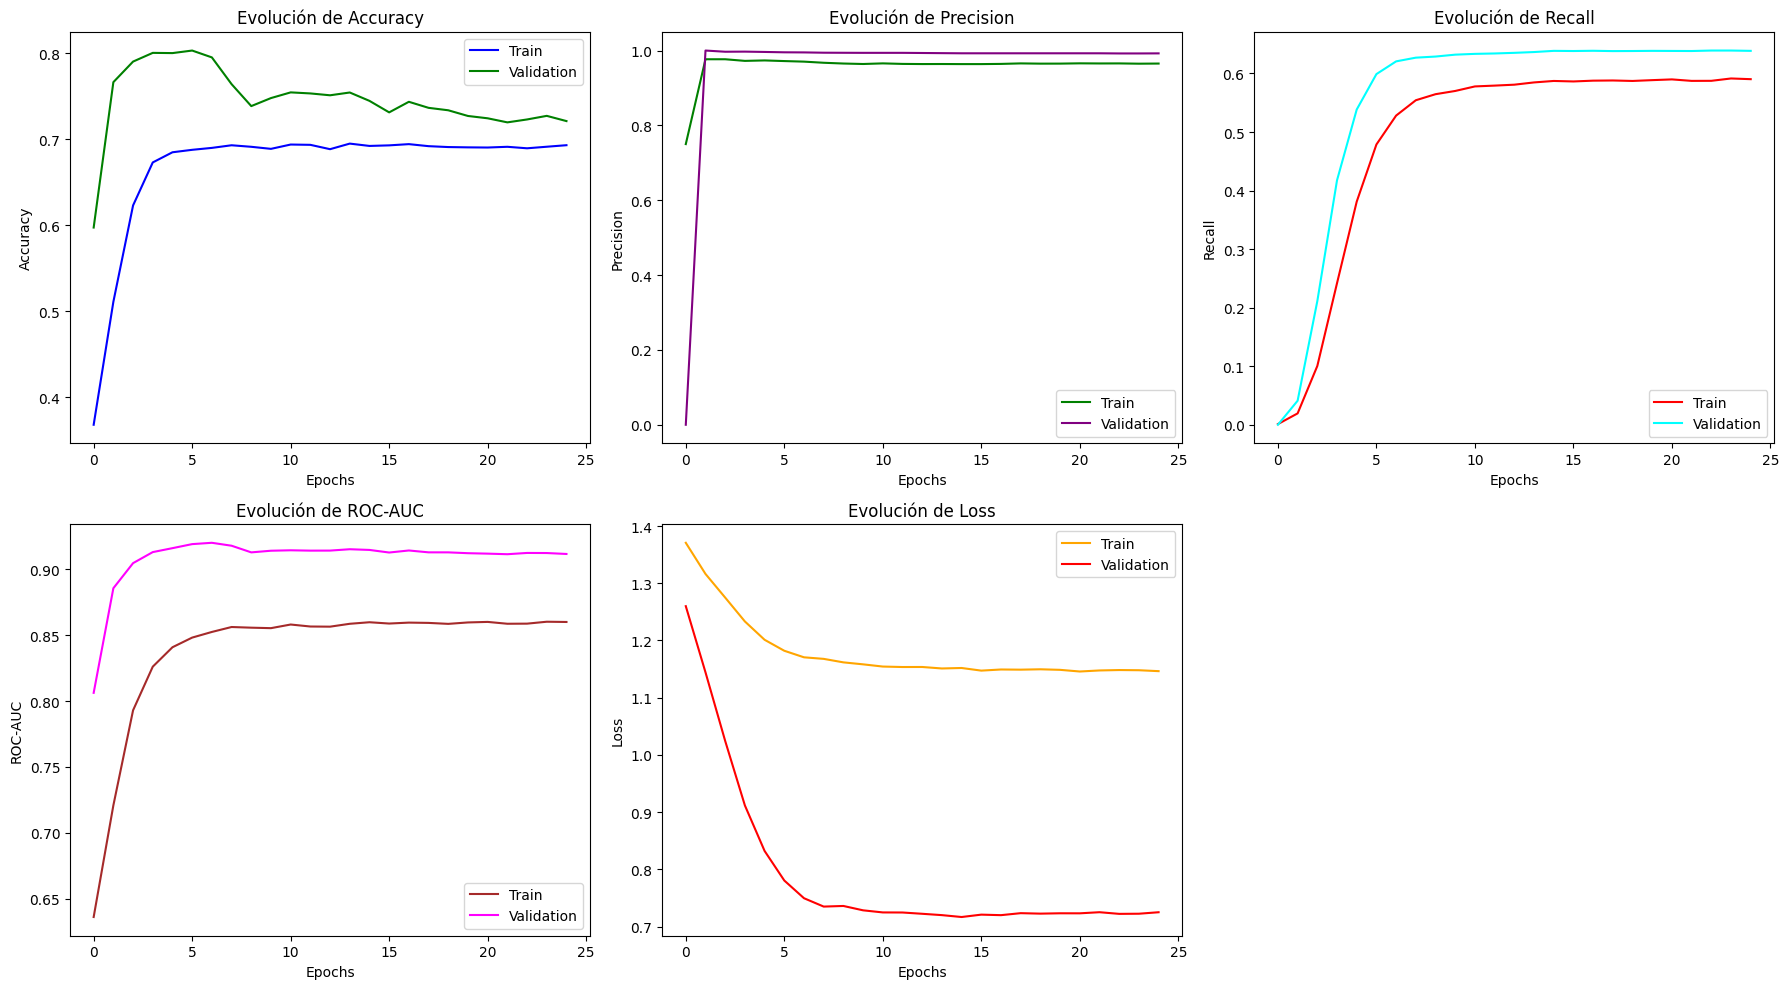

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y, sequence_length=5)
model_save32, history_save32 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_32metricas_ventana5_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Número de elementos:  50513
Número de elementos diferentes de 0: 12158
Porcentaje de acierto: 75.93%
Porcentaje de fallo: 24.07%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


{'accuracy': 0.7593094846871102,
 'f1_score': 0.7525888569267097,
 'precision': 0.7923845812365019,
 'recall': 0.7593094846871102,
 'confusion_matrix': array([[ 2146,  4895,  1365,   242],
        [  314,  2063,    93,    53],
        [  528,   695, 34106,   310],
        [  609,  3024,    30,    40]]),
 'auc': None}

## RNN: tamaño de ventana 10

In [ ]:
X, Y = preprocessing(DATASET2)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
4              12      0        80          66
14             23      0        80          63
24             41      0        96          71
34             18      0        80          73
44             26      0        80          67
0: 4
1: 5
2: 7
3: 8


Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1067 - loss: 1.4305 - precision: 0.1007 - recall: 0.0011 - roc_auc: 0.2955 - val_accuracy: 0.0685 - val_loss: 1.5274 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.2187
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1669 - loss: 1.4013 - precision: 0.1115 - recall: 3.5385e-04 - roc_auc: 0.3886 - val_accuracy: 0.1442 - val_loss: 1.4314 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4054
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2535 - loss: 1.3634 - precision: 0.2480 - recall: 4.5767e-04 - roc_auc: 0.4967 - val_accuracy: 0.3432 - val_loss: 1.3449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6239
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3543 - loss: 1.3395 - precision: 0.5801 - recall: 7.6431e-04 - roc_auc: 0.5966 - val_accuracy: 0.5501 - val_loss: 1.2700 - val_precision: 0.0000e+00

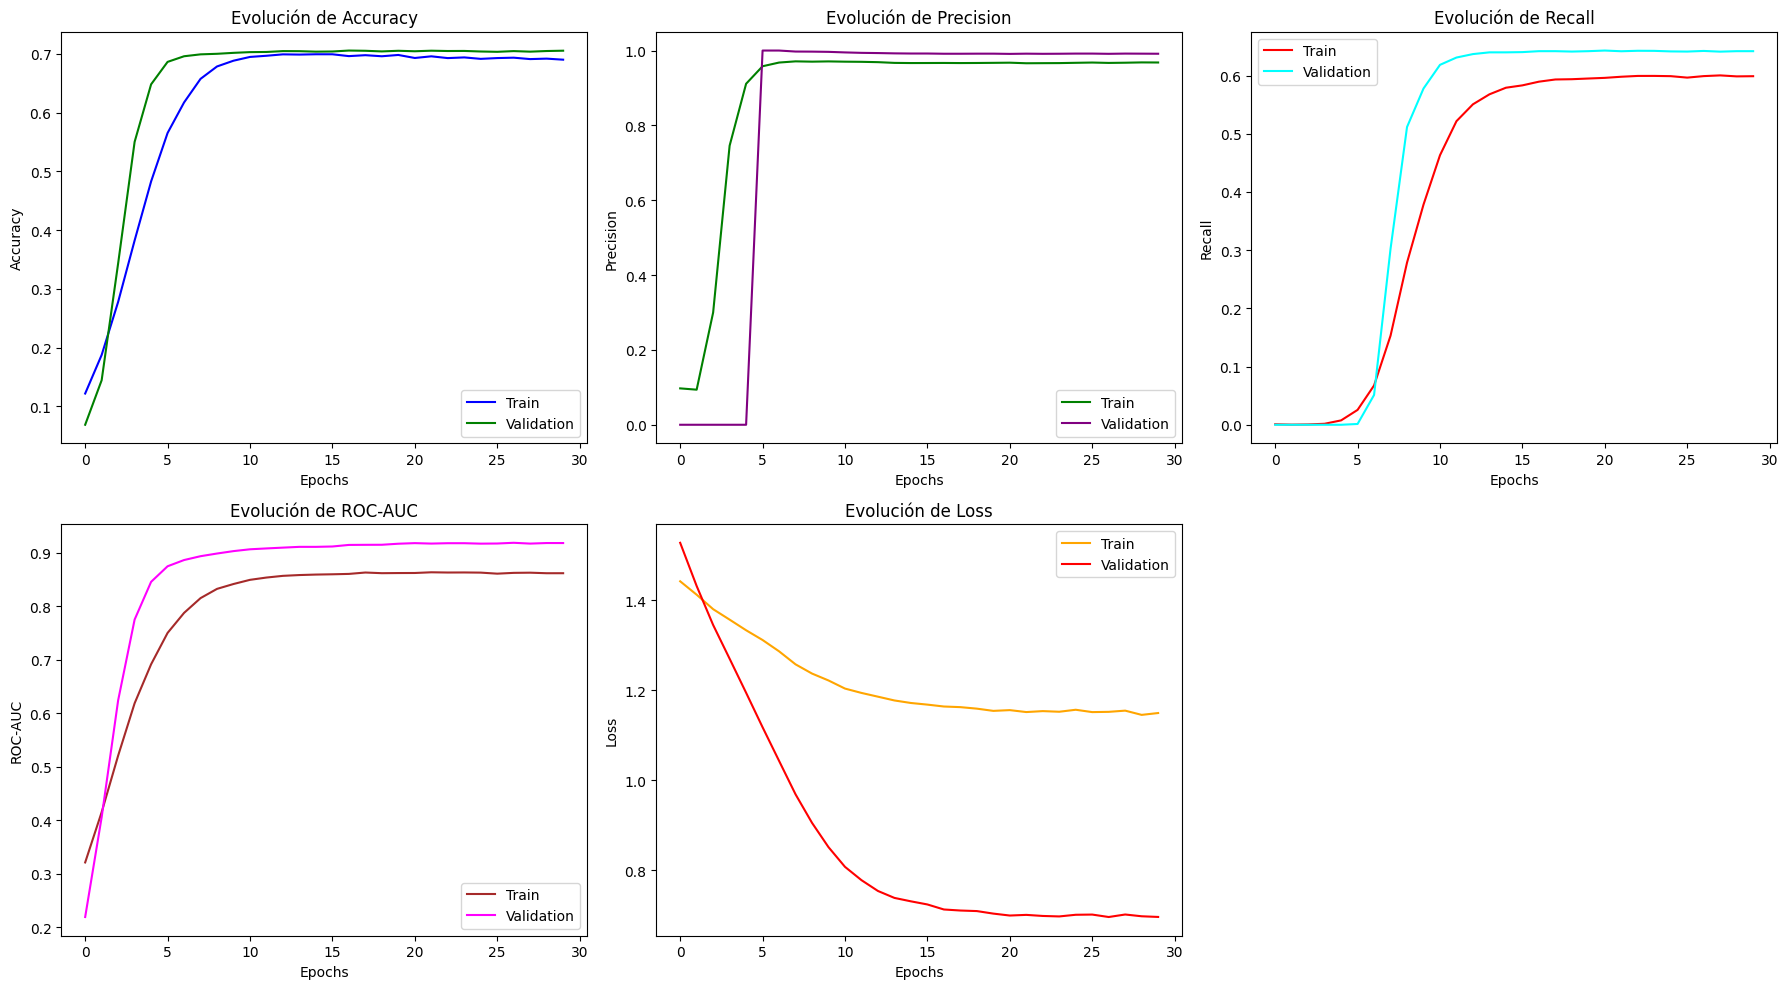

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 256
X_seq, y_seq = create_sequences(X, Y,sequence_length=10)
model_save256, history_save256 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_256metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 13986
Porcentaje de acierto: 72.31%
Porcentaje de fallo: 27.69%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


{'accuracy': 0.7230933713471134,
 'f1_score': 0.6976648820418003,
 'precision': 0.7751278098030556,
 'recall': 0.7230933713471134,
 'confusion_matrix': array([[  159,  7148,  1171,   170],
        [    6,  2394,    74,    49],
        [  167,  1281, 33921,   265],
        [    8,  3628,    19,    48]]),
 'auc': None}

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4887 - loss: 1.4130 - precision: 0.2715 - recall: 4.7886e-04 - roc_auc: 0.7391 - val_accuracy: 0.4864 - val_loss: 1.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7519
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3805 - loss: 1.3660 - precision: 0.4179 - recall: 2.2390e-04 - roc_auc: 0.6713 - val_accuracy: 0.4028 - val_loss: 1.3136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7225
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3875 - loss: 1.3440 - precision: 0.7378 - recall: 0.0012 - roc_auc: 0.6786 - val_accuracy: 0.5674 - val_loss: 1.2659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7997
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4799 - loss: 1.3206 - precision: 0.9249 - recall: 0.0038 - roc_auc: 0.7319 - val_accuracy: 0.7397 - val_loss: 1.1731 - val_precision: 0.0000e+00 - v

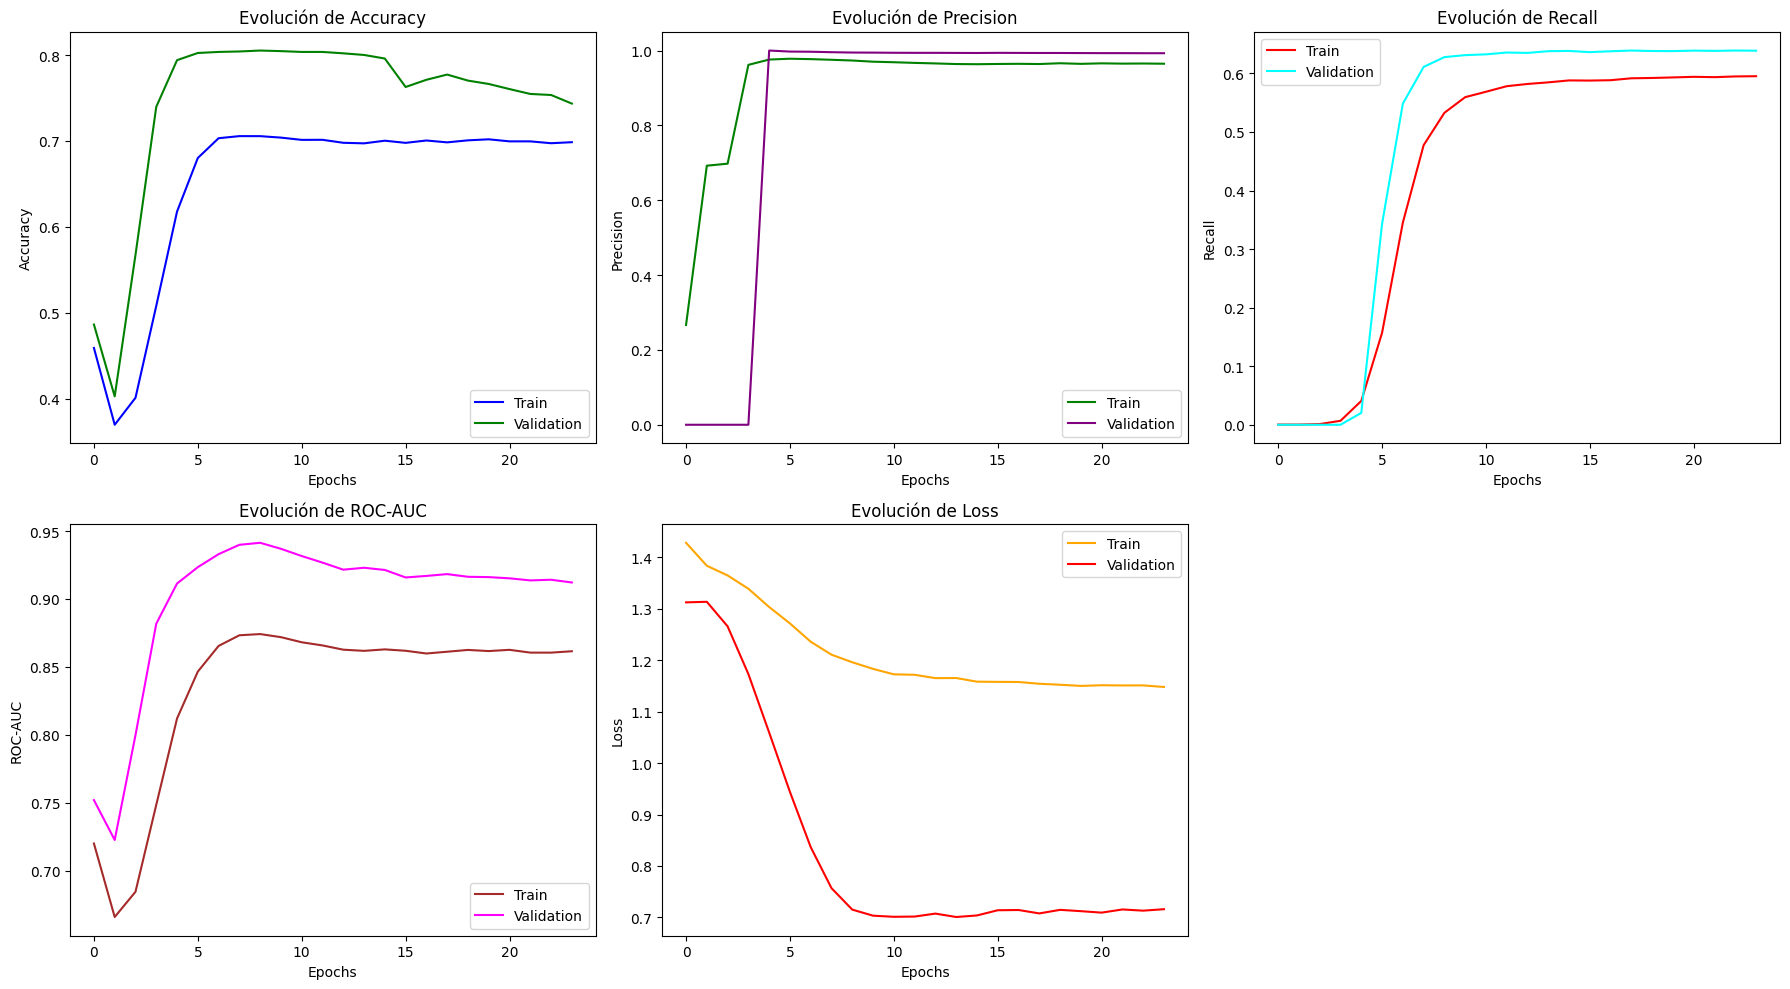

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 128
X_seq, y_seq = create_sequences(X, Y)
model_save128, history_save128 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_128metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save128, X_test, y_test)
GetMetrics(model_save128, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 9905
Porcentaje de acierto: 80.39%
Porcentaje de fallo: 19.61%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


{'accuracy': 0.8038924526807635,
 'f1_score': 0.7783312360841236,
 'precision': 0.7689279511288131,
 'recall': 0.8038924526807635,
 'confusion_matrix': array([[ 6726,   590,  1174,   158],
        [ 2297,    64,   119,    43],
        [ 1498,   109, 33784,   243],
        [ 3476,   155,    43,    29]]),
 'auc': None}

Epoch 1/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2553 - loss: 1.4131 - precision: 0.3032 - recall: 0.0029 - roc_auc: 0.6355 - val_accuracy: 0.1811 - val_loss: 1.3293 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.6428
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2973 - loss: 1.3404 - precision: 0.6773 - recall: 0.0072 - roc_auc: 0.6171 - val_accuracy: 0.6309 - val_loss: 1.1740 - val_precision: 1.0000 - val_recall: 0.0049 - val_roc_auc: 0.8395
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5209 - loss: 1.2872 - precision: 0.9344 - recall: 0.0606 - roc_auc: 0.7431 - val_accuracy: 0.6958 - val_loss: 0.9925 - val_precision: 0.9995 - val_recall: 0.2608 - val_roc_auc: 0.8909
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6460 - loss: 1.2188 - precision: 0.9659 - recall: 0.2414 - roc_auc: 0.8170 - val_accuracy: 0.6984 - val_loss: 0.8831 - val_precision: 0.9974 - val_recall: 0.5646 - val_roc

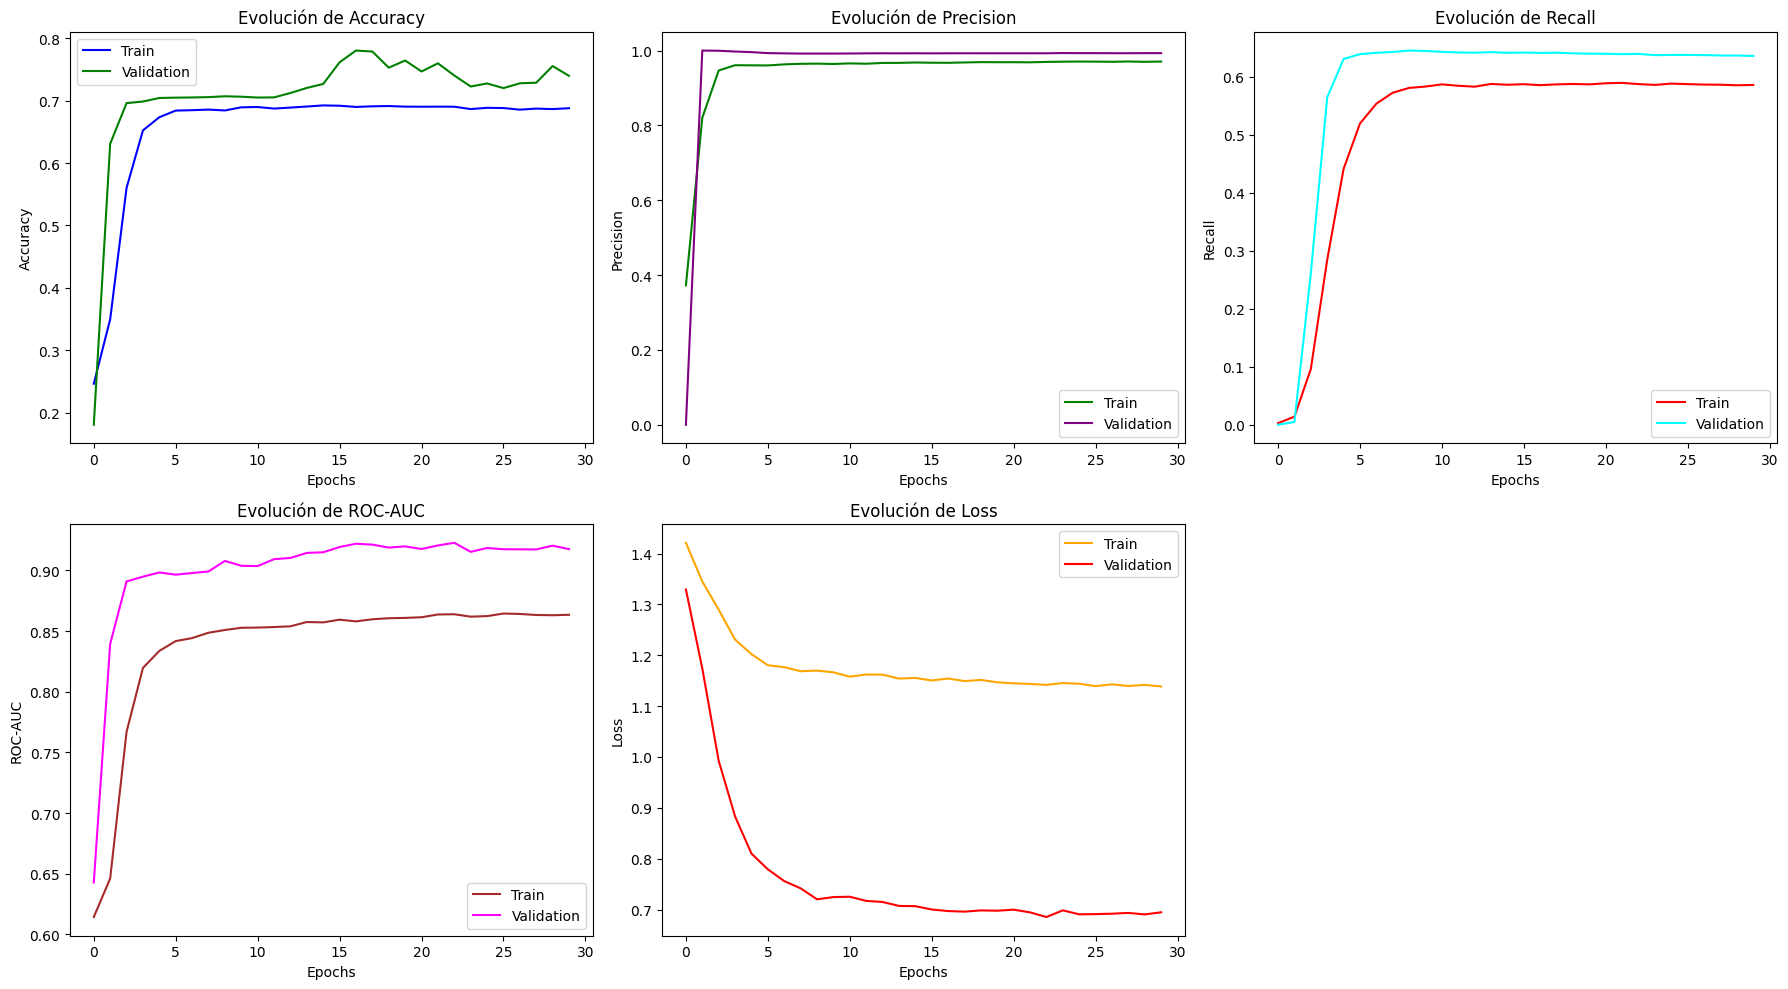

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y)
model_save64, history_save64 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_pruebasbs_64metricas_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save64, X_test, y_test)
GetMetrics(model_save64, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12440
Porcentaje de acierto: 75.37%
Porcentaje de fallo: 24.63%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


{'accuracy': 0.7537023837807872,
 'f1_score': 0.7497194267542624,
 'precision': 0.7952527181165039,
 'recall': 0.7537023837807872,
 'confusion_matrix': array([[ 1920,  5142,  1050,   536],
        [  189,  2196,    70,    68],
        [  481,   728, 33897,   528],
        [  725,  2910,    13,    55]]),
 'auc': None}

Epoch 1/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.1728 - loss: 1.4068 - precision: 0.1029 - recall: 6.9360e-04 - roc_auc: 0.3863 - val_accuracy: 0.5956 - val_loss: 1.2367 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8098
Epoch 2/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5623 - loss: 1.2862 - precision: 0.9367 - recall: 0.0348 - roc_auc: 0.7510 - val_accuracy: 0.6988 - val_loss: 0.9433 - val_precision: 0.9974 - val_recall: 0.4190 - val_roc_auc: 0.8942
Epoch 3/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6838 - loss: 1.2019 - precision: 0.9727 - recall: 0.3732 - roc_auc: 0.8400 - val_accuracy: 0.7023 - val_loss: 0.7690 - val_precision: 0.9938 - val_recall: 0.6318 - val_roc_auc: 0.9086
Epoch 4/30
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7028 - loss: 1.1576 - precision: 0.9696 - recall: 0.5647 - roc_auc: 0.8600 - val_accuracy: 0.7026 - val_loss: 0.7214 - val_precision: 0.9925 - val_recall: 0.6399 - val

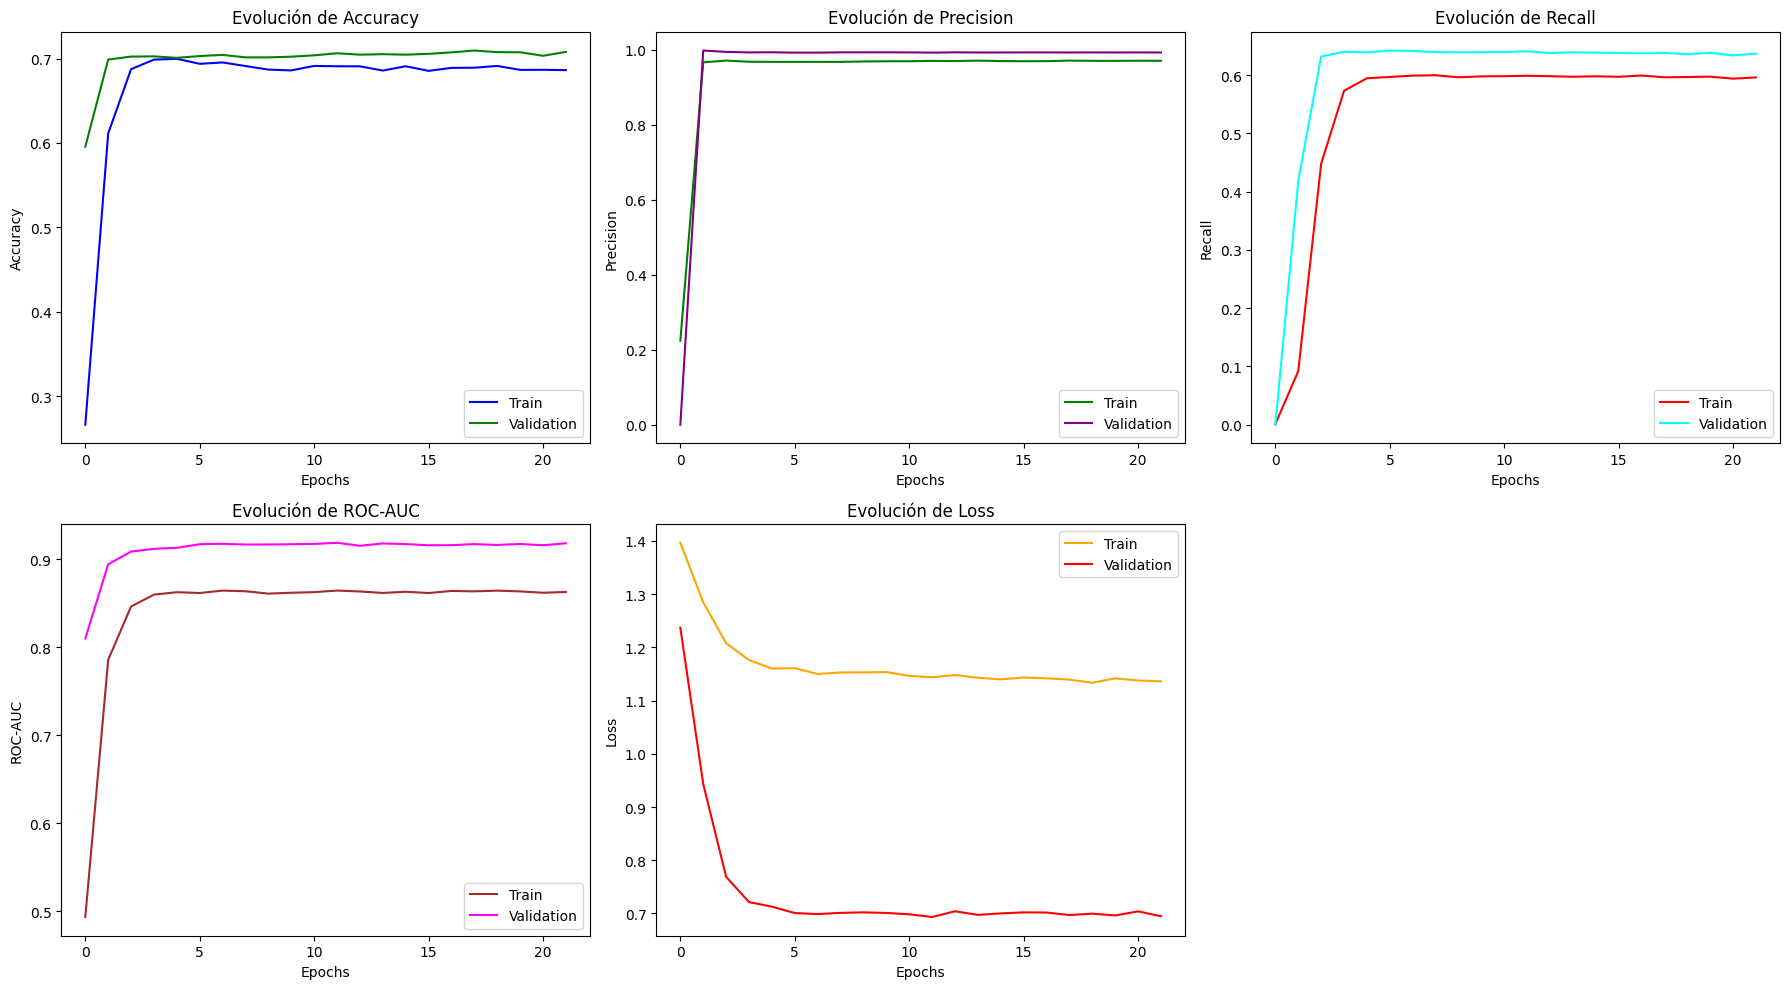

<Figure size 640x480 with 0 Axes>

In [ ]:
## Batch size = 32
X_seq, y_seq = create_sequences(X, Y)
model_save32, history_save32 = RNN(X_seq, y_seq, MODELOS+"final_RNNDataset2_bs_32met_vent10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save32, X_test, y_test)
GetMetrics(model_save32, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 13876
Porcentaje de acierto: 72.53%
Porcentaje de fallo: 27.47%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


{'accuracy': 0.7252712441593411,
 'f1_score': 0.703122956510738,
 'precision': 0.7835094155652051,
 'recall': 0.7252712441593411,
 'confusion_matrix': array([[  248,  6960,  1092,   348],
        [   17,  2374,    46,    86],
        [  212,  1124, 33935,   363],
        [   15,  3605,     8,    75]]),
 'auc': None}

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=6 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=6 is greater than n_features=4. All the features will be returned.
  warnings.warn(


   RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
0             66      7        80          80
1             77     62        80         130
2             15      0        80         112
3             63     26        64         131
4            106     95        64         125
0: 4
1: 5
2: 7
3: 8
Tamaño de los conjuntos de datos:
Entrenamiento: (30207, 10, 4), Validación: (8630, 10, 4), Test: (4316, 10, 4)
Etiquetas Entrenamiento: (30207, 4), Validación: (8630, 4), Test: (4316, 4)
Epoch 1/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5932 - loss: 1.3856 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7652 - val_accuracy: 0.7381 - val_loss: 1.3249 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8914
Epoch 2/30
944/944 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7327 - loss: 1.3246 - precision: 0.2529 - recall: 2.0491e-04 - roc_auc: 0.8901 - val_accuracy: 0.7495 - val_loss: 1.0944 - val_precision: 1.0000 - val_recall: 0.0306 - val_roc_auc: 0

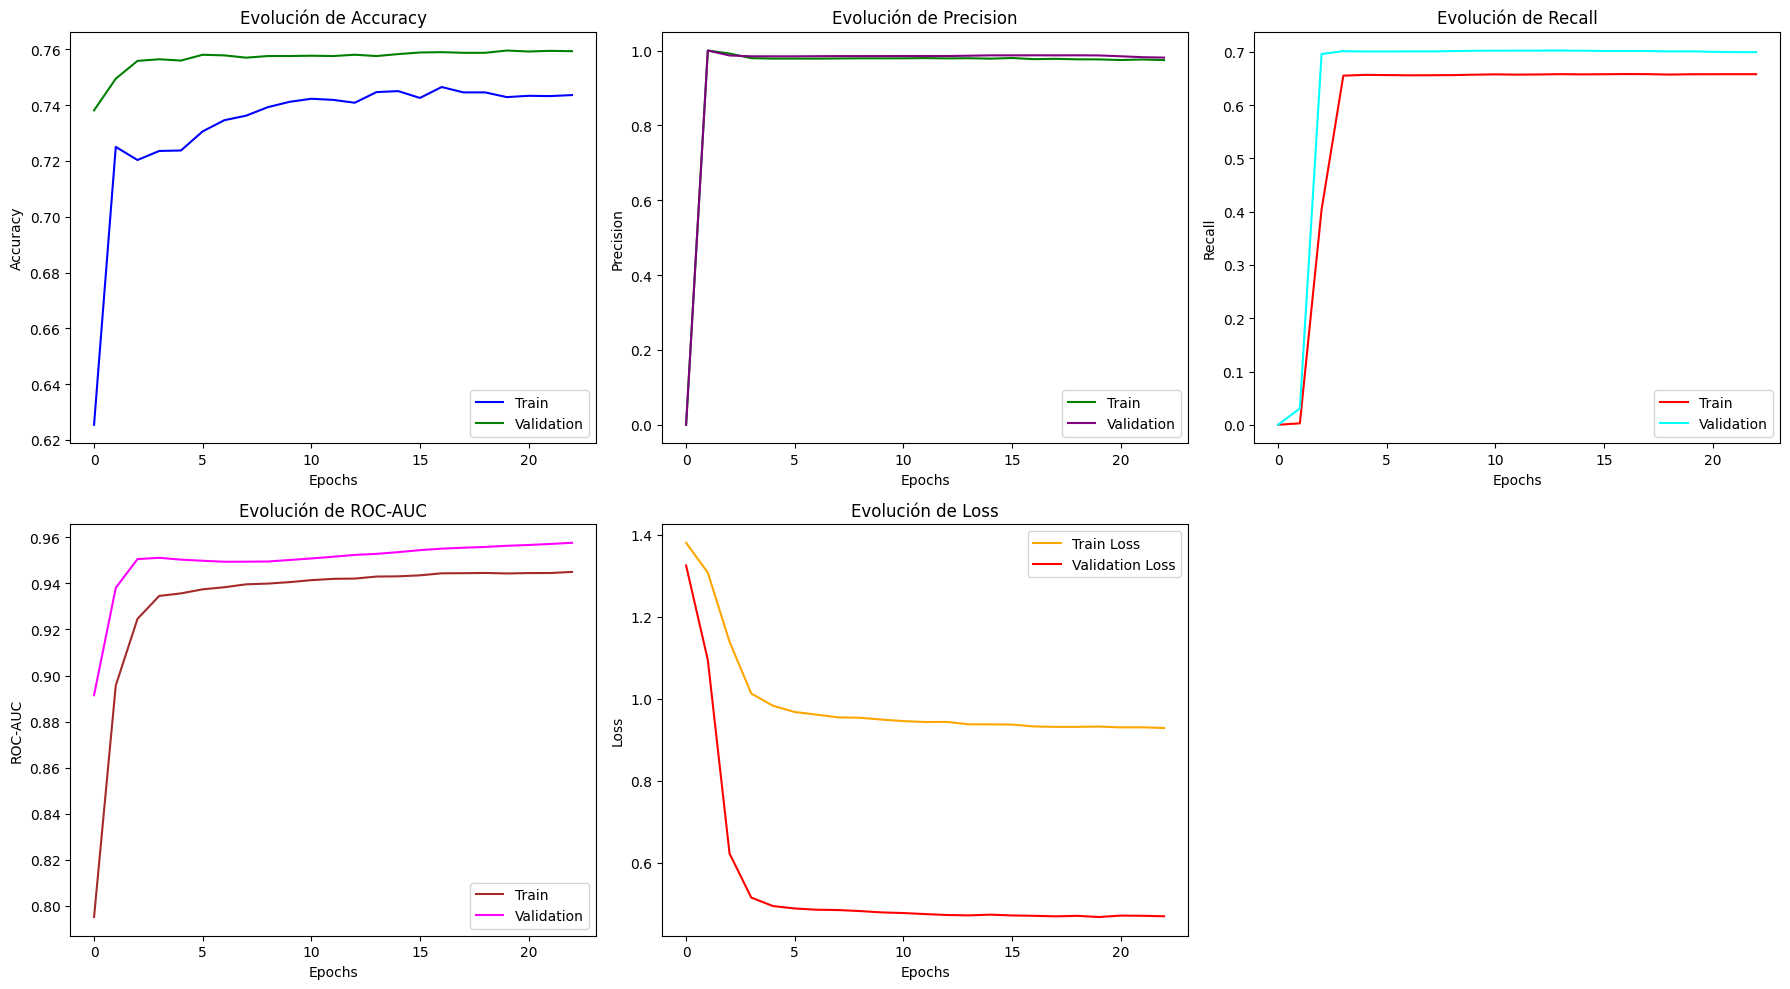

In [ ]:
X, Y = preprocessing(DATASET1, selectFeatures=True)
## Batch size = 64
X_seq, y_seq = create_sequences(X, Y, sequence_length=10)
model_save256, history_save256 = LSTM_(X_seq, y_seq, MODELOS+"final_horasLSTMDataset1_pruebasmetrica32s_ventana10_.keras", normalize=True)

In [ ]:
X,y = preprocessing(DATASET3)
X_test, y_test = create_sequences(X, y)
# model = load_model(MODELOS+'Pesos_LSTMDataset1_pruebasmetricas_ventana5_.keras')
X_test = Normalize(X_test)
Evaluation(model_save256, X_test, y_test)
GetMetrics(model_save256, X_test, y_test)

    RAW_INTENSITY  STEPS  RAW_KIND  HEART_RATE
2              10      0        80          67
48            122      7       112         112
49            106      0       112          98
50            106     57        64         106
51            108     28        96         109
0: 4
1: 5
2: 7
3: 8
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Número de elementos:  50508
Número de elementos diferentes de 0: 12549
Porcentaje de acierto: 75.15%
Porcentaje de fallo: 24.85%
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


{'accuracy': 0.7515443098123069,
 'f1_score': 0.7282157440071628,
 'precision': 0.8112458335466538,
 'recall': 0.7515443098123069,
 'confusion_matrix': array([[  161,  3495,  1071,  3921],
        [   26,  1352,    94,  1051],
        [   80,   821, 34010,   723],
        [   15,  1231,    21,  2436]]),
 'auc': None}